<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>


### CCUS GOM Uncertainty Quantification Workflow

#### Michael Pyrcz, Associate Professor

### The University of Texas at Austin

#### Michael's Contacts: [Twitter/@GeostatsGuy](https://twitter.com/geostatsguy) | [GitHub/GeostatsGuy](https://github.com/GeostatsGuy) | [www.michaelpyrcz.com](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446)

#### Murray Christie 

### IHSMarkit

#### Import Required Packages

We will also need some standard packages. These should have been installed with Anaconda 3.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import seaborn as sns                                   # for matrix scatter plots
import pandas as pd
import geostatspy.GSLIB as GSLIB
import geostatspy.geostats as geostats
import os
import numpy.linalg as linalg                           # for linear algebra
import scipy
import scipy.spatial as sp                              # for fast nearest neighbor search
from numba import jit                                   # for numerical speed up
from statsmodels.stats.weightstats import DescrStatsW
from sklearn.linear_model import Ridge
from sklearn.ensemble import BaggingRegressor           # bagging regression for trend uncertainty
import math                                             # square root
import random
from scipy.stats import norm                            # Gaussian distribution
cmap = plt.cm.inferno   
seed = 73073; nreal = 100

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Declare functions

Let's define a couple of functions required for the simulation-based uncertainty workflow.

* these functions should be included in a package for the final workflow

In [9]:
def cova2_simple(x1,y1,x2,y2,vario):
# load the variogram
    PMX = 9999.0
    nst = vario['nst']
    cc = np.zeros(nst); aa = np.zeros(nst); it = np.zeros(nst)
    ang = np.zeros(nst); anis = np.zeros(nst)

    c0 = vario['nug'];
    cc[0] = vario['cc1']; it[0] = vario['it1']; ang[0] = vario['azi1'];
    aa[0] = vario['hmaj1']; anis[0] = vario['hmin1']/vario['hmaj1'];
    if nst == 2:
        cc[1] = vario['cc2']; it[1] = vario['it2']; ang[1] = vario['azi2'];
        aa[1] = vario['hmaj2']; anis[1] = vario['hmin2']/vario['hmaj2'];

    rotmat, maxcov = geostats.setup_rotmat(c0,nst,it,cc,ang,PMX)
    return geostats.cova2(x1,y1,x2,y2,nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)

def kb2d(df,xcol,ycol,vcol,tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,ndmin,ndmax,radius,ktype,skmean,vario,):
# Constants
    UNEST = -999.
    EPSLON = 1.0e-10
    VERSION = 2.907
    first = True
    PMX = 9999.0
    MAXSAM = ndmax + 1
    MAXDIS = nxdis * nydis
    MAXKD = MAXSAM + 1
    MAXKRG = MAXKD * MAXKD

# load the variogram
    nst = vario['nst']
    cc = np.zeros(nst); aa = np.zeros(nst); it = np.zeros(nst)
    ang = np.zeros(nst); anis = np.zeros(nst)

    c0 = vario['nug'];
    cc[0] = vario['cc1']; it[0] = vario['it1']; ang[0] = vario['azi1'];
    aa[0] = vario['hmaj1']; anis[0] = vario['hmin1']/vario['hmaj1'];
    if nst == 2:
        cc[1] = vario['cc2']; it[1] = vario['it2']; ang[1] = vario['azi2'];
        aa[1] = vario['hmaj2']; anis[1] = vario['hmin2']/vario['hmaj2'];

# Allocate the needed memory:
    xdb = np.zeros(MAXDIS)
    ydb = np.zeros(MAXDIS)
    xa = np.zeros(MAXSAM)
    ya = np.zeros(MAXSAM)
    vra = np.zeros(MAXSAM)
    dist = np.zeros(MAXSAM)
    nums = np.zeros(MAXSAM)
    r = np.zeros(MAXKD)
    rr = np.zeros(MAXKD)
    s = np.zeros(MAXKD)
    a = np.zeros(MAXKRG)
    kmap = np.zeros((ny,nx))
    vmap = np.zeros((ny,nx))

# Load the data
    df_extract = df.loc[(df[vcol] >= tmin) & (df[vcol] <= tmax)]    # trim values outside tmin and tmax
    nd = len(df_extract)
    ndmax = min(ndmax,nd)
    x = df_extract[xcol].values
    y = df_extract[ycol].values
    vr = df_extract[vcol].values

# Make a KDTree for fast search of nearest neighbours
    dp = list((y[i], x[i]) for i in range(0,nd))
    data_locs = np.column_stack((y,x))
    tree = sp.cKDTree(data_locs, leafsize=16, compact_nodes=True, copy_data=False, balanced_tree=True)

# Summary statistics for the data after trimming
    avg = vr.mean()
    stdev = vr.std()
    ss = stdev**2.0
    vrmin = vr.min()
    vrmax = vr.max()

# Set up the discretization points per block.  Figure out how many
# are needed, the spacing, and fill the xdb and ydb arrays with the
# offsets relative to the block center (this only gets done once):
    ndb  = nxdis * nydis
    if ndb > MAXDIS:
        print('ERROR KB2D: Too many discretization points ')
        print('            Increase MAXDIS or lower n[xy]dis')
        return kmap
    xdis = xsiz  / max(float(nxdis),1.0)
    ydis = ysiz  / max(float(nydis),1.0)
    xloc = -0.5*(xsiz+xdis)
    i    = -1   # accounting for 0 as lowest index
    for ix in range(0,nxdis):
        xloc = xloc + xdis
        yloc = -0.5*(ysiz+ydis)
        for iy in range(0,nydis):
            yloc = yloc + ydis
            i = i+1
            xdb[i] = xloc
            ydb[i] = yloc

# Initialize accumulators:
    cbb  = 0.0
    rad2 = radius*radius

# Calculate Block Covariance. Check for point kriging.
    rotmat, maxcov = geostats.setup_rotmat(c0,nst,it,cc,ang,PMX)
    cov = geostats.cova2(xdb[0],ydb[0],xdb[0],ydb[0],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
# Keep this value to use for the unbiasedness constraint:
    unbias = cov
    first  = False
    if ndb <= 1:
        cbb = cov
    else:
        for i in range(0,ndb):
            for j in range(0,ndb):
                cov = geostats.cova2(xdb[i],ydb[i],xdb[j],ydb[j],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
            if i == j:
                cov = cov - c0
            cbb = cbb + cov
        cbb = cbb/real(ndb*ndb)

# MAIN LOOP OVER ALL THE BLOCKS IN THE GRID:
    nk = 0
    ak = 0.0
    vk = 0.0
    for iy in range(0,ny):
        yloc = ymn + (iy-0)*ysiz
        for ix in range(0,nx):
            xloc = xmn + (ix-0)*xsiz
            current_node = (yloc,xloc)

# Find the nearest samples within each octant: First initialize
# the counter arrays:
            na = -1   # accounting for 0 as first index
            dist.fill(1.0e+20)
            nums.fill(-1)
            dist, nums = tree.query(current_node,ndmax) # use kd tree for fast nearest data search
            # remove any data outside search radius
            na = len(dist)
            nums = nums[dist<radius]
            dist = dist[dist<radius]
            na = len(dist)

# Is there enough samples?
            if na + 1 < ndmin:   # accounting for min index of 0
                est  = UNEST
                estv = UNEST
#                print('UNEST at ' + str(ix) + ',' + str(iy))
            else:

# Put coordinates and values of neighborhood samples into xa,ya,vra:
                for ia in range(0,na):
                    jj = int(nums[ia])
                    xa[ia]  = x[jj]
                    ya[ia]  = y[jj]
                    vra[ia] = vr[jj]

# Handle the situation of only one sample:
                if na == 0:  # accounting for min index of 0 - one sample case na = 0
                    cb1 = geostats.cova2(xa[0],ya[0],xa[0],ya[0],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
                    xx  = xa[0] - xloc
                    yy  = ya[0] - yloc

# Establish Right Hand Side Covariance:
                    if ndb <= 1:
                        cb = geostats.cova2(xx,yy,xdb[0],ydb[0],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
                    else:
                        cb  = 0.0
                        for i in range(0,ndb):
                            cb = cb + cova2(xx,yy,xdb[i],ydb[i],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
                            dx = xx - xdb(i)
                            dy = yy - ydb(i)
                            if (dx*dx+dy*dy) < EPSLON:
                                cb = cb - c0
                            cb = cb / real(ndb)
                    if ktype == 0:
                        s[0] = cb/cbb
                        est  = s[0]*vra[0] + (1.0-s[0])*skmean
                        estv = cbb - s[0] * cb
                    else:
                        est  = vra[0]
                        estv = cbb - 2.0*cb + cb1
                else:

# Solve the Kriging System with more than one sample:
                    neq = na + ktype # accounting for first index of 0
#                    print('NEQ' + str(neq))
                    nn  = (neq + 1)*neq/2

# Set up kriging matrices:
                    iin=-1 # accounting for first index of 0
                    for j in range(0,na):

# Establish Left Hand Side Covariance Matrix:
                        for i in range(0,na):  # was j - want full matrix
                            iin = iin + 1
                            a[iin] = geostats.cova2(xa[i],ya[i],xa[j],ya[j],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
                        if ktype == 1:
                            iin = iin + 1
                            a[iin] = unbias
                        xx = xa[j] - xloc
                        yy = ya[j] - yloc

# Establish Right Hand Side Covariance:
                        if ndb <= 1:
                            cb = geostats.cova2(xx,yy,xdb[0],ydb[0],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
                        else:
                            cb  = 0.0
                            for j1 in range(0,ndb):
                                cb = cb + geostats.cova2(xx,yy,xdb[j1],ydb[j1],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
                                dx = xx - xdb[j1]
                                dy = yy - ydb[j1]
                                if (dx*dx+dy*dy) < EPSLON:
                                    cb = cb - c0
                            cb = cb / real(ndb)
                        r[j]  = cb
                        rr[j] = r[j]

# Set the unbiasedness constraint:
                    if ktype == 1:
                        for i in range(0,na):
                            iin = iin + 1
                            a[iin] = unbias
                        iin      = iin + 1
                        a[iin]   = 0.0
                        r[neq-1]  = unbias
                        rr[neq-1] = r[neq]

# Solve the Kriging System:
#                    print('NDB' + str(ndb))
#                    print('NEQ' + str(neq) + ' Left' + str(a) + ' Right' + str(r))
#                    stop
                    s = geostats.ksol_numpy(neq,a,r)
                    ising = 0 # need to figure this out
#                    print('weights' + str(s))
#                    stop


# Write a warning if the matrix is singular:
                    if ising != 0:
                        print('WARNING KB2D: singular matrix')
                        print('              for block' + str(ix) + ',' + str(iy)+ ' ')
                        est  = UNEST
                        estv = UNEST
                    else:

# Compute the estimate and the kriging variance:
                        est  = 0.0
                        estv = cbb
                        sumw = 0.0
                        if ktype == 1:
                            estv = estv - (s[na])*unbias
                        for i in range(0,na):
                            sumw = sumw + s[i]
                            est  = est  + s[i]*vra[i]
                            estv = estv - s[i]*rr[i]
                        if ktype == 0:
                            est = est + (1.0-sumw)*skmean
            kmap[ny-iy-1,ix] = est
            vmap[ny-iy-1,ix] = estv
            if est > UNEST:
                nk = nk + 1
                ak = ak + est
                vk = vk + est*est

# END OF MAIN LOOP OVER ALL THE BLOCKS:

    if nk >= 1:
        ak = ak / float(nk)
        vk = vk/float(nk) - ak*ak
#        print('  Estimated   ' + str(nk) + ' blocks ')
#        print('      average   ' + str(ak) + '  variance  ' + str(vk))

    return kmap, vmap

def locpix_st(array,xmin,xmax,ymin,ymax,step,vmin,vmax,df,xcol,ycol,vcol,title,xlabel,ylabel,vlabel,cmap,):

    xx, yy = np.meshgrid(
        np.arange(xmin, xmax, step), np.arange(ymax, ymin, -1 * step)
    )

#     cs = plt.contourf(
#         xx,
#         yy,
#         array,
#         cmap=cmap,
#         vmin=vmin,
#         vmax=vmax,
#         levels=np.linspace(vmin, vmax, 100),
#     )
    im = plt.imshow(array,interpolation = None,extent = [xmin,xmax,ymin,ymax], vmin = vmin, vmax = vmax,cmap = cmap)

    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)    
    plt.scatter(
        df[xcol],
        df[ycol],
        s=None,
        c=df[vcol],
        marker=None,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        alpha=0.8,
        linewidths=0.8,
        verts=None,
        edgecolors="black",
    )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
#     plt.xlim(xmin, xmax)
#     plt.ylim(ymin, ymax)
    cbar = plt.colorbar(orientation="vertical")
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    return im

def sgsim(df,xcol,ycol,vcol,wcol,scol,tmin,tmax,itrans,ismooth,dftrans,tcol,twtcol,zmin,zmax,ltail,ltpar,utail,utpar,nsim,
          nx,xmn,xsiz,ny,ymn,ysiz,seed,ndmin,ndmax,nodmax,mults,nmult,noct,radius,radius1,sang1,
          mxctx,mxcty,ktype,colocorr,sec_map,vario):

# Parameters from sgsim.inc
    MAXNST=2; MAXROT=2; UNEST=-99.0; EPSLON=1.0e-20; VERSION=2.907
    KORDEI=12; MAXOP1=KORDEI+1; MAXINT=2**30

# Set other parameters
    np.random.seed(seed)
    nxy = nx*ny
    sstrat = 0 # search data and nodes by default, turned off if unconditional
    radsqd = radius * radius
    sanis1 = radius1/radius
    if ktype == 4: varred = 1.0

# load the variogram
    nst = int(vario['nst'])
    cc = np.zeros(nst); aa = np.zeros(nst); it = np.zeros(nst,dtype=int)
    ang = np.zeros(nst); anis = np.zeros(nst)

    c0 = vario['nug'];
    cc[0] = vario['cc1']; it[0] = vario['it1']; ang[0] = vario['azi1'];
    aa[0] = vario['hmaj1']; anis[0] = vario['hmin1']/vario['hmaj1'];
    if nst == 2:
        cc[1] = vario['cc2']; it[1] = vario['it2']; ang[1] = vario['azi2'];
        aa[1] = vario['hmaj2']; anis[1] = vario['hmin2']/vario['hmaj2'];

# Set the constants
    MAXCTX = mxctx
    MAXCTY = mxcty
    MAXCXY = MAXCTX * MAXCTY
    MAXX   = nx
    MAXY   = ny
    MAXZ   = 1 # assuming 2D for now
    MXY  = MAXX * MAXY
    if MXY < 100: MXY = 100
    MAXNOD = nodmax
    MAXSAM = ndmax
    MAXKR1 = MAXNOD + MAXSAM + 1
#    print('MAXKR1'); print(MAXKR1)
    MAXKR2 = MAXKR1 * MAXKR1
    MAXSBX = 1
    if nx >  1:
        MAXSBX = int(nx/2)
        if MAXSBX > 50: MAXSBX=50
    MAXSBY = 1
    if ny > 1:
        MAXSBY = int(ny/2)
        if MAXSBY > 50: MAXSBY=50

    MAXSBZ = 1
    MAXSB = MAXSBX*MAXSBY*MAXSBZ

# Declare arrays

    dist = np.zeros(ndmax)
    nums = np.zeros(ndmax,dtype = int)

# Perform some quick checks
    if nx > MAXX or ny> MAXY:
        print('ERROR: available grid size: ' + str(MAXX) + ',' + str(MAXY) + ',' + str(MAXZ) +'.')
        print('       you have asked for : ' + str(nx) + ',' + str(ny) + ',' + str(nz) + '.')
        return sim
    if ltail != 1 and ltail != 2:
        print('ERROR invalid lower tail option ' + str(ltail))
        print('      only allow 1 or 2 - see GSLIB manual ')
        return sim
    if utail != 1 and utail != 2 and utail != 4:
        print('ERROR invalid upper tail option ' + str(ltail))
        print('      only allow 1,2 or 4 - see GSLIB manual ')
        return sim
    if utail == 4 and utpar < 1.0:
        print('ERROR invalid power for hyperbolic tail' + str(utpar))
        print('      must be greater than 1.0!')
        return sim
    if ltail == 2 and ltpar < 0.0:
        print('ERROR invalid power for power model' + str(ltpar))
        print('      must be greater than 0.0!')
        return sim
    if utail == 2 and utpar < 0.0:
        print('ERROR invalid power for power model' + str(utpar))
        print('      must be greater than 0.0!')
        return sim

# Load the data
    df_extract = df.loc[(df[vcol] >= tmin) & (df[vcol] <= tmax)]    # trim values outside tmin and tmax
    nd = len(df_extract)
    ndmax = min(ndmax,nd)
    x = df_extract[xcol].values
    y = df_extract[ycol].values
    vr = df_extract[vcol].values
    vr_orig = np.copy(vr)
#    print('size of data extract'); print(len(vr))
    wt = []; wt = np.array(wt)
    if wcol > -1:
        wt = df_extract[wcol].values
    else:
        wt = np.ones(nd)
    sec = []; sec = np.array(sec)
    if scol > -1:
        sec = df_extract[scol].values
    if itrans == 1:
        if ismooth == 1:
            dftrans_extract = dftrans.loc[(dftrans[tcol] >= tmin) & (dftrans[tcol] <= tmax)]
            ntr = len(dftrans_extract)
            vrtr = dftrans_extract[tcol].values
            
            if twtcol > -1:
                vrgtr = dftrans_extract[tcol].values
            else:
                vrgtr = np.ones(ntr)
              
        else:
            vrtr = df_extract[vcol].values
            ntr = len(df_extract)
            vrgtr = np.copy(wt)
        twt = np.sum(vrgtr)
# sort
        vrtr,vrgtr = geostats.dsortem(0,ntr,vrtr,2,b=vrgtr)

# Compute the cumulative probabilities and write transformation table
        twt   = max(twt,EPSLON)
        oldcp = 0.0
        cp    = 0.0
#        print('ntr'); print(ntr)
        for j in range(0,ntr):
            cp =  cp + vrgtr[j]/twt
            w  = (cp + oldcp)*0.5
            vrg = geostats.gauinv(w)
            oldcp =  cp
# Now, reset the weight to the normal scores value:
            vrgtr[j] = vrg

        twt = np.sum(wt)
# Normal scores transform the data
        for id in range(0,nd):
            if itrans == 1:
                vrr = vr[id]
                j = geostats.dlocate(vrtr,1,nd,vrr)
                j   = min(max(0,j),(nd-2))
                vrg = geostats.dpowint(vrtr[j],vrtr[j+1],vrgtr[j],vrgtr[j+1],vrr,1.0)
                if vrg < vrgtr[0]: vrg = vrgtr[0]
                if(vrg > vrgtr[nd-1]): vrg = vrgtr[nd-1]
                vr[id] = vrg

    weighted_stats_orig = DescrStatsW(vr_orig,weights=wt)
    orig_av = weighted_stats_orig.mean
    orig_ss = weighted_stats_orig.var

    weighted_stats = DescrStatsW(vr,weights=wt)
    av = weighted_stats.mean
    ss = weighted_stats.var

#     print('\n Data for SGSIM: Number of acceptable data     = ' + str(nd))
#     print('                 Number trimmed                = ' + str(len(df)- nd))
#     print('                 Weighted Average              = ' + str(round(orig_av,4)))
#     print('                 Weighted Variance             = ' + str(round(orig_ss,4)))
#     print('                 Weighted Transformed Average  = ' + str(round(av,4)))
#     print('                 Weighted Transformed Variance = ' + str(round(ss,4)))

# Read in secondary data
    sim = np.random.rand(nx*ny)
    index = 0
    for ixy in range(0,nxy):
        sim[index] = index

    lvm = []; lvm = np.array(lvm)
    if ktype >= 2:
        #lvm = np.copy(sec_map.flatten())
        ind = 0
        lvm = np.zeros(nxy)
        for iy in range(0,ny):
            for ix in range(0,nx):
                #lvm[ind] = sec_map[ny-iy-1,ix]
                lvm[ind] = sec_map[iy,ix]
                ind = ind + 1
        if ktype == 2 and itrans == 1:
            for ixy in range(0,nxy):
# Do we to transform the secondary variable for a local mean?
                vrr = lvm[ixy]
                j = geostats.dlocate(vrtr,1,ntr,vrr)
        
#                 print(str(vrtr) + ' 1 ' + str(ntr) + ' ' + str(vrr))
#                 print('test')
#                 return lvm
        
                j   = min(max(0,j),(ntr-2))
                vrg = geostats.dpowint(vrtr[j],vrtr[j+1],vrgtr[j],vrgtr[j+1],vrr,1.0)
                if vrg < vrgtr[0]: vrg = vrgtr[0]
                if(vrg > vrgtr[ntr-1]): vrg = vrgtr[nd-1]
                lvm[ixy] = vrg
                
        av = np.average(lvm)
        ss = np.var(lvm)
#         print(' Secondary Data: Number of data             = ' + str(nx*ny))
#         print('                 Equal Weighted Average     = ' + str(round(av,4)))
#         print('                 Equal Weighted Variance    = ' + str(round(ss,4)))

# Do we need to work with data residuals? (Locally Varying Mean)
        if ktype == 2:
            sec = np.zeros(nd)
            for idd in range(0,nd):
                ix = geostats.getindex(nx,xmn,xsiz,x[idd])
                iy = geostats.getindex(ny,ymn,ysiz,y[idd])
                index = ix + (iy-1)*nx
                sec[idd] = lvm[index]
# Calculation of residual moved to krige subroutine: vr(i)=vr(i)-sec(i)


# Do we need to get an external drift attribute for the data?
        if ktype == 3:
            for idd in range(0,nd):
                if sec[i] != UNEST:
                    ix = geostats.getindx(nx,xmn,xsiz,x[idd])
                    iy = geostats.getindx(ny,ymn,ysiz,y[idd])
                    ind = ix + (iy)*nx
                    sec[ind] = lvm[ind]

# Transform the secondary attribute to normal scores?
        if ktype == 4:
            order_sec = np.zeros(nxy)
            ind = 0
            for ixy in range(0,nxy):
                order_sec[ixy] = ind
                ind = ind + 1
            print(' Transforming Secondary Data with')
            print(' variance reduction of ' + str(varred))
            lvm,order_sec = dsortem(0,nxy,lvm,2,b=order_sec)
            oldcp = 0.0
            cp    = 0.0
            for i in range(0,nxy):
                cp =  cp + (1.0/(nxy))
                w  = (cp + oldcp)/2.0
                lvm[i] = geostats.gauinv(w)
                lvm[i] = lvm[i] * varred
                oldcp  =  cp
            order_sec,lvm = geostats.dsortem(0,nxy,order_sec,2,b=lvm)
#            return np.reshape(lvm,(ny,nx)) # check the transform

# Set up the rotation/anisotropy matrices that are needed for the
# variogram and search.
#    print('Setting up rotation matrices for variogram and search')
    if nst == 1:
        rotmat = geostats.setrot(ang[0],ang[0],sang1,anis[0],anis[0],sanis1,nst,MAXROT=2)
    else:
        rotmat = geostats.setrot(ang[0],ang[1],sang1,anis[0],anis[1],sanis1,nst,MAXROT=2)
    isrot = 2 # search rotation is appended as 3rd

    rotmat_2d, maxcov = geostats.setup_rotmat2(c0,nst,it,cc,ang) # will use one in the future
#    print('MaxCov = ' + str(maxcov))

# Make a KDTree for fast search of nearest neighbours
    dp = list((y[i], x[i]) for i in range(0,nd))
    data_locs = np.column_stack((y,x))
    tree = sp.cKDTree(data_locs, leafsize=16, compact_nodes=True, copy_data=False, balanced_tree=True)

# Set up the covariance table and the spiral search:
    cov_table,tmp,order,ixnode,iynode,nlooku,nctx,ncty = geostats.ctable(MAXNOD,MAXCXY,MAXCTX,MAXCTY,MXY,
                                xsiz,ysiz,isrot,nx,ny,nst,c0,cc,aa,it,ang,anis,rotmat,radsqd)

#    print('Covariance Table'); print(cov_table)
# MAIN LOOP OVER ALL THE SIMULAUTIONS:
    for isim in range(0,nsim):

# Work out a random path for this realization:
        sim = np.random.rand(nx*ny)
        order = np.zeros(nxy)
        ind = 0
        for ixy in range(0,nxy):
            order[ixy] = ind
            ind = ind + 1

# The multiple grid search works with multiples of 4 (yes, that is
# somewhat arbitrary):

        if mults == 1:
            for imult in range(0,nmult):
                nny = int(max(1,ny/((imult+1)*4)))
                nnx = int(max(1,nx/((imult+1)*4)))
#                print('multi grid - nnx, nny'); print(nnx,nny)
                jy  = 1
                jx  = 1
                for iy in range(0,nny):
                    if nny > 0: jy = iy*(imult+1)*4
                    for ix in range(0,nnx):
                        if nnx > 0: jx = ix*(imult+1)*4
                        index = jx + (jy-1)*nx
                        sim[index] = sim[index] - (imult+1)


# Initialize the simulation:
        sim, order = geostats.dsortem(0,nxy,sim,2,b=order)
        sim.fill(UNEST)
#        print('Working on realization number ' + str(isim))

# Assign the data to the closest grid node:

        TINY = 0.0001
        for idd in range(0,nd):
#            print('data'); print(x[idd],y[idd])
            ix = geostats.getindex(nx,xmn,xsiz,x[idd])
            iy = geostats.getindex(ny,ymn,ysiz,y[idd])
            ind = ix + (iy-1)*nx
            xx  = xmn + (ix)*xsiz
            yy  = ymn + (iy)*ysiz
#            print('xx, yy' + str(xx) + ',' + str(yy))
            test = abs(xx-x[idd]) + abs(yy-y[idd])

# Assign this data to the node (unless there is a closer data):
            if sstrat == 1:
                if sim[ind] > 0.0:
                    id2 = int(sim[ind]+0.5)
                    test2 = abs(xx-x(id2)) + abs(yy-y(id2))
                    if test <= test2:
                        sim[ind] = idd
                    else:
                        sim[ind] = id2

# Assign a flag so that this node does not get simulated:
            if sstrat == 0 and test <= TINY: sim[ind]=10.0*UNEST

# Now, enter data values into the simulated grid:
        for ind in range(0,nxy):
            idd = int(sim[ind]+0.5)
            if idd > 0: sim[ind] = vr[id]
        irepo = max(1,min((nxy/10),10000))

# MAIN LOOP OVER ALL THE NODES:
        for ind in range(0,nxy):
#            if (int(ind/irepo)*irepo) == ind:
#                print('   currently on node ' + str(ind))

# Figure out the location of this point and make sure it has
# not been assigned a value already:

            index = int(order[ind]+0.5)
            if (sim[index] > (UNEST+EPSLON)) or (sim[index] < (UNEST*2.0)): continue
            iy   = int((index)/nx)
            ix   = index - (iy)*nx
            xx = xmn + (ix)*xsiz
            yy = ymn + (iy)*ysiz
            current_node = (yy,xx)
#            print('Current_node'); print(current_node)

# Now, we'll simulate the point ix,iy,iz.  First, get the close data
# and make sure that there are enough to actually simulate a value,
# we'll only keep the closest "ndmax" data, and look for previously
# simulated grid nodes:

            if sstrat == 0:
#                print('searching for nearest data')
                na = -1   # accounting for 0 as first index
                if ndmax == 1:
                    dist = np.zeros(1); nums = np.zeros(1)
                    dist[0], nums[0] = tree.query(current_node,ndmax) # use kd tree for fast nearest data search
                else:
                    dist, nums = tree.query(current_node,ndmax)
                # remove any data outside search radius

#                print('nums'); print(nums)
#                print('dist'); print(dist)
                na = len(dist)
                nums = nums[dist<radius]
                dist = dist[dist<radius]
                na = len(dist)
                if na < ndmin: continue     # bail if not enough data
#                print('Found ' + str(na) + 'neighbouring data')

#            print('node search inputs')
#            print('nodmax ' + str(nodmax))
#            print('ixnode'); print(ixnode)

            ncnode, icnode, cnodev, cnodex, cnodey = geostats.srchnd(ix,iy,nx,ny,xmn,ymn,xsiz,ysiz,sim,noct,nodmax,ixnode,iynode,nlooku,nctx,ncty,UNEST)

#           print('srchnd'); print(ncnode,icnode,cnodev,cnodex,cnodey)
#           print('Result of srchnd, cnodex = '); print(cnodex)
            nclose = na
 #           print('srch node, nclose ' + str(nclose) + ', ncnode ' + str(ncnode))
 #           print('nums'); print(nums)
# Calculate the conditional mean and standard deviation.  This will be
# done with kriging if there are data, otherwise, the global mean and
# standard deviation will be used:

            if ktype == 2:
                gmean = lvm[index]
            else:
                gmean = 0.0

            if nclose+ncnode < 1:
                cmean  = gmean
                cstdev = 1.0

#Perform the kriging.  Note that if there are fewer than four data
# then simple kriging is prefered so that the variance of the
# realization does not become artificially inflated:

            else:
                lktype = ktype
                if ktype == 1 and (nclose+ncnode) < 4: lktype=0
                cmean, cstdev = geostats.krige(ix,iy,nx,ny,xx,yy,lktype,x,y,vr,sec,colocorr,lvm,nums,cov_table,nctx,ncty,icnode,ixnode,iynode,cnodev,cnodex,cnodey,
                                      nst,c0,9999.9,cc,aa,it,ang,anis,rotmat_2d,maxcov,MAXCTX,MAXCTY,MAXKR1,
                                      MAXKR2)

# Draw a random number and assign a value to this node:
            p = np.random.rand()
            xp = geostats.gauinv(p)
            sim[index] = xp * cstdev + cmean
#            print('simulated value = ' + str(sim[index]))

# Quick check for far out results:
            if abs(cmean) > 5.0 or abs(cstdev) > 5.0 or abs(sim[index]) > 6.0:
                print('WARNING: grid node location: ' + str(ix) + ',' + str(iy))
                print('         conditional mean and stdev:  ' + str(cmean) + ',' + str(cstdev))
                print('         simulated value:    ' + str(sim[index]))

# Do we need to reassign the data to the grid nodes?
        if sstrat == 0:
#            print('Reassigning data to nodes')
            for iid in range(0,nd):
                ix = geostats.getindex(nx,xmn,xsiz,x[iid])
                iy = geostats.getindex(ny,ymn,ysiz,y[iid])
                xx  = xmn + (ix)*xsiz
                yy  = ymn + (iy)*ysiz
                ind = ix + (iy-1)*nx
                test=abs(xx-x[iid])+abs(yy-y[iid])
                if test <= TINY: sim[ind] = vr[iid]

# Back transform each value and write results:
        ne = 0
        av = 0.0
        ss = 0.0
        
        return sim
        
        for ind in range(0,nxy):
            iy = int((index-1)/nx) + 1
            ix = index - (iy-1)*nx
            simval = sim[ind]
            if simval > -9.0 and simval < 9.0:
                ne = ne + 1
                av = av + simval
                ss = ss + simval*simval
            if itrans == 1 and simval > (UNEST+EPSLON):
                simval = geostats.backtr_value(simval,vrtr,vrgtr,zmin,zmax,ltail,ltpar,utail,utpar)
                if simval < zmin: simval = zmin
                if simval > zmax: simval = zmax
            sim[ind] = simval
            print('simulated value = ' + str(sim[ind]) + ' at location index = ' + str(ind))
        av = av / max(ne,1.0)
        ss =(ss / max(ne,1.0)) - av * av
#        print('\n Realization ' + str(isim) + ': number   = ' + str(ne))
#        print('                                   mean     = ' + str(round(av,4)) + ' (close to 0.0?)')
#        print('                                   variance = ' + str(round(ss,4)) + ' (close to gammabar(V,V)? approx. 1.0)')

# END MAIN LOOP OVER SIMULATIONS:
        sim_out = np.zeros((ny,nx))
        for ind in range(0,nxy):
            iy   = int((ind)/nx)
            ix   = ind - (iy)*nx
            sim_out[ny-iy-1,ix] = sim[ind]
    return sim_out


def visualize_model(model,xfeature,x_min,x_max,yfeature,y_min,y_max,csize,response,z_min,z_max,title,legend=True):# plots the data points and the decision tree prediction 
    n_classes = 10
    cmap = plt.cm.inferno
    plot_step = csize
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_max, y_min, plot_step*-1))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = np.clip(Z,z_min,z_max)
    Z = Z.reshape(xx.shape)
    
    im = plt.imshow(Z,interpolation = None,extent = [x_min,x_max,y_min,y_max],vmin = z_min, vmax = z_max,cmap = cmap)

    #cs = plt.contourf(xx, yy, Z, cmap=cmap,vmin=z_min, vmax=z_max, levels=np.linspace(z_min, z_max, 100))

    im = plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=cmap, norm=None, vmin=z_min, vmax=z_max, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlabel(xfeature.name)
    plt.ylabel(yfeature.name)
    if legend == True:
      cbar = plt.colorbar(im, orientation = 'vertical')
      cbar.set_label(response.name, rotation=270, labelpad=20)                 
    return Z

def calculate_model(model,xfeature,x_min,x_max,yfeature,y_min,y_max,csize,z_min,z_max):# plots the data points and the decision tree prediction 
    plot_step = csize
    xx, yy = np.meshgrid(np.arange(x_min, x_max, csize),
                     np.arange(y_max, y_min, csize*-1))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = np.clip(Z,z_min,z_max)
    Z = Z.reshape(xx.shape)  
    return Z

def calculate_model_average(model,xfeature,x_min,x_max,yfeature,y_min,y_max,csize,z_min,z_max):# plots the data points and the decision tree prediction 
    plot_step = csize
    xx, yy = np.meshgrid(np.arange(x_min, x_max, csize),
                     np.arange(y_max, y_min, csize*-1))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = np.clip(Z,z_min,z_max)
    Z = Z.reshape(xx.shape)  
    avg = np.average(Z.flatten())
    return avg

def sgsim(nreal,df,xcol,ycol,vcol,iref,dfref,cref,
          nx,xmin,xzis,ny,ymin,ysiz,seed,var,ktype,corr,
          sec_map,
          output_file):

    x = df[xcol]
    y = df[ycol]
    v = df[vcol]
    var_min = v.values.min()
    var_max = v.values.max()
    df_temp = pd.DataFrame({"X": x, "Y": y, "Var": v})
    GSLIB.Dataframe2GSLIB("data_temp.dat", df_temp)
    
    if iref == 1:
        var_min = np.min(dfref.iloc[:,cref].values)
        var_max = np.max(dfref.iloc[:,cref].values)
        ref_values = dfref.iloc[:,cref].values
        df_ref_temp = pd.DataFrame({"Ref": ref_values})
        GSLIB.Dataframe2GSLIB("ref_temp.dat", df_ref_temp)
        
    if ktype == 2 or ktype == 4:
        GSLIB.ndarray2GSLIB(sec_map, 'sec_temp.dat', 'sec')

    nug = var["nug"]
    nst = var["nst"]
    it1 = var["it1"]
    cc1 = var["cc1"]
    azi1 = var["azi1"]
    hmaj1 = var["hmaj1"]
    hmin1 = var["hmin1"]
    it2 = var["it2"]
    cc2 = var["cc2"]
    azi2 = var["azi2"]
    hmaj2 = var["hmaj2"]
    hmin2 = var["hmin2"]
    max_range = max(hmaj1, hmaj2)
    min_size = min(xsiz, ysiz)
    hctab = int(max_range / min_size) * 2 + 1

    with open("sgsim.par", "w") as f:
        f.write("              Parameters for SGSIM                                         \n")
        f.write("              ********************                                         \n")
        f.write("                                                                           \n")
        f.write("START OF PARAMETER:                                                        \n")
        f.write("data_temp.dat                 -file with data                              \n")
        f.write("1  2  0  3  0  0              -  columns for X,Y,Z,vr,wt,sec.var.          \n")
        f.write("-1.0e21 1.0e21                -  trimming limits                           \n")
        f.write("1                             -transform the data (0=no, 1=yes)            \n")
        f.write("none.trn                      -  file for output trans table               \n")
        f.write(str(iref) + "                             -  consider ref. dist (0=no, 1=yes)          \n")
        f.write("ref_temp.dat                      -  file with ref. dist distribution          \n")
        f.write(str(1) + " 0                          -  columns for vr and wt                     \n")
        f.write(str(var_min) + " " + str(var_max) + "   zmin,zmax(tail extrapolation)       \n")
        f.write("1   " + str(var_min) + "      -  lower tail option, parameter              \n")
        f.write("1   " + str(var_max) + "      -  upper tail option, parameter              \n")
        f.write("0                             -debugging level: 0,1,2,3                    \n")
        f.write("nonw.dbg                      -file for debugging output                   \n")
        f.write(str(output_file) + "           -file for simulation output                  \n")
        f.write(str(nreal) + "                 -number of realizations to generate          \n")
        f.write(str(nx) + " " + str(xmn) + " " + str(xsiz) + "                              \n")
        f.write(str(ny) + " " + str(ymn) + " " + str(ysiz) + "                              \n")
        f.write("1 0.0 1.0                     - nz zmn zsiz                                \n")
        f.write(str(seed) + "                  -random number seed                          \n")
        f.write("0     8                       -min and max original data for sim           \n")
        f.write("12                            -number of simulated nodes to use            \n")
        f.write("0                             -assign data to nodes (0=no, 1=yes)          \n")
        f.write("1     3                       -multiple grid search (0=no, 1=yes),num      \n")
        f.write("0                             -maximum data per octant (0=not used)        \n")
        f.write(str(max_range) + " " + str(max_range) + " 1.0 -maximum search  (hmax,hmin,vert) \n")
        f.write(str(azi1) + "   0.0   0.0       -angles for search ellipsoid                 \n")
        f.write(str(hctab) + " " + str(hctab) + " 1 -size of covariance lookup table        \n")
        f.write(str(ktype) + " " + str(corr) + " 1.0              -ktype: 0=SK,1=OK,2=LVM,3=EXDR,4=COLC        \n")
        f.write("sec_temp.dat                      -  file with LVM, EXDR, or COLC variable     \n")
        f.write("1                             -  column for secondary variable             \n")
        f.write(str(nst) + " " + str(nug) + "  -nst, nugget effect                          \n")
        f.write(str(it1) + " " + str(cc1) + " " + str(azi1) + " 0.0 0.0 -it,cc,ang1,ang2,ang3\n")
        f.write(" " + str(hmaj1) + " " + str(hmin1) + " 1.0 - a_hmax, a_hmin, a_vert        \n")
        f.write(str(it2) + " " + str(cc2) + " " + str(azi2) + " 0.0 0.0 -it,cc,ang1,ang2,ang3\n")
        f.write(" " + str(hmaj2) + " " + str(hmin2) + " 1.0 - a_hmax, a_hmin, a_vert        \n")

    os.system("sgsim.exe sgsim.par")
    sim_array = GSLIB.GSLIB2ndarray(output_file, 0, nx, ny)
    return sim_array[0]

def local_expectation(realizations):                      # calculate the local expectation / average realization
    cond_exp = np.zeros((ny,nx))
    for iy in range(0,ny): 
        for ix in range(0,nx): 
            cond_exp[iy,ix] = np.average(a = realizations[iy,ix,:])  
    return cond_exp

def local_standard_deviation(realizations):               # calculate the local standard deviation of realizations
    local_stdev = np.zeros((ny,nx))
    for iy in range(0,ny): 
        for ix in range(0,nx): 
            local_stdev[iy,ix] = np.std(a = realizations[iy,ix,:])  
    return local_stdev
 
def local_percentile(realizations,p_value):               # calculate the local percentile of realizations
    percentile = np.zeros((ny,nx))
    for iy in range(0,ny): 
        for ix in range(0,nx): 
            percentile[iy,ix] = np.percentile(a = realizations[iy,ix,:], q = p_value)  
    return percentile

def local_probability_exceedance(realizations,threshold): # calculate the local probability of exceeding a threshold 
    prob_exceed = np.zeros((ny,nx))
    for iy in range(0,ny): 
        for ix in range(0,nx): 
            prob_exceed[iy,ix] = np.sum(realizations[iy,ix,:] >= threshold)/realizations[0,0,:].size 
    return prob_exceed


def gammabar2d(xsiz,ysiz,vario):
    nst = vario['nst']
    c0 = vario['nug'] + vario['cc1'] + vario['cc2']
    it = [vario['it1'],vario['it2']]; cc = [vario['cc1'],vario['cc2']]
    ang = [vario['azi1'],vario['azi2']]
    hmaj = [vario['hmaj1'],vario['hmaj2']]; hmin = [vario['hmin1'],vario['hmin2']]
    anis1 = vario['hmaj1']/vario['hmin1']
    if int(nst) > 1:
        anis2 = vario['hmaj2']/vario['hmin2']
    else:
        anis2 = 1.0
                
    anis = [anis1,anis2]
    sang1 = 0.0  # search azimuth
    hvert = [0.0,0.0]
    PMX = 9999.9
    rotmat = np.zeros((5, 3, 3))
    EPSLON = 1.0e-20
    MAXNST=2
    maxcov=1.0
    cmax = c0
    nx = 2
    ny = 2

    rotmat_2d, maxcov = geostats.setup_rotmat2(c0,nst,it,cc,ang)
    
    cmax = cova2(0.0,0.0,0.0,0.0,nst,c0,PMX,cc,hmaj,it,ang,anis,rotmat_2d,c0)
    ##Discretization parameters
    xsz = xsiz/nx
    xmn = xsz/2.0
    xzero = xsz * 0.0001
    ysz = ysiz/ny
    ymn = ysz/2.0
    yzero = ysz * 0.0001
    ##Calculate Gammabar
    gb = 0.0
    

    for ix in range(nx):
        xxi = xmn +(ix-1)*xsz+xzero
        for jx in range(nx):
            xxj = xmn +(jx-1)*xsz
            for iy in range(ny):
                yyi = ymn +(iy-1)*ysz+yzero
                for jy in range(ny):
                    yyj = ymn +(jy-1)*ysz
                    
                    #print(xxi,yyi,xxj,yyj,nst,c0,PMX,cc,hmaj,it,ang,anis,rotmat_2d,c0)
                    
                    
                    
                    cov = cova2(xxi,yyi,xxj,yyj,nst,c0,PMX,cc,hmaj,it,ang,anis,rotmat_2d,c0)
                    
                    gb += c0-cov
                    
                    #print(xxi,yyi,xxj,yyj,maxcov-cov)
    gb = gb/((nx*ny)**2)
    return gb

def cova2(x1, y1, x2, y2, nst, c0, pmx, cc, aa, it, ang, anis, rotmat, maxcov):
    EPSLON = 0.000001

    # Check for very small distance
    dx = x2 - x1
    dy = y2 - y1

    if (dx * dx + dy * dy) < EPSLON:
        cova2_ = maxcov
        return cova2_

    # Non-zero distance, loop over all the structures
    cova2_ = 0.0
    for js in range(0, nst):
        # Compute the appropriate structural distance
        dx1 = dx * rotmat[0, js] + dy * rotmat[1, js]
        dy1 = (dx * rotmat[2, js] + dy * rotmat[3, js]) / anis[js]
        h = math.sqrt(max((dx1 * dx1 + dy1 * dy1), 0.0))
        if it[js] == 1:
            # Spherical model
            hr = h / aa[js]
            if hr < 1.0:
                cova2_ = cova2_ + cc[js] * (1.0 - hr * (1.5 - 0.5 * hr * hr))
        elif it[js] == 2:
            # Exponential model
            cova2_ = cova2_ + cc[js] * np.exp(-3.0 * h / aa[js])
        elif it[js] == 3:
            # Gaussian model
            hh = -3.0 * (h * h) / (aa[js] * aa[js])
            cova2_ = cova2_ + cc[js] * np.exp(hh)
        elif it[js] == 4:
            # Power model
            cov1 = pmx - cc[js] * (h ** aa[js])
            cova2_ = cova2_ + cov1
    return cova2_

def weighted_avg_and_std(values, weights):                  # from Eric O Lebigot, stack overflow
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

def n_effective(df,xcol,ycol,seed,nreal,vario):

# Set constants
    np.random.seed(seed)
    PMX = 9999.9
    
# load the variogram
    nst = vario['nst']
    cc = np.zeros(nst); aa = np.zeros(nst); it = np.zeros(nst)
    ang = np.zeros(nst); anis = np.zeros(nst)
    c0 = vario['nug']; 
    cc[0] = vario['cc1']; it[0] = vario['it1']; ang[0] = vario['azi1']; 
    aa[0] = vario['hmaj1']; anis[0] = vario['hmin1']/vario['hmaj1'];
    if nst == 2:                                   # include 2nd structure if present (optional)
        cc[1] = vario['cc2']; it[1] = vario['it2']; ang[1] = vario['azi2']; 
        aa[1] = vario['hmaj2']; anis[1] = vario['hmin2']/vario['hmaj2'];
    
# Set up the rotation matrix
    rotmat, maxcov = geostats.setup_rotmat(c0,nst,it,cc,ang,PMX)
    
# Load the data
    nd = len(df)
    x = df[xcol].values
    y = df[ycol].values
    
# Calculate Symmetric Covariance Array - assuming variogram with spherical structure with range specified
    cov = np.zeros((nd,nd))
    var_range = 100.0
    for i in range(0, nd):
        x1 = x[i]; y1 = y[i]
        for j in range(0, nd):
            x2 = x[j]; y2 = y[j]
            cova = geostats.cova2(x1, y1, x2, y2, nst, c0, PMX, cc, aa, it, ang, anis, rotmat, maxcov)
            cov[i,j] = cova
            
# Lower and upper deconvolution            
    P, L, U = scipy.linalg.lu(cov) 
    
# Build realization and calculate the average    
    average_array = np.zeros(nreal)
    rand = np.zeros((nd)) 
    for l in range(0, nreal):
        rand = np.random.normal(loc = 0.0, scale = 1.0, size = nd)
        realization = np.matmul(L,rand)
        average_array[l] = np.average(realization)
        
# Back out the number of effecitve data useing the standard error in the average
    var_average = np.var(average_array)
    n_eff = max(min(1.0/var_average, nd),1.0)    # filter n effective less than 1.0 or greater than number of data
    
    return n_eff


#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time).

In [10]:
os.chdir(r"C:\Users\17137\OneDrive - The University of Texas at Austin\IHS\CCUS")   # set the working directory

#### Select the Unit

The options are Volve [lower, middle or upper] Hugin.

In [14]:
age = 'Miocene'

#### Read the data table

We use a well data, tab delimited file.  

* the spatial point dataset is the unit averaged well logs for the Volve lower unit

In [20]:
df_centroids = pd.read_csv('df_centroids.csv')
df_centroids.head(n=200)

,Unnamed: 0,X,Y,Por,Thick,Depth,Temp,Press,Area,Age,Name,Pore_Volume,cPore_Volume
0,0,-90.740000,27.870000,30.0,12.00,4676.0,82.78,10385.0,0.000932,Pliocene,Angus,21.101782,Low
1,1,-90.900000,27.880000,25.0,8.00,3196.0,68.33,7565.0,0.002254,Pliocene,Bullwinkle,28.359605,Low
2,2,-92.380000,27.500000,34.0,15.00,6201.0,113.33,13138.0,0.001359,Pleistocene,Serrano,43.579951,Low
3,3,-90.540000,27.860000,30.0,3.00,3566.0,61.67,7959.0,0.001633,Pliocene,Popeye,9.244454,Low
4,4,-90.620000,27.610000,28.0,11.87,4489.0,57.78,10178.0,0.000300,Pliocene,Hornet,6.281882,Low
5,5,-90.580000,27.740000,29.0,20.00,5211.0,82.78,12583.0,0.000937,Pliocene,Glider,34.198923,Low
6,6,-90.740000,27.770000,31.0,2.00,4420.0,70.56,9585.0,0.001041,Pliocene,Troika,4.060821,Low
7,7,-92.460000,27.550000,26.0,14.00,5346.0,88.33,11555.0,0.001181,Pliocene,Auger,27.038575,Low
8,8,-90.740000,27.890000,28.0,9.48,2934.0,57.22,7022.0,0.000741,Pleistocene,El Toro,12.363683,Low
9,9,-90.020000,27.250000,30.0,17.00,5063.0,62.22,10346.0,0.005293,Miocene,Atlantis,169.790457,High


In [23]:
df = df_centroids[df_centroids['Age']==age].copy(deep=True)
df.head()

,Unnamed: 0,X,Y,Por,Thick,Depth,Temp,Press,Area,Age,Name,Pore_Volume,cPore_Volume
9,9,-90.020,27.250,30.0,17.0,5063.0,62.22,10346.0,0.005293,Miocene,Atlantis,169.790457,High
11,11,-90.780,27.710,25.0,2.0,6073.0,93.33,14720.0,0.000645,Miocene,Aspen,2.027062,Low
12,12,-89.820,27.350,31.0,8.0,5244.0,70.00,11922.0,0.002193,Miocene,Neptune (Atwater),34.215896,Low
13,13,-90.276,27.406,35.0,17.0,7465.0,98.89,13486.0,0.003780,Miocene,K2,141.467833,High
18,18,-92.020,27.790,29.0,22.0,6277.0,131.29,16695.0,0.000725,Miocene,Conger,29.077772,Low


#### Reservoir Data Summary Statistics

Calculate well data summary statistics to check data and set well data parameters

In [24]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,21.0,32.285714,14.869912,9.000000,20.000000,35.000000,45.000000,57.000000
X,21.0,-90.713354,1.035247,-92.740000,-90.820000,-90.553333,-90.120000,-89.020000
Y,21.0,27.502878,0.282933,26.930000,27.323333,27.460000,27.730000,27.990000
Por,21.0,26.809524,4.261679,19.000000,25.000000,26.000000,29.000000,36.000000
Thick,21.0,22.252857,23.962237,2.000000,8.000000,16.000000,24.000000,99.000000
Depth,21.0,6759.428571,1241.252938,5063.000000,6004.000000,6381.000000,7385.000000,9300.000000
Temp,21.0,96.816667,22.283964,45.560000,85.000000,96.850000,110.560000,131.290000
Press,21.0,14691.238095,2809.407694,8290.000000,13377.000000,14512.000000,16839.000000,18641.000000
Area,21.0,0.001827,0.001739,0.000211,0.000645,0.000891,0.002316,0.006463
Pore_Volume,21.0,59.636646,78.882611,2.027062,14.641741,21.097919,89.044718,332.987298


#### Well Data Parameters

Set the well data parameters for ease of plotting

In [25]:
features = ['Por','Thick','Area']
units = ['%','m','m$^2$']
naive_means = [np.average(df[features[0]].values),np.average(df[features[1]].values),np.average(df[features[2]].values)]
fmin = [13,0.0,0.0]
fmax = [35,25.0,0.07]
oip_min = 0.0; oip_max = 600; oip_std_max = 100; oip_delta_min = -50; oip_delta_max = 50

#### Evaluate Multivariate Relationships

Let's make a matrix scatter plot. 

* this is challenged by data sparsity
* it apears that low porosity values are associated with high water saturation
* we will truncate < 15% from volumetric calculations
* otherwise porosity and saturation appear to be independent
* water saturation away from the top left of the model appears to be spatially random, we will just apply an average water saturation of 63%

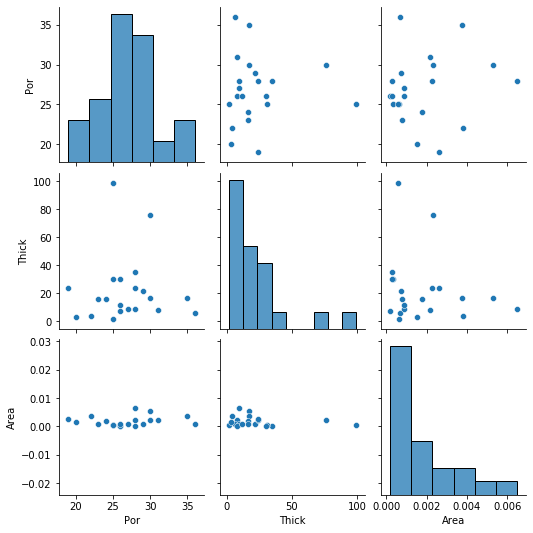

In [26]:
sns.pairplot(df,vars=features,markers='o')

#### Set Model Parameters

Determine the grid specifications

* note, I have updated to a region aroudn the available wells

* the original provided grid specification is include and commented out 

In [28]:

# Subset
Xmin = -93; Xmax = -89 # large
Ymin = 26; Ymax = 28
# xmin = -91.5; xmax = -91.37 # resevoir 170
# ymin = 26.15; ymax = 26.25
# xmin = -92.1; xmax = -91.2 # multiple reservoirs
# ymin = 25.8; ymax = 26.7
nx = 100; ny = 100
xsiz = (xmax-xmin)/nx; ysiz = (ymax-ymin)/ny
xmn = xmin + xsiz*0.5; ymn = ymin + ysiz*0.5
xext = Xmax-Xmin; yext = Ymax-Ymin
xx, yy = np.meshgrid(np.arange(xmn, xmax, xsiz), np.arange(ymax-ysiz*0.5, ymin, -1 * ysiz))


print('Grid extents: ' + str(xext) + ' x ' + str(yext))
print('X: nx - ' + str(nx) + ' , xmn - ' + str(xmn) + ' , xsiz - ' + str(xsiz))
print('Y: ny - ' + str(ny) + ' , ymn - ' + str(ymn) + ' , ysiz - ' + str(ysiz))

Grid extents: 4 x 2
X: nx - 100 , xmn - -92.98 , xsiz - 0.04
Y: ny - 100 , ymn - 26.01 , ysiz - 0.02


#### Calculate the Isochore Thickness

Now let's calculate the isochore thickness of the lower unit for further volumetric analysis.

  Estimated   10000 blocks 
      average   44.13302357303243  variance  2655.668969417514


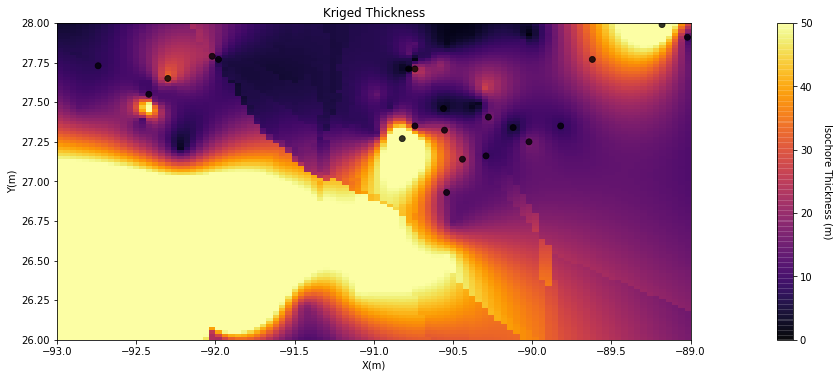

In [29]:
ktype = 1                                  # kriging type, 0 - simple, 1 - ordinary
radius = 100                               # search radius for neighbouring data
nxdis = 1; nydis = 1                       # number of grid discretizations for block kriging (not tested)
ndmin = 0; ndmax = 40                      # minimum and maximum data for an estimate
tmin = -1.0e21; tmax = 1.0e21              # minimum property value - no trimming limits

trend_vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=3.0,hmin1=3.0) # porosity variogram

thick_trend_kmap, _ = geostats.kb2d(df_centroids,'X','Y','Thick',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
    ndmin,ndmax,radius,ktype,-9999,trend_vario)

plt.subplot(111)
locpix_st(thick_trend_kmap,Xmin,Xmax,Ymin,Ymax,xsiz,0.0,50.0,df,'X','Y','X','Kriged Thickness','X(m)','Y(m)','Isochore Thickness (m)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=4.0, top=1.1, wspace=0.3, hspace=0.2)
plt.show()

#### Let's Build a Thickness Uncertainty Model 

We will perturb the lower and upper surfaces to build isochore thicknesss realizations. We account for two types of error.

* **local error** - local fluctuations in the top and base surfaces due to local interpretation uncertainty.

* **global error** - global shifts in the top and base surfaces due to velocity model error and interpretatin error.

Let's first look at the distribution of thickness.

* Future work will include callibration of uncertainty with seimic information

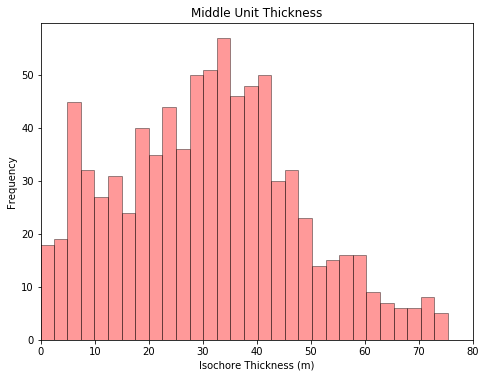

In [53]:
plt.subplot(111)
plt.hist(thick_kmap.flatten(),bins=30,color='red',edgecolor='black',alpha=0.4)
plt.xlabel('Isochore Thickness (m)');plt.title(unit + ' Unit Thickness');plt.ylabel('Frequency'); plt.xlim([0,80])

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.3, hspace=0.2)
plt.show()

#### Calculate a Depth Error Kriging Variance Map

Use this to constrain the depth uncertainty model to honor local well data

* we assume no error in surfaces at the data locations

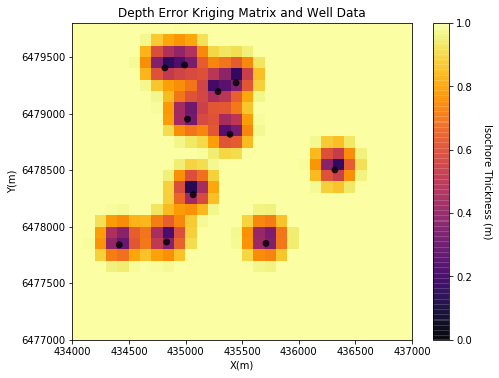

In [54]:
_, error_depth_vmap = kb2d(df,'X','Y','dummy',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,base_depth_mean,depth_vario)
plt.subplot(111)
locpix_st(error_depth_vmap,Xmin,Xmax,Ymin,Ymax,xsiz,0.0,1.0,df,'X','Y','dummy','Depth Error Kriging Matrix and Well Data','X(m)','Y(m)','Isochore Thickness (m)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.3, hspace=0.2)
plt.show()

#### Calculate Thickness Realizations

We calculate thickness realizations by:
    
1. simulating local residual error surfaces for top and base
2. adding a global shift
2. constraining the local residual error surfaces, for zero error at the well locations

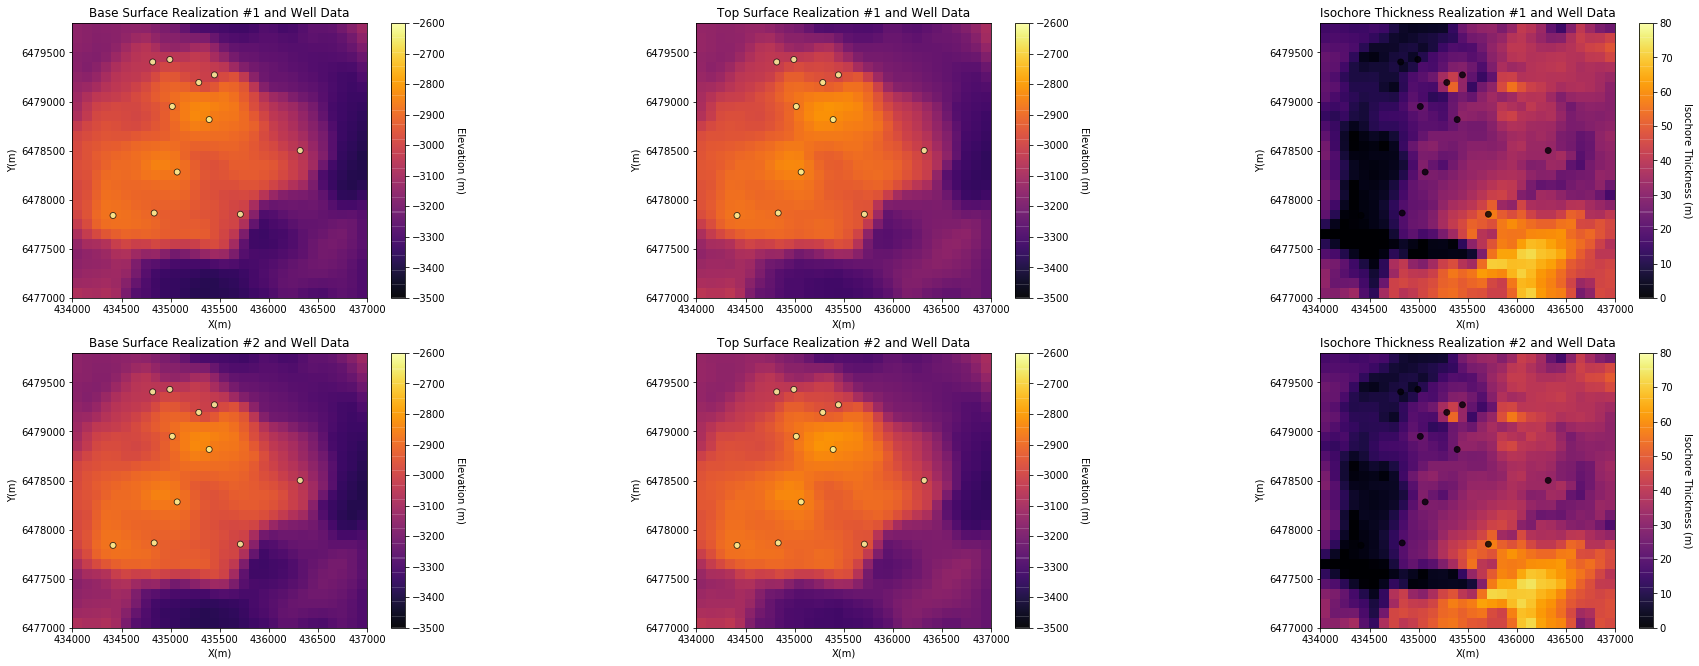

In [57]:
iref = 1; cref = 0; depth_local_std = 1.0; depth_global_std = 1.0; ktype = 0; corr = 0.0; trend_model = None

df_depth_error_ref = pd.DataFrame({'Error':np.random.normal(loc=0,scale = depth_local_std,size = nreal),'Null':np.zeros(nreal)})

top_shift_real = np.random.normal(loc=0,scale = depth_global_std,size = nreal)
base_shift_real = np.random.normal(loc=0,scale = depth_global_std,size = nreal)

top_surface_delta = np.zeros([ny,nx,nreal])
base_surface_delta = np.zeros([ny,nx,nreal])
thick_real = np.zeros([ny,nx,nreal])

for ireal in range(0,nreal):
    top_surface_delta[:,:,ireal] = sgsim(1,df,'X','Y','dummy',iref,df_depth_error_ref,cref,
              nx,xmn,xsiz,ny,ymn,ysiz,13013,depth_vario,ktype,corr,
              trend_model,'simtemp.out')
    top_surface_delta[:,:,ireal] = (top_surface_delta[:,:,ireal] + top_shift_real[ireal])*error_depth_vmap
    base_surface_delta[:,:,ireal] = sgsim(1,df,'X','Y','dummy',iref,df_depth_error_ref,cref,
              nx,xmn,xsiz,ny,ymn,ysiz,13013,depth_vario,ktype,corr,
              trend_model,'simtemp.out')
    base_surface_delta[:,:,ireal] = (base_surface_delta[:,:,ireal] + base_shift_real[ireal])*error_depth_vmap
    thick_real[:,:,ireal] = (top_depth_kmap+top_surface_delta[:,:,ireal]) - (base_depth_kmap+base_surface_delta[:,:,ireal]) 

thick_real[thick_real < 0] = 0              # truncate negative thicknesses 
   
plt.subplot(231)
locpix_st(base_depth_kmap+base_surface_delta[:,:,0],Xmin,Xmax,Ymin,Ymax,xsiz,depth_min,depth_max,df,'X','Y','dummy','Base Surface Realization #1 and Well Data','X(m)','Y(m)','Elevation (m)',cmap)

plt.subplot(232)
locpix_st(top_depth_kmap+top_surface_delta[:,:,0],Xmin,Xmax,Ymin,Ymax,xsiz,depth_min,depth_max,df,'X','Y','dummy','Top Surface Realization #1 and Well Data','X(m)','Y(m)','Elevation (m)',cmap)

plt.subplot(233)
locpix_st(thick_real[:,:,0],Xmin,Xmax,Ymin,Ymax,xsiz,0.0,80.0,df,'X','Y','dummy','Isochore Thickness Realization #1 and Well Data','X(m)','Y(m)','Isochore Thickness (m)',cmap)
 
plt.subplot(234)
locpix_st(base_depth_kmap+base_surface_delta[:,:,1],Xmin,Xmax,Ymin,Ymax,xsiz,depth_min,depth_max,df,'X','Y','dummy','Base Surface Realization #2 and Well Data','X(m)','Y(m)','Elevation (m)',cmap)

plt.subplot(235)
locpix_st(top_depth_kmap+top_surface_delta[:,:,1],Xmin,Xmax,Ymin,Ymax,xsiz,depth_min,depth_max,df,'X','Y','dummy','Top Surface Realization #2 and Well Data','X(m)','Y(m)','Elevation (m)',cmap)

plt.subplot(236)
locpix_st(thick_real[:,:,1],Xmin,Xmax,Ymin,Ymax,xsiz,0.0,80.0,df,'X','Y','dummy','Isochore Thickness Realization #2 and Well Data','X(m)','Y(m)','Isochore Thickness (m)',cmap)
    
plt.subplots_adjust(left=0.0, bottom=0.0, right=4.0, top=2.1, wspace=0.3, hspace=0.2)
plt.show()    

#### Summarize Thickness Uncertainty

Let's summarize the thickness uncertainty with:

* local e-type maps, the local expected value over the realizations
* local standard deviations, the local standard deviation over the realizations

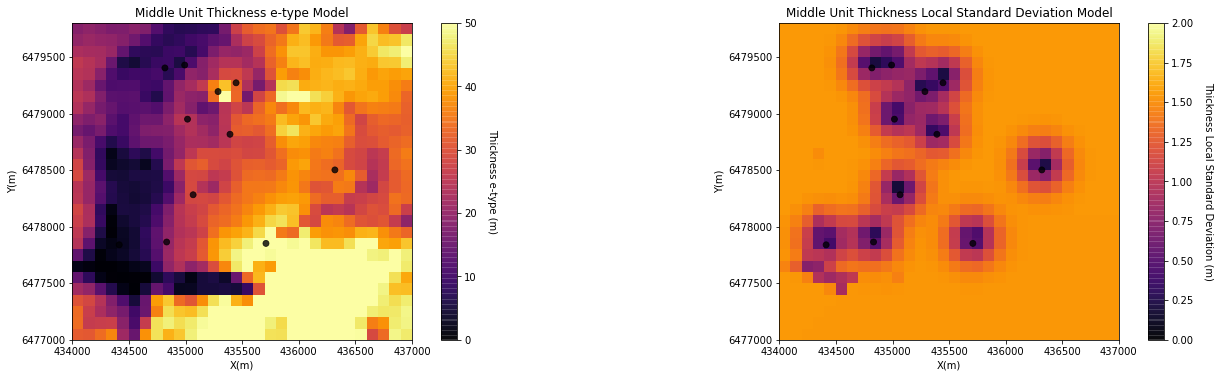

In [362]:
thick_e_type = local_expectation(thick_real)
thick_local_stdev = local_standard_deviation(thick_real)

plt.subplot(1,2,1)
locpix_st(thick_e_type,Xmin,Xmax,Ymin,Ymax,xsiz,0,50.0,df,'X','Y',features[i],unit + ' Unit Thickness e-type Model','X(m)','Y(m)','Thickness e-type (m)',cmap)

plt.subplot(1,2,2)
locpix_st(thick_local_stdev,Xmin,Xmax,Ymin,Ymax,xsiz,0,2.0,df,'X','Y','dummy',unit + ' Unit Thickness Local Standard Deviation Model','X(m)','Y(m)','Thickness Local Standard Deviation (m)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.1, wspace=0.2, hspace=0.2)
plt.show() 

#### Visualize the Well Data Uncertainty

Let's look at the expectation, P10 and P90 for all wells as location maps

* while the workflow is currently limited to PHI, we look at all features here

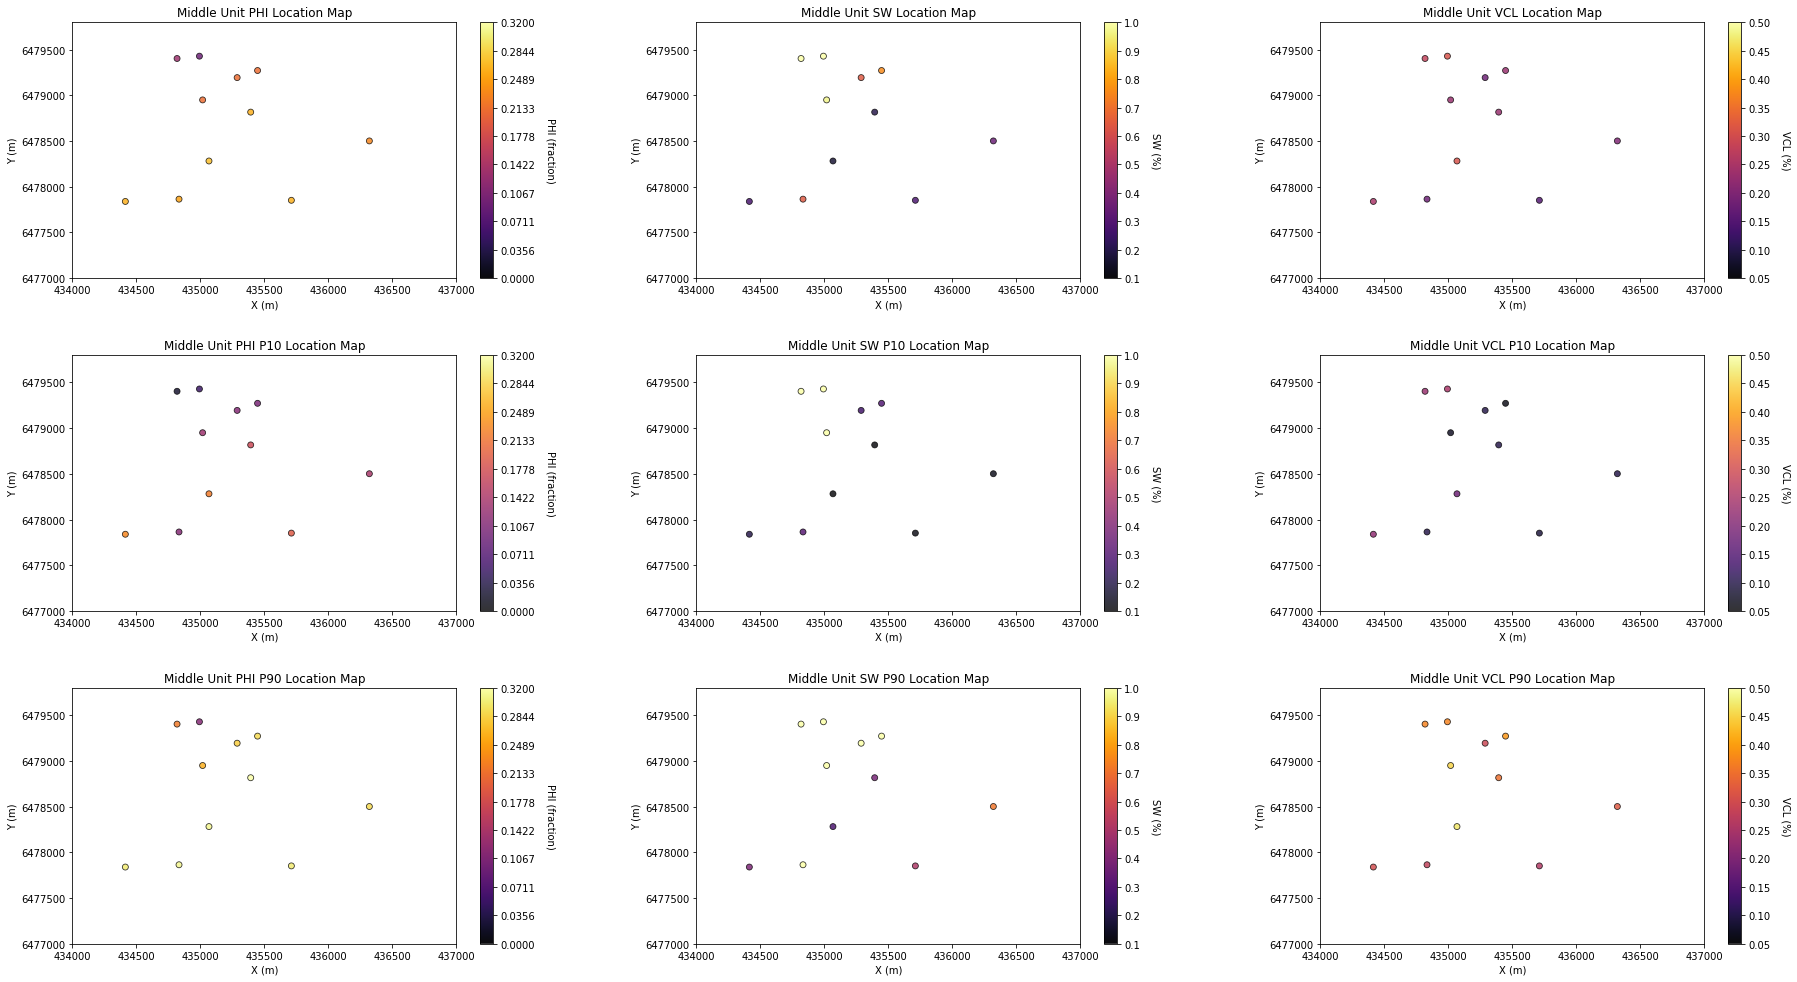

In [59]:
for i in range(0,3):
    plt.subplot(3,3,i+1)
    GSLIB.locmap_st(df,'X','Y',features[i],Xmin,Xmax,Ymin,Ymax,fmin[i],fmax[i],unit + ' Unit ' + features[i] + ' Location Map','X (m)','Y (m)', features[i] + ' (' + units[i] + ')',cmap)

for i in range(0,3):
    plt.subplot(3,3,i+4)
    GSLIB.locmap_st(df,'X','Y',features[i]+'10',Xmin,Xmax,Ymin,Ymax,fmin[i],fmax[i],unit + ' Unit ' + features[i] + ' P10 Location Map','X (m)','Y (m)', features[i] + ' (' + units[i] + ')',cmap)

for i in range(0,3):
    plt.subplot(3,3,i+7)
    GSLIB.locmap_st(df,'X','Y',features[i]+'90',Xmin,Xmax,Ymin,Ymax,fmin[i],fmax[i],unit + ' Unit ' + features[i] + ' P90 Location Map','X (m)','Y (m)', features[i] + ' (' + units[i] + ')',cmap)
  
plt.subplots_adjust(left=0.0, bottom=0.0, right=4.0, top=3.2, wspace=0.3, hspace=0.3)
plt.show()

#### Declustering

We check for and correct for spatial data clustering. The declustering parameters are:

* **df** - DataFrame with the spatial dataset
* **xcol** - column with the x coordinate
* **ycol** - column with the y coordinate
* **vcol** - column with the feature value
* **iminmax** - if 1 use the cell size that minimizes the declustered mean, if 0 the cell size that maximizes the declustered mean
* **noff** - number of cell mesh offsets to average the declustered weights over
* **ncell** - number of cell sizes to consider (between the **cmin** and **cmax**)
* **cmin** - minimum cell size
* **cmax** - maximum cell size

We will run a very wide range of cell sizes, from 10m to 2,000m ('cmin' and 'cmax') and take the cell size that minimizes the declustered mean ('iminmax' = 1 minimize, and = 0 maximize). Multiple offsets (number of these is 'noff') uses multiple grid origins and averages the results to remove sensitivity to grid position.  The ncell is the number of cell sizes.

The output from this program is:

* **wts** - an array with the weigths for each data (they sum to the number of data, 1 indicates nominal weight)
* **cell_sizes** - an array with the considered cell sizes
* **dmeans** - an array with the declustered mean for each of the **cell_sizes**

The **wts** are the declustering weights for the selected (minimizing or maximizing cell size) and the **cell_sizes** and **dmeans** are plotted to build the diagnostic declustered mean vs. cell size plot (see below).

In [61]:
wts, cell_sizes, dmeans = geostats.declus(df,'X','Y','PHI',iminmax = 1, noff= 20, ncell=100,cmin=1,cmax=10000)
df['Wts'] = wts                            # add weights to the sample data DataFrame
df.head()                                  # preview to check the sample data DataFrame

There are 11 data with:
   mean of      0.2163636363636364 
   min and max  0.09 and 0.27
   standard dev 0.055148185047647645 


,level_0,index,Well Name,X,Y,PHI,PHI10,PHI90,SW,SW10,SW90,VCL,VCL10,VCL90,dummy,Wts
0,0,11,15/09-F-01,434992.03,6479428.5,0.09,0.05,0.11,1.00,1.00,1.0,0.31,0.25,0.37,0.0,0.998958
1,1,12,15/09-F-01A,434817.28,6479403.0,0.13,0.02,0.22,1.00,1.00,1.0,0.28,0.23,0.37,0.0,1.113542
2,2,13,15/09-F-01B,435446.19,6479271.5,0.21,0.10,0.29,0.76,0.29,1.0,0.23,0.06,0.39,0.0,1.033333
3,3,14,15/09-F-01C,435017.00,6478950.0,0.21,0.13,0.26,0.97,1.00,1.0,0.23,0.07,0.45,0.0,0.930208
4,4,17,15/09-F-11A,435286.75,6479194.0,0.21,0.11,0.28,0.64,0.26,1.0,0.18,0.10,0.29,0.0,0.930208


##### Declustering Diagnostic Plot

Let's check the declustering diagnostic plot.

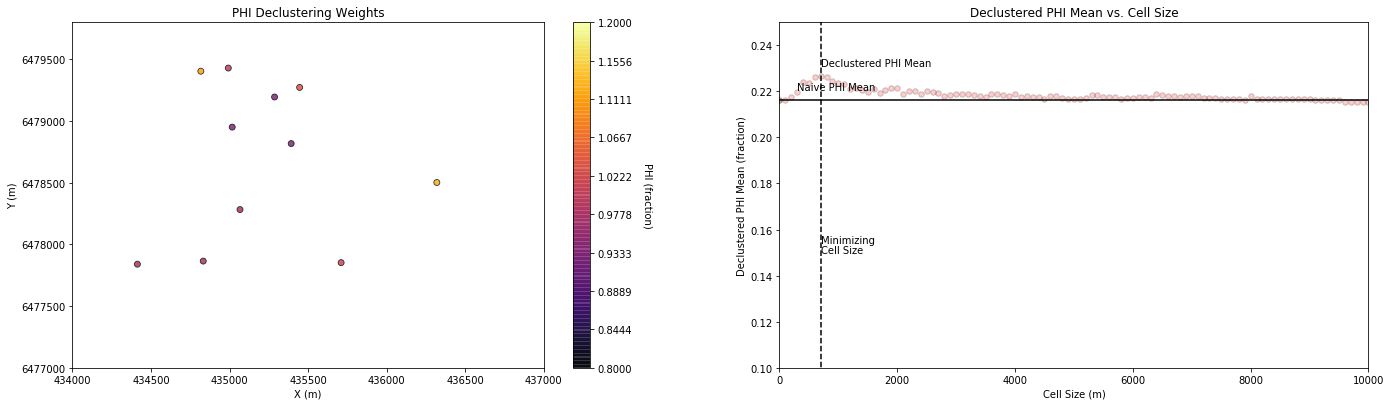

The original PHI mean is 0.22 and the declustered mean is 0.226
Error in the mean due to sampling bias is -4.47%


In [64]:
i = 0
cell_size = cell_sizes[np.argmax(dmeans)]
dmean = np.max(dmeans)

plt.subplot(121)
GSLIB.locmap_st(df,'X','Y','Wts',Xmin,Xmax,Ymin,Ymax,0.8,1.2,features[i] + ' Declustering Weights','X (m)','Y (m)', features[i] + ' (' + units[i] + ')',cmap)

plt.subplot(122)
plt.scatter(cell_sizes,dmeans, s=30, alpha = 0.2, edgecolors = "black", facecolors = 'red')
plt.xlabel('Cell Size (m)')
plt.ylabel('Declustered ' + features[0] + ' Mean (' + units[0] + ')')
plt.title('Declustered ' + features[0] + ' Mean vs. Cell Size')
plt.plot([0,10000],[naive_means[0],naive_means[0]],color = 'black')
plt.plot([cell_size,cell_size],[0.0,0.5],color = 'black',linestyle='dashed')
plt.text(300., naive_means[0]*1.02, r'Naive ' + features[0] + ' Mean')
plt.text(cell_size*1.02, dmean*1.02, r'Declustered ' + features[0] + ' Mean')
plt.text(cell_size*1.02, 0.154, r'Minimizing')
plt.text(cell_size*1.02, 0.150, r'Cell Size')
plt.ylim(0.10,0.25)
plt.xlim(0,10000)
plt.subplots_adjust(left=0.0, bottom=0.0, right=3., top=1.2, wspace=0.2, hspace=0.2)
plt.show()

print('The original PHI mean is ' + str(np.round(np.average(df[features[i]].values),2)) + 
      ' and the declustered mean is ' + str(np.round(dmean,3)))
print('Error in the mean due to sampling bias is ' 
      + str(round((np.average(df[features[i]].values)-dmean)/dmean*100,2)) + '%')

wavg_PHI,wstd_PHI = weighted_avg_and_std(df[features[i]],df['Wts']) 

#### Model Feature Spatial Continuity

First we need to transform the data to standard normal for consistency with the simulation in 'Gaussian space'

In [65]:
df['NPHI'], tvPor, tnsPor = geostats.nscore(df, 'PHI') # nscore transform for all facies porosity 
df.head()

,level_0,index,Well Name,X,Y,PHI,PHI10,PHI90,SW,SW10,SW90,VCL,VCL10,VCL90,dummy,Wts,NPHI
0,0,11,15/09-F-01,434992.03,6479428.5,0.09,0.05,0.11,1.00,1.00,1.0,0.31,0.25,0.37,0.0,0.998958,-1.271276
1,1,12,15/09-F-01A,434817.28,6479403.0,0.13,0.02,0.22,1.00,1.00,1.0,0.28,0.23,0.37,0.0,1.113542,-1.096804
2,2,13,15/09-F-01B,435446.19,6479271.5,0.21,0.10,0.29,0.76,0.29,1.0,0.23,0.06,0.39,0.0,1.033333,-0.229884
3,3,14,15/09-F-01C,435017.00,6478950.0,0.21,0.13,0.26,0.97,1.00,1.0,0.23,0.07,0.45,0.0,0.930208,-0.229884
4,4,17,15/09-F-11A,435286.75,6479194.0,0.21,0.11,0.28,0.64,0.26,1.0,0.18,0.10,0.29,0.0,0.930208,-0.229884


Let's calculate the experimental variogram from the available well data

* with so few data, directional variograms are challenged

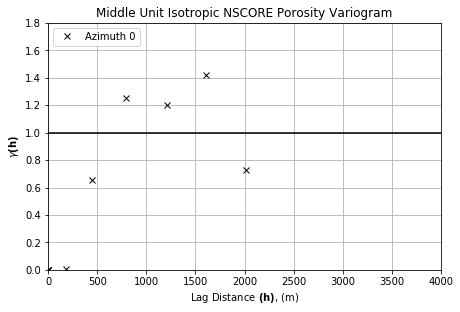

In [67]:
lag_dist = 400.0; lag_tol = 200.0; nlag = 8;            # maximum lag is 700m and tolerance > 1/2 lag distance for smoothing
bandh = 9999.9; atol = 90.0                             # no bandwidth, directional variograms
isill = 1                                               # standardize sill
azi_mat = [0,22.5,45,67.5,90,112.5,135,157.5]           # directions in azimuth to consider
azi_mat = [0]                                           # directions in azimuth to consider

# Arrays to store the results
lag = np.zeros((len(azi_mat),nlag+2)); gamma = np.zeros((len(azi_mat),nlag+2)); npp = np.zeros((len(azi_mat),nlag+2));

for iazi in range(0,len(azi_mat)):                      # Loop over all directions
    lag[iazi,:], gamma[iazi,:], npp[iazi,:] = geostats.gamv(df,"X","Y","NPHI",tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[iazi],atol,bandh,isill)
    plt.subplot(4,2,iazi+1)
    plt.plot(lag[iazi,:],gamma[iazi,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[iazi]))
    plt.plot([0,4000],[1.0,1.0],color = 'black')
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title(unit + ' Unit Isotropic NSCORE Porosity Variogram')
    plt.xlim([0,4000])
    plt.ylim([0,1.8])
    plt.legend(loc='upper left')
    plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=4.2, wspace=0.2, hspace=0.3)
plt.show()

 x,y,z offsets = 0.0,10.0


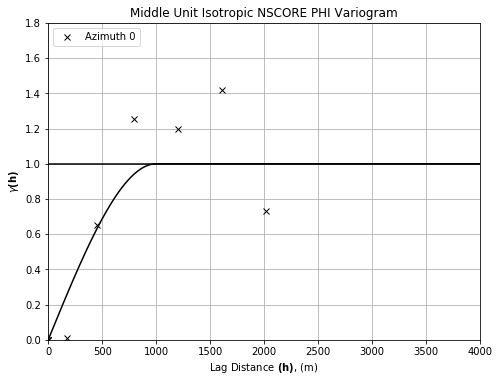

In [68]:
PHI_vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=1000,hmin1=1000) # porosity variogram
nlag = 400; xlag = 10; azm = 0.0;
index,h,gam,cov,ro = geostats.vmodel(nlag,xlag,azm,PHI_vario)
plt.subplot(111)
iazi = 0
plt.plot(lag[iazi,:],gamma[iazi,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[iazi]))
plt.plot(h,gam,color = 'black')
plt.plot([0,4000],[1.0,1.0],color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title(unit + ' Unit Isotropic NSCORE PHI Variogram')
plt.xlim([0,4000])
plt.ylim([0,1.8])
plt.legend(loc='upper left')
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.2, hspace=0.3)
plt.show()

#### Data Scale Up to Grid with Volume-Variance-based Variance Reduction Factor

Use gammabar to calculate the reduction in variance from point to model cell scale

* we rely on Krige's relation:

\begin{equation}
D^2(\cdot,V) = D^2(\cdot,v) + D^2(v,V)
\end{equation}

where $D^2(\cdot,V)$ is the $\sigma^2$, $D^2(\cdot,v)$ is the $\overline{\gamma}_{v,v}$ and $D^2(v,V)$ is the variance of cells (v) in the model. 

We calculate the gamma bar value, $\overline{\gamma}_{v,v}$ to solve for $D^2(v,V)$ for the standardize, variance of 1.0 case. Then we calculate a variance reduction factor as:

\begin{equation}
\frac{\sigma^2 - \overline{\gamma}_{v,v}}{\sigma^2} = \frac{D^2(v,V)}{\sigma^2}
\end{equation}

In [71]:
c0 = PHI_vario['nug'] + PHI_vario['cc1'] + PHI_vario['cc2']
gammabar = gammabar2d(100,100,PHI_vario)
variance_factor = (c0-gammabar)/c0
dvar = variance_factor * np.var(df['PHI'].values)
dstdev = math.sqrt(dvar)
print('Variance reduction factor = ' + str(round(variance_factor,4)) + '.')
print('Original variance = ' + str(round(np.var(df['PHI'].values),4)) + '.')
print('Scaled up variance = ' + str(round(dvar,4)) + ', and scaled up st. dev. = ' + str(round(dstdev,4)) + '.')

Variance reduction factor = 0.9361.
Original variance = 0.003.
Scaled up variance = 0.0028, and scaled up st. dev. = 0.0534.


#### Calculate the Effective Number of Data

This will all for convenient uncertainty calculation, like the uncertainty in the global distribution.

* with the effective number of data we can apply standard bootstrap instead of spatial bootstrap

In [72]:
nreal_neff = 1000
n_eff = n_effective(df,'X','Y',seed,nreal_neff,PHI_vario)
print('Number of effective data: ' + str(round(n_eff,2)) + ' of total number of data ' + str(ndata) + '.')

Number of effective data: 4.48 of total number of data 11.


#### Calculate a Reference Distribution

Now that we have the data and the declustering and volume-variance results, we fit a refence distribution

* representative by correcting for sampling bias

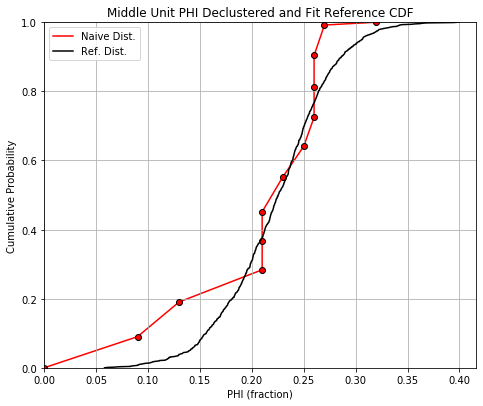

In [74]:
i = 0
var = np.zeros([ndata+2,2])
var[1:ndata+1,0] = df[features[i]]
var[1:ndata+1,1] = df['Wts']
var[0,0] = fmin[i]; var[ndata+1,0] = fmax[i]
var[ndata+1,1] = 1/ndata

var = var[np.argsort(var[:, 0])]

var[:,1] = var[:,1]/np.sum(var[:,1])
for idata in range(1, ndata+2):
    var[idata,1] = var[idata,1] + var[idata-1,1]

plt.subplot(111)
plt.plot(var[:,0],var[:,1],c='red',zorder=1,label='Naive Dist.')
plt.xlabel(features[i] + ' (' + units[i] + ')'); plt.xlim([fmin[i],fmax[i]]); plt.ylim([0.0,1.0])
plt.scatter(var[:,0],var[:,1],edgecolor='black',c='red',zorder = 2)
plt.ylabel('Cumulative Probability'); plt.title(unit + ' Unit ' + features[i] + ' Declustered and Fit Reference CDF'); 
plt.xlim([fmin[i],fmax[i]*1.3])
plt.grid(); 

nref = 1000
ref_dist = np.random.normal(loc=dmean,scale=dstdev,size=nref)
ref_dist.sort()
ref_pval = np.linspace(0.0,1.0,nref)
plt.plot(ref_dist,ref_pval,c='black',zorder=2,label='Ref. Dist.')
plt.legend(loc='upper left')

df_ref = pd.DataFrame({'X':np.full(nref,-9999),'Y':np.full(nref,-9999),'PHI':ref_dist})

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

#### Calculate Reference Distribution Uncertainty Model

We calculate multiple reference distributions by calculate the uncertainty in the distribution parameters, mean and standard deviation

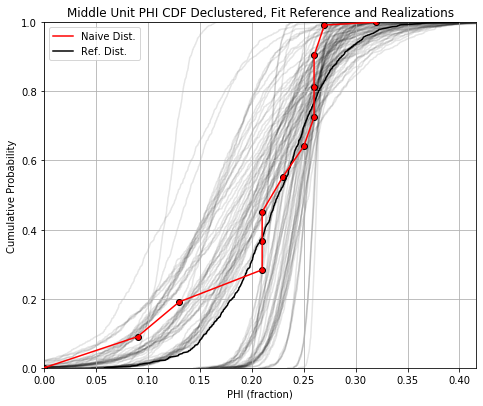

In [75]:
i = 0
for ireal in range(0,nreal):
    samples = random.choices(df['PHI'].values, weights=df['Wts'].values, cum_weights=None, k=int(n_eff))
    avg = np.average(samples)
    stdev = np.std(samples)
    ref = np.random.normal(loc=avg,scale=stdev,size=nref)
    ref.sort()
    df_ref[features[i] + 'real' + str(ireal+1)] = ref

plt.subplot(111)
plt.plot(var[:,0],var[:,1],c='red',zorder=3,label='Naive Dist.')
plt.xlabel(features[i] + ' (' + units[i] + ')'); plt.xlim([fmin[i],fmax[i]]); plt.ylim([0.0,1.0])
plt.scatter(var[:,0],var[:,1],edgecolor='black',c='red',zorder = 2)
plt.ylabel('Cumulative Probability'); plt.title(unit + ' Unit ' + features[i] + ' CDF Declustered, Fit Reference and Realizations'); 
plt.xlim([fmin[i],fmax[i]*1.3])
plt.grid(); 

plt.plot(ref_dist,ref_pval,c='black',zorder=2,label='Ref. Dist.')
plt.legend(loc='upper left')

for ireal in range(0,100):
    plt.plot(df_ref[features[i] + 'real' + str(ireal+1)].values,ref_pval,c='black',zorder=1,alpha = 0.1)    

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()
    

#### Fit a Simple Trend Model

Let's fit a simple, multilinear (planar) trend model

* we correct the trend to match the declustered mean from above

Previous trend mean: 0.23, and correction of -0.01.
Corrected trend model to declustered mean: 0.23
Original intercept: 361.07, updated intercept 361.07
Corrected trend mean: 0.233.


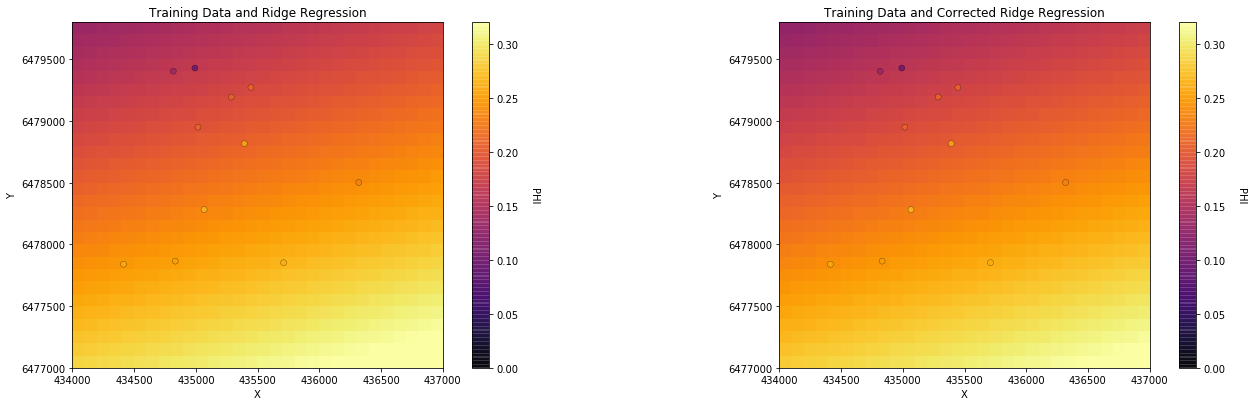

In [78]:
trend_alpha = 1000000                                                         # trend fit hyperparameter
ridge_trend = Ridge(alpha = trend_alpha)                                   # instantiate the prediction model
ridge_trend.fit(df.loc[:,['X','Y']],df['PHI'])              # train the model with the training data

csize = 100
plt.subplot(121)
trend_PHI = visualize_model(ridge_trend,df["X"],Xmin,Xmax,df["Y"],Ymin,Ymax,csize,df['PHI'],fmin[0],fmax[0],'Training Data and Ridge Regression')

original_trend_mean = np.average(trend_PHI.flatten())
trend_error = dmean - original_trend_mean
original_intercept = ridge_trend.intercept_
ridge_trend.intercept_ = ridge_trend.intercept_ + trend_error

print('Previous trend mean: ' + str(round(original_trend_mean,2)) + ', and correction of ' + str(round(trend_error,2)) + '.')
print('Corrected trend model to declustered mean: ' + str(round(dmean,2)))
print('Original intercept: ' + str(round(original_intercept,2)) + ', updated intercept ' + str(round(ridge_trend.intercept_,2)))

plt.subplot(122)
trend_PHI = visualize_model(ridge_trend,df["X"],Xmin,Xmax,df["Y"],Ymin,Ymax,csize,df['PHI'],fmin[0],fmax[0],'Training Data and Corrected Ridge Regression')

print('Corrected trend mean: ' + str(round(original_trend_mean,3)) + '.')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

##### Calculate the Trend and Residual at Well Data

We add the trend and residual values at the well locations

Declustered Porosity Data: Average 0.2152, Var 0.00309
Porosity Trend: Corrected Trend Average 0.2266, Var 0.00229

At Well Statistics:
Proportion Trend / Known:                     40.2%
Proportion Residual / Unknown:                38.2%
Proportion Covariance Trend and Residual      22.0%


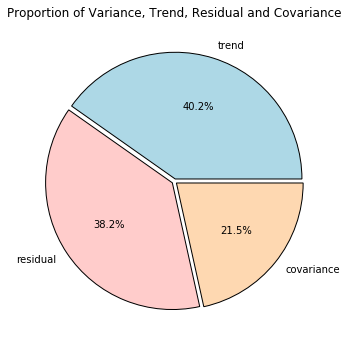

In [81]:
i = 0
df[features[i] + 'trend'] = ridge_trend.predict(df.loc[:,['X','Y']])
df[features[i] + 'resid'] = df[features[i]] - df[features[i] + 'trend']
df.head()

avg_PHI_trend = np.average(df[features[i] + 'trend'].values)
var_PHI_trend = np.var(df[features[i] + 'trend'].values)

avg_PHI_resid = np.average(df[features[i] + 'resid'].values)
var_PHI_resid = np.var(df[features[i] + 'resid'].values)

avg_PHI = np.average(df[features[i]].values)
var_PHI = np.var(df[features[i]].values)

wavg_PHI,wstd_PHI = weighted_avg_and_std(df[features[i]],df['Wts'])
wavg_PHI_trend,wstd_PHI_trend = weighted_avg_and_std(df[features[i]+'trend'],df['Wts'])
wavg_PHI_resid,wstd_PHI_resid = weighted_avg_and_std(df[features[i]+'resid'],df['Wts'])

print('Declustered Porosity Data: Average ' + str(round(wavg_PHI,4)) + ', Var ' + str(round(wstd_PHI**2,5)))
print('Porosity Trend: Corrected Trend Average ' + str(round(np.average(trend_PHI.flatten()),4)) + ', Var ' + str(round(np.var(trend_PHI.flatten()),5)))

prop_trend = wstd_PHI_trend**2/wstd_PHI**2
prop_resid = (wstd_PHI**2 - wstd_PHI_trend**2)/(wstd_PHI**2)
prop_resid = wstd_PHI_resid**2/wstd_PHI**2
prop_cov = (wstd_PHI**2 - wstd_PHI_trend**2 - wstd_PHI_resid**2)/wstd_PHI**2

print('\nAt Well Statistics:')
print('Proportion Trend / Known:                     ' + str(round(prop_trend*100,1)) + '%')
print('Proportion Residual / Unknown:                ' + str(round(prop_resid*100,1)) + '%')
print('Proportion Covariance Trend and Residual      ' + str(round(((wstd_PHI**2 - wstd_PHI_trend**2 - wstd_PHI_resid**2))/wstd_PHI**2,2)*100) + '%')

plt.subplot(111)                                      # results from the coin tosses 
plt.pie([prop_trend,prop_resid,prop_cov],labels = ['trend','residual','covariance'],radius = 1, autopct='%1.1f%%', colors = ['#add8e6','#ffcccb','#fed8b1'], explode = [.02,.02,.02], wedgeprops = {"edgecolor":"k",'linewidth': 1}  )
plt.title('Proportion of Variance, Trend, Residual and Covariance')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.2, hspace=0.3)
plt.show()

#### Trend Model Uncertainty

Let's apply machine learning model bagging to calculate multiple trend model realizations

* each is corrected for the declustered mean
* this provides an uncertainty model in trend extrapolation away from the data

First we will visualize a few realizations and then below we will calculate and store many

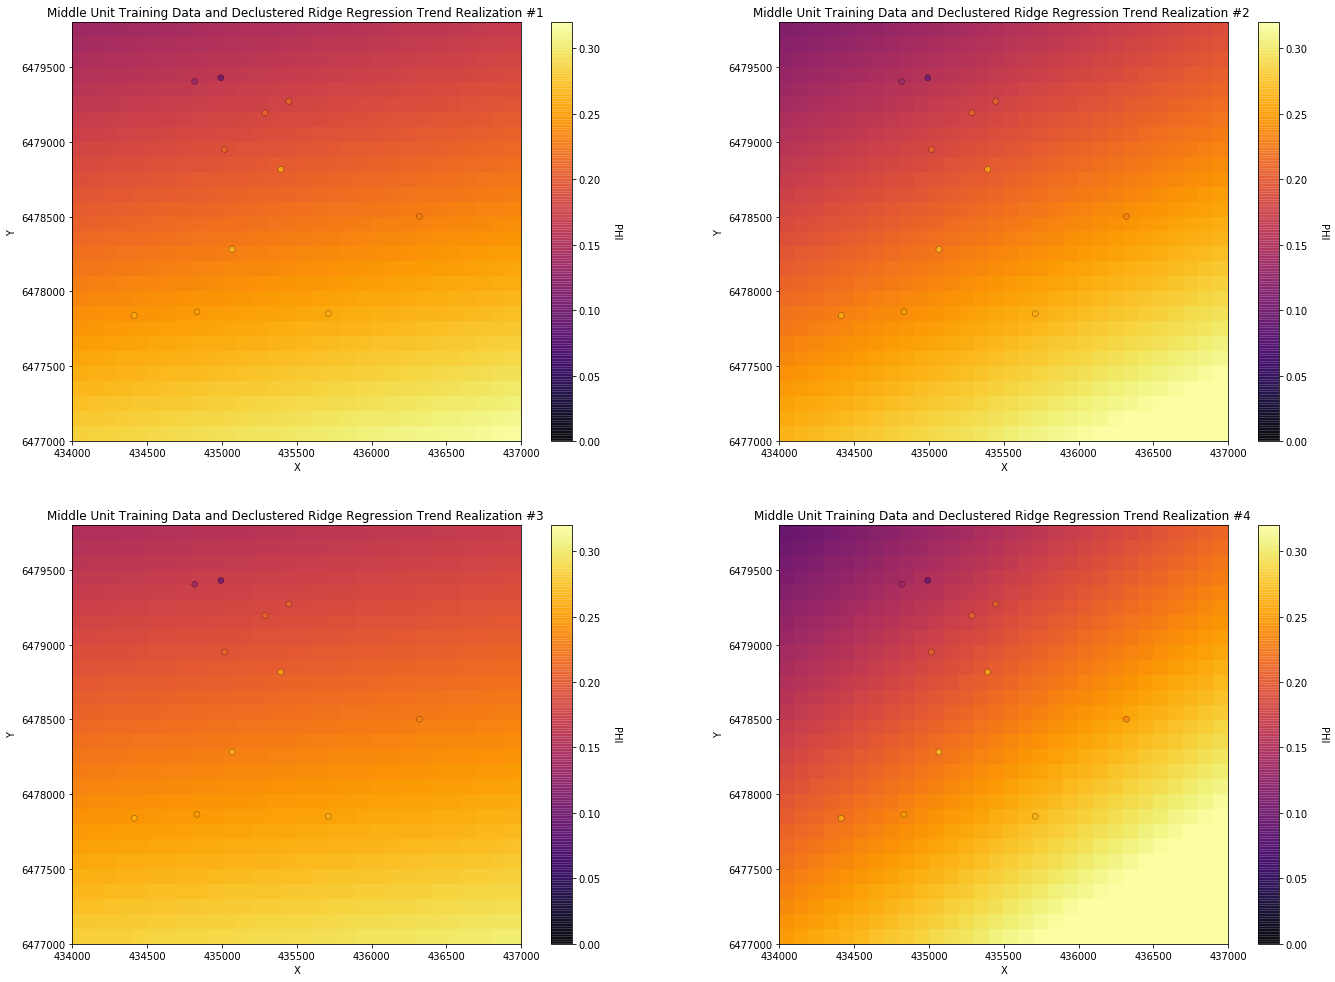

In [331]:
nreal_trend = 4
ridge_trend = Ridge(alpha = trend_alpha)                                   # instantiate the prediction model
                                                # use only a single tree for this demonstration
bagging_models = []
                                         # loop over random number seeds
for ireal in range(0,nreal_trend): 
    bagging_models.append(BaggingRegressor(base_estimator=ridge_trend, n_estimators=1, random_state=seed+ireal, n_jobs = 4))
    bagging_models[ireal].fit(X = df.loc[:,['X','Y']],y = df['PHI'])

    # Correct the bagged model mean to the declustered mean
    original_trend_mean = calculate_model_average(bagging_models[ireal],df["X"],Xmin,Xmax,df["Y"],Ymin,Ymax,csize,fmin[0],fmax[0])
    trend_error = dmean - original_trend_mean
    original_intercept = bagging_models[ireal].estimators_[0].intercept_
    bagging_models[ireal].estimators_[0].intercept_ = bagging_models[ireal].estimators_[0].intercept_ + trend_error    
    
    plt.subplot(2,2,ireal+1)
    visualize_model(bagging_models[ireal],df["X"],Xmin,Xmax,df["Y"],Ymin,Ymax,csize,df['PHI'],fmin[0],fmax[0],unit + ' Unit Training Data and Declustered Ridge Regression Trend Realization #' + str(ireal+1) + ' ')
    
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.2, wspace=0.2, hspace=0.2)

##### Calculate and Check the Trend Realization

Now we are ready to calculate and store many trend realizations in a 3D ndarray

We check the local expectation and standard deviation over the trend realizations

* indicates the local central tendency and degree of trend uncertainty 

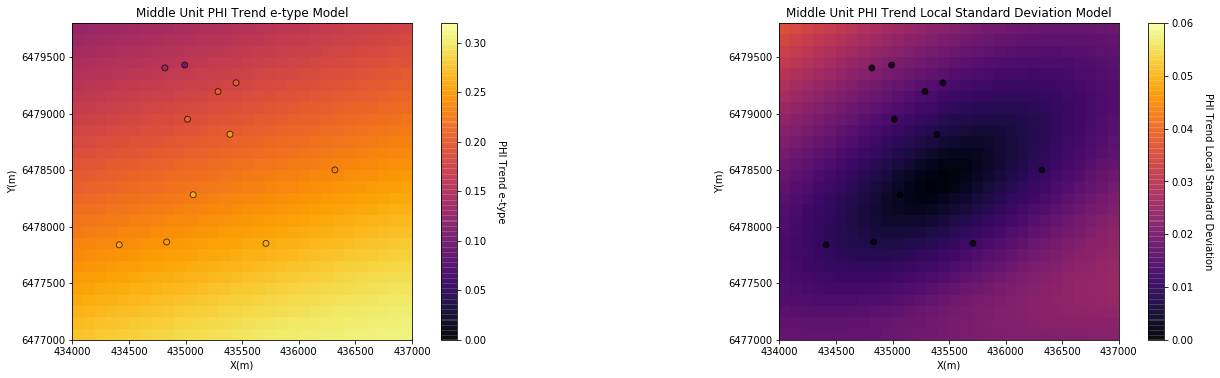

In [332]:
nreal_trend = 100
trend_PHI_real = np.zeros([ny,nx,nreal_trend])
                                         # loop over random number seeds
for ireal in range(0,nreal_trend): 
    bagging_model = BaggingRegressor(base_estimator=ridge_trend, n_estimators=1, random_state=seed+ireal, n_jobs = 4)
    bagging_model.fit(X = df.loc[:,['X','Y']],y = df['PHI'])

    # Correct the bagged model mean to the declustered mean
    original_trend_mean = calculate_model_average(bagging_model,df["X"],Xmin,Xmax,df["Y"],Ymin,Ymax,csize,fmin[0],fmax[0])
    trend_error = dmean - original_trend_mean
    original_intercept = bagging_model.estimators_[0].intercept_
    bagging_model.estimators_[0].intercept_ = bagging_model.estimators_[0].intercept_ + trend_error    
    
    trend_PHI_real[:,:,ireal] = calculate_model(bagging_model,df["X"],Xmin,Xmax,df["Y"],Ymin,Ymax,csize,fmin[0],fmax[0])
    
PHI_trend_e_type = local_expectation(trend_PHI_real)
PHI_trend_local_stdev = local_standard_deviation(trend_PHI_real)

plt.subplot(1,2,1)
locpix_st(PHI_trend_e_type,Xmin,Xmax,Ymin,Ymax,xsiz,fmin[i],fmax[i],df,'X','Y',features[i],unit + ' Unit PHI Trend e-type Model','X(m)','Y(m)','PHI Trend e-type',cmap)

plt.subplot(1,2,2)
locpix_st(PHI_trend_local_stdev,Xmin,Xmax,Ymin,Ymax,xsiz,0,0.06,df,'X','Y','dummy',unit + ' Unit PHI Trend Local Standard Deviation Model','X(m)','Y(m)','PHI Trend Local Standard Deviation',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.1, wspace=0.2, hspace=0.2)
plt.show() 

We apply realization post processing to visualize the local trend P10, P50 and P90.

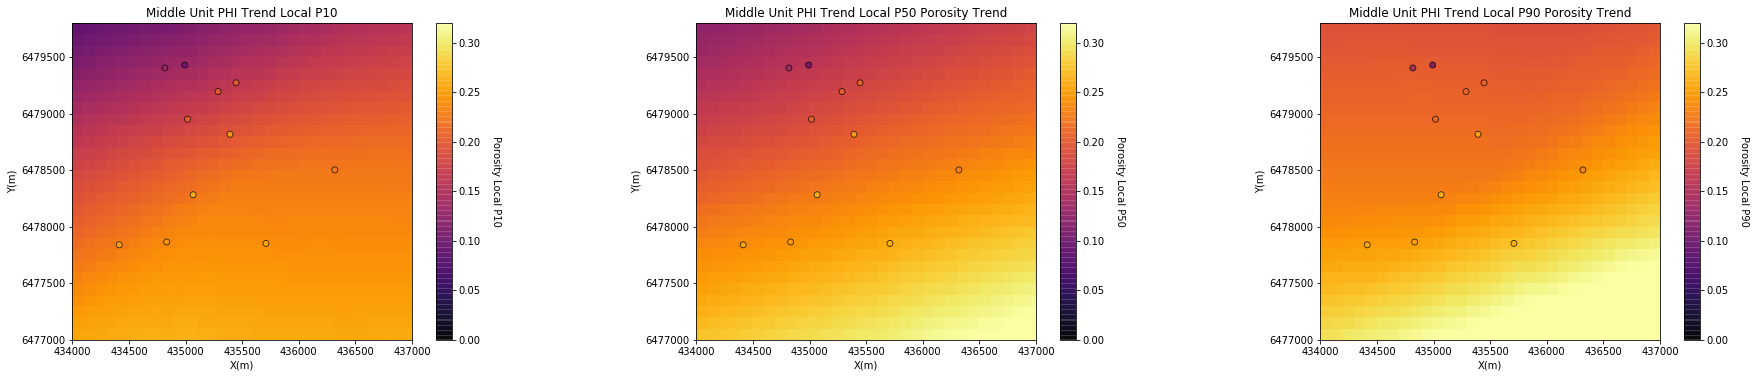

In [333]:
PHI_trend_localp10 = local_percentile(realizations = trend_PHI_real,p_value = 10)
PHI_trend_localp50 = local_percentile(realizations = trend_PHI_real,p_value = 50)
PHI_trend_localp90 = local_percentile(realizations = trend_PHI_real,p_value = 90)

i = 0
plt.subplot(1,3,1)
locpix_st(PHI_trend_localp10,Xmin,Xmax,Ymin,Ymax,xsiz,fmin[i],fmax[i],df,'X','Y',features[i],unit + ' Unit PHI Trend Local P10','X(m)','Y(m)','Porosity Local P10',cmap)

plt.subplot(1,3,2)
locpix_st(PHI_trend_localp50,Xmin,Xmax,Ymin,Ymax,xsiz,fmin[i],fmax[i],df,'X','Y',features[i],unit + ' Unit PHI Trend Local P50 Porosity Trend','X(m)','Y(m)','Porosity Local P50',cmap)

plt.subplot(1,3,3)
locpix_st(PHI_trend_localp90,Xmin,Xmax,Ymin,Ymax,xsiz,fmin[i],fmax[i],df,'X','Y',features[i],unit + ' Unit PHI Trend Local P90 Porosity Trend','X(m)','Y(m)','Porosity Local P90',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=4.0, top=1.1, wspace=0.3, hspace=0.2)
plt.show()

#### Calculate the Local Data Uncertainty Distributions

We calculate the local data uncertainty distributions 

* with the P10, expected value and P90 at each well location

* assume Gaussian distribution

In [89]:
for idata in range(0,ndata):
    for i in range(0,3):
        exp = df.loc[idata,features[i]]; P10 = df.loc[idata,features[i]+'10']; P90 = df.loc[idata,features[i]+'90'] 
        std = ((P90-exp)+(exp-P10))*0.5/1.3 # take average of difference and assume 1.3 standard deviations 
        df[features[i]+'std'] = std
df.head()

,level_0,index,Well Name,X,Y,PHI,PHI10,PHI90,SW,SW10,...,VCL10,VCL90,dummy,Wts,NPHI,PHItrend,PHIresid,PHIstd,SWstd,VCLstd
0,0,11,15/09-F-01,434992.03,6479428.5,0.09,0.05,0.11,1.00,1.00,...,0.25,0.37,0.0,0.998958,-1.271276,0.163728,-0.073728,0.057692,0.223077,0.084615
1,1,12,15/09-F-01A,434817.28,6479403.0,0.13,0.02,0.22,1.00,1.00,...,0.23,0.37,0.0,1.113542,-1.096804,0.162386,-0.032386,0.057692,0.223077,0.084615
2,2,13,15/09-F-01B,435446.19,6479271.5,0.21,0.10,0.29,0.76,0.29,...,0.06,0.39,0.0,1.033333,-0.229884,0.179890,0.030110,0.057692,0.223077,0.084615
3,3,14,15/09-F-01C,435017.00,6478950.0,0.21,0.13,0.26,0.97,1.00,...,0.07,0.45,0.0,0.930208,-0.229884,0.191292,0.018708,0.057692,0.223077,0.084615
4,4,17,15/09-F-11A,435286.75,6479194.0,0.21,0.11,0.28,0.64,0.26,...,0.10,0.29,0.0,0.930208,-0.229884,0.181745,0.028255,0.057692,0.223077,0.084615


#### Spatial Bootstrap Well  Data Realizations

We use LUSIM, geostatistical simulation with lower upper decomposition. This requires the following steps:

* build the covariance matrix

* lower upper composition

* simulate data realizations

##### Build the Covariance Matrix

This is the well data to well data spatial covariance matrix.

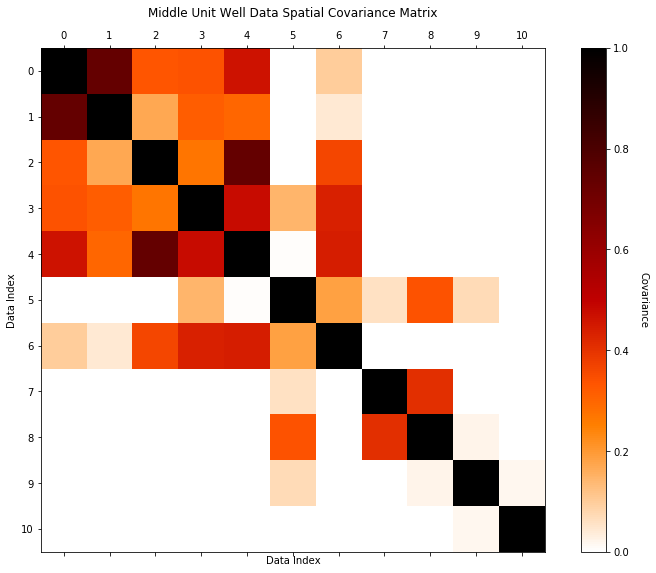

In [339]:
i = 0
cov = np.zeros((len(df),len(df)))                           # covarince matrix initialization
var_range = 300.0                                       # isotropic spherical variogram model range

for idata in range(0, len(df)):
    x1 = df.loc[idata,'X']; y1 = df.loc[idata,'Y']
    for jdata in range(0, len(df)):
        x2 = df.loc[jdata,'X']; y2 = df.loc[jdata,'Y']
        distance = math.sqrt(math.pow((x1-x2),2) + math.pow((y1-y2),2))
        cova = 0.0
        if distance <= 0.0:
            cov[idata,jdata] = 1.
        else:
            cov[idata,jdata] = cova2_simple(x1,y1,x2,y2,PHI_vario)

fig_size = 10
fig, ax = plt.subplots(figsize=(fig_size, fig_size))
im = ax.matshow(cov,vmin = 0.0, vmax = 1.0,cmap = plt.cm.gist_heat_r)
plt.xticks(range(len(df)), range(len(df)));
plt.yticks(range(len(df)), range(len(df)));
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label('Covariance', rotation=270, labelpad=20)
plt.xlabel('Data Index'); plt.ylabel('Data Index')
plt.title(unit + ' Unit Well Data Spatial Covariance Matrix')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.7, wspace=0.3, hspace=0.2)
plt.show()

##### Lower Upper (LU) Decomposition

Peform LU decomposition of the covariance matrix

* calculate the lower matrix $L$ from the covariance matrix.

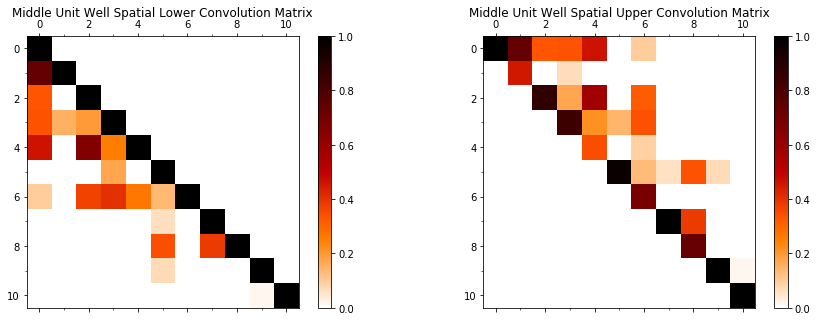

In [95]:
P, L, U = scipy.linalg.lu(cov)                          # LU decomposition of the covariance matrix

fig_size = 10
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(15, 5))
im = ax[0].matshow(L,vmin = 0.0, vmax = 1.0,cmap = plt.cm.gist_heat_r)
ax[0].set_xticks(range(len(df)), range(len(df)));
ax[0].set_yticks(range(len(df)), range(len(df)));
fig.colorbar(im, orientation = 'vertical',ax=ax[0])
ax[0].set_title(unit + ' Unit Well Spatial Lower Convolution Matrix')

im = ax[1].matshow(U,vmin = 0.0, vmax = 1.0,cmap = plt.cm.gist_heat_r)
ax[1].set_xticks(range(len(df)), range(len(df)));
ax[1].set_yticks(range(len(df)), range(len(df)));
fig.colorbar(im, orientation = 'vertical',ax=ax[1])
ax[1].set_title(unit + ' Unit Well Spatial Upper Convolution Matrix')
plt.show()

##### Simulate Data Realizations

We apply a random Gaussian vector to the lower matrix to sample data realizations

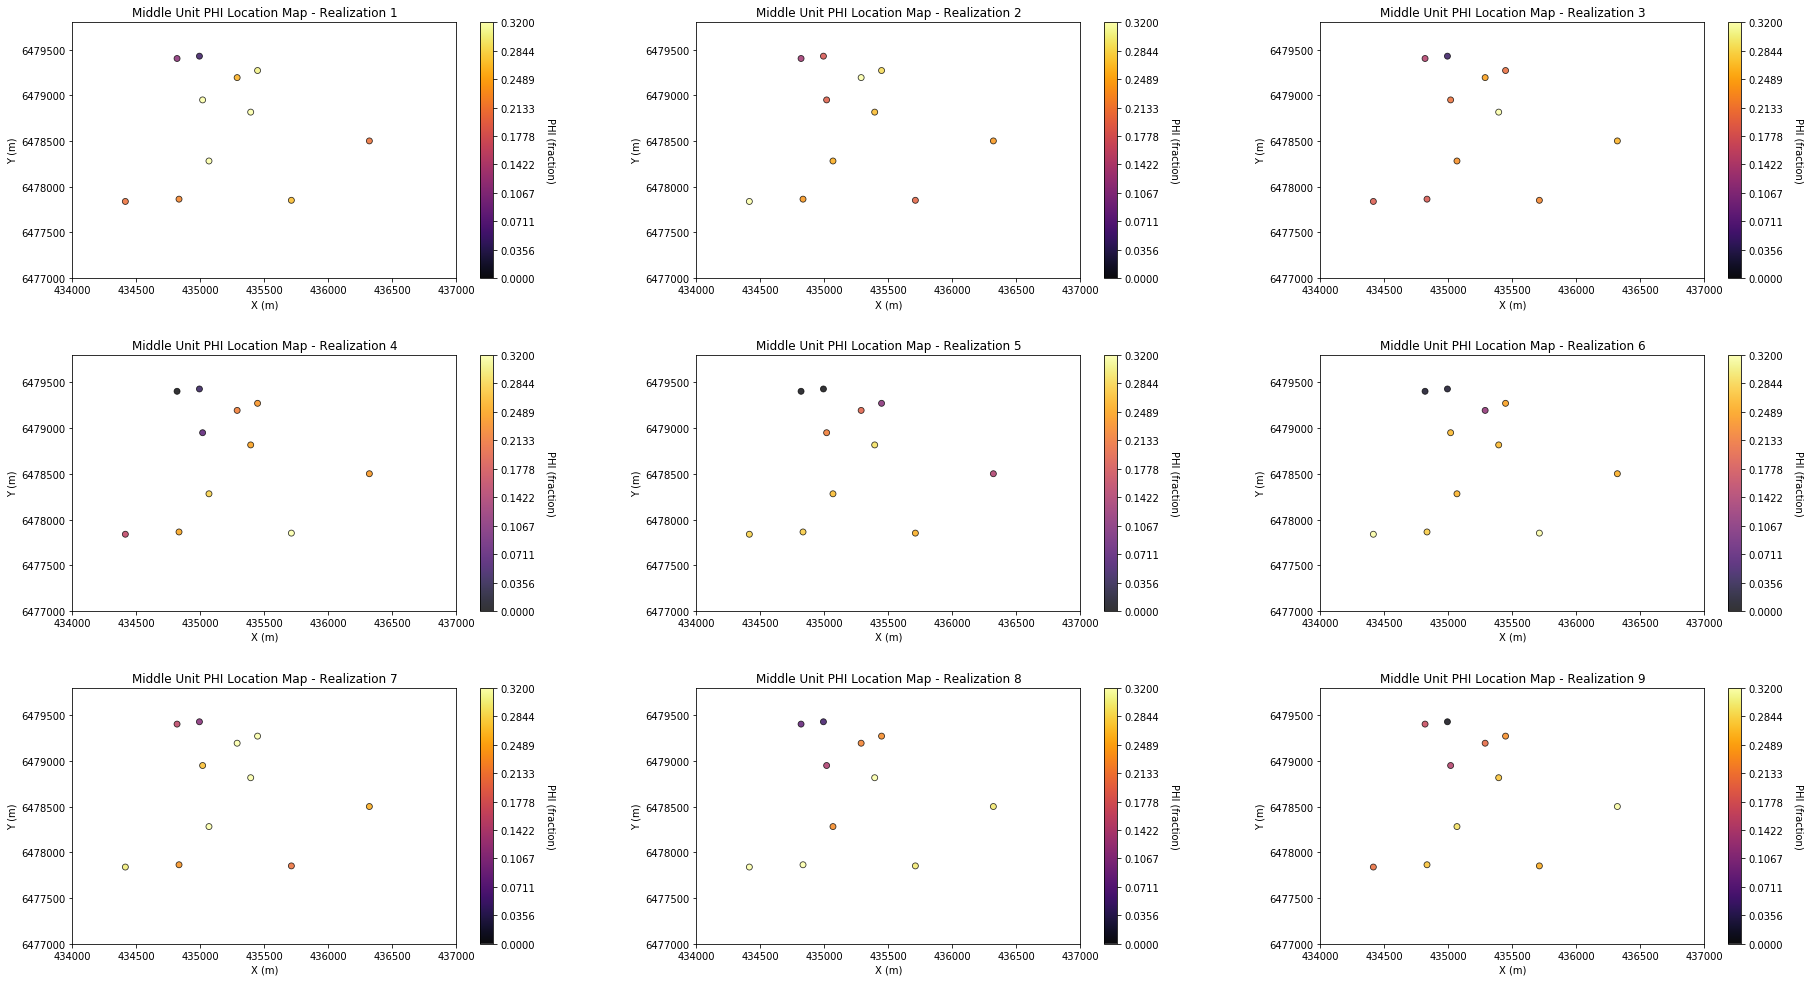

In [97]:
nreal = 100; nfeatures = 1                                                  # number of bootstrap realizations
spatial_bootstrap = np.zeros((ndata))               # array to store spatial bootstrap results
df_data = []

for i in range(0,nfeatures):                                        # loop over features
    for ireal in range(0, nreal):                           # loop over realizations  
        rand = np.random.normal(loc = 0.0, scale = 1.0, size = ndata) # random Gaussian values [ndata]
        realization = np.matmul(L,rand)                     # impose spatial correlation between the values                   
        pvalue = norm.cdf(realization)                      # calculate the p-values
        for idata in range(0,ndata):
            spatial_bootstrap[idata] = norm.ppf(pvalue[idata],loc=df.loc[idata,features[i]],
                                                        scale=df.loc[idata,features[i]+'std']) # backtransform ot feature values
            df[features[i]+'real'+str(ireal)] = spatial_bootstrap

i = 0
for ireal in range(0,9):
    plt.subplot(3,3,ireal+1)
    GSLIB.locmap_st(df,'X','Y',features[i] + 'real' + str(ireal+1),Xmin,Xmax,Ymin,Ymax,fmin[i],fmax[i],unit + ' Unit ' + features[i] + ' Location Map - Realization ' + str(ireal+1),'X (m)','Y (m)', features[i] + ' (' + units[i] + ')',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=4.0, top=3.2, wspace=0.3, hspace=0.3)
plt.show()

#### Stochastic Simulation

Now we put the entire workflow together with stochastic simulation. We integrate:

* **data uncertainty** - with spatial bootstrap realizations of the data
* **trend uncertainty** - with bagged trend model realizations
* **global data distribution uncertainty** - with bootstrap uncertainty for reference distribution parameters
* **spatial uncertainty** - with geostatistical simulated spatial realizations away from the wells
* **data representativity** - with declustering to correct the global distributions for spatial sampling bias

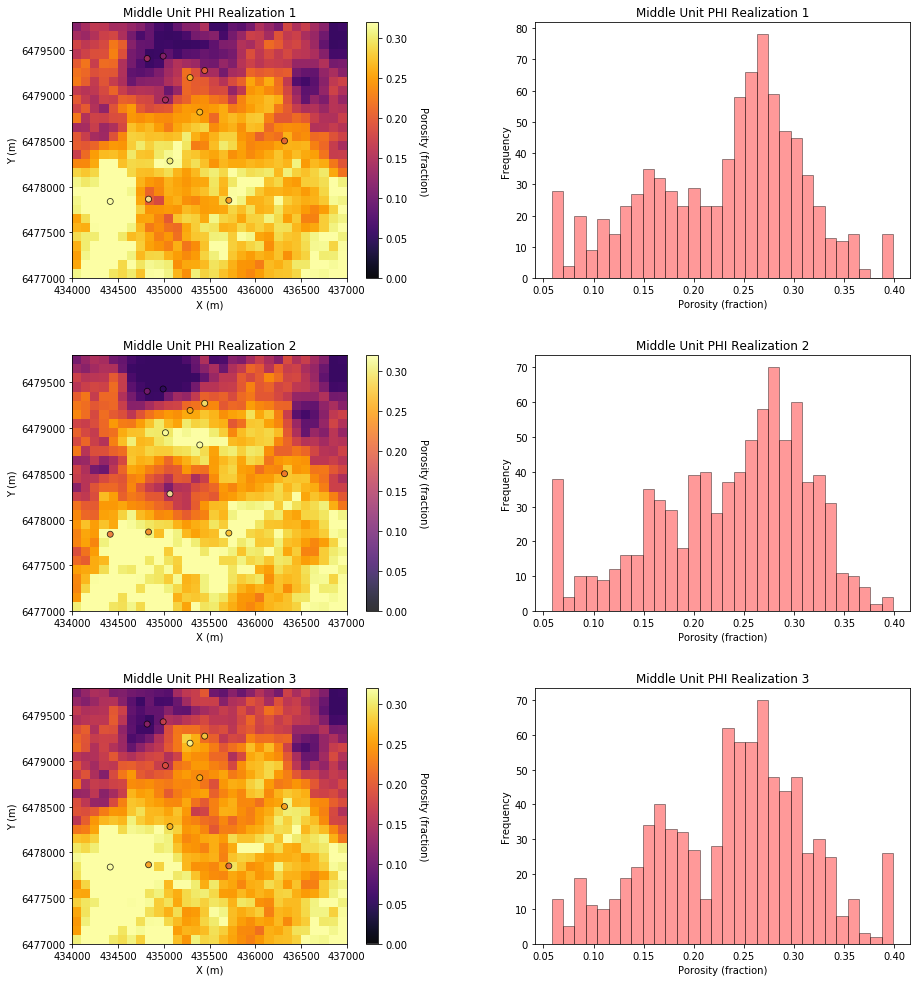

In [107]:
ireal = 0; i = 0; nreal_show = 3
ndmin = 0; ndmax = 10; nodmax = 10; mults = 1; nmult = 2; noct = -1; radius = 1000; sang1 = 0
tmin = -99999.9; tmax = 99999.9
sim_PHI = []; seed = 73073
i = 0
iref = 1; cref = 2
ktype = 2; corr = 0.0
sec_map = trend_PHI
sim_PHI = []

for ireal in range(0,nreal_show):
    sim_PHI.append(sgsim(1,df,'X','Y',features[i]+'real'+str(ireal),iref,df_ref,cref,
          nx,xmn,xsiz,ny,ymn,ysiz,seed,PHI_vario,ktype,corr,
          sec_map,'sim_temp.out'))
   
    plt.subplot(nreal_show,2,2*(ireal+1)-1)
    locpix_st(sim_PHI[ireal],Xmin,Xmax,Ymin,Ymax,xsiz,fmin[0],fmax[0],df,'X','Y',features[i]+'real'+str(ireal),
              unit + ' Unit ' + features[i] + ' Realization ' + str(ireal+1),'X (m)','Y (m)','Porosity (fraction)',cmap)
    plt.subplot(nreal_show,2,2*(ireal+1))    
    plt.hist(sim_PHI[ireal].flatten(),bins=30,color='red',edgecolor='black',alpha=0.4)
    plt.xlabel('Porosity (fraction)');plt.title(unit + ' Unit ' + features[i] + ' Realization '+str(ireal+1));plt.ylabel('Frequency')
    
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=3.2, wspace=0.3, hspace=0.3)
plt.show()   

Let's set up a convenient function to make realizations of OIP maps.

* booleans to activate any uncertainty source
* porosity 

In [347]:
nreal = 100
data_uncertainty = False
trend_uncertainty = False
dist_uncertainty = False
spatial_uncertainty = True

def run_realizations(data_uncertainty,trend_uncertainty,dist_uncertainty,spatial_uncertainty,nreal,data_select=np.full(len(df),True)):
    iref = 1; cref = 2
    ktype = 2; corr = 0.0
    realizations = np.zeros((ny,nx,nreal))
    for ireal in range(0,nreal):
        if spatial_uncertainty == True:
            real_seed = seed + ireal
        else: 
            real_seed = seed
            
        if trend_uncertainty == True:
            trend_model = trend_PHI_real[:,:,ireal]
        else:
            trend_model = trend_PHI
        
        if dist_uncertainty == True:
            cref = 2
            refdist = df_ref[['X','Y',features[i] + 'real' + str(ireal+1)]]
        else:
            cref = 2
            refdist = df_ref[['X','Y',features[i]]]
            
        if data_uncertainty == True:
            realizations[:,:,ireal] = sgsim(1,df[data_select],'X','Y',features[i]+'real'+str(ireal),iref,refdist,cref,
              nx,xmn,xsiz,ny,ymn,ysiz,real_seed,PHI_vario,ktype,corr,
              trend_model,'sim_temp.out')
        else: 
            realizations[:,:,ireal] = sgsim(1,df[data_select],'X','Y',features[i],iref,refdist,cref,
              nx,xmn,xsiz,ny,ymn,ysiz,real_seed,PHI_vario,ktype,corr,
              trend_model,'sim'+str(ireal)+'temp.out')
            # convert to barrels = PHI * So * Volume of Column * bbls / m^3
        thick_real[thick_real < 0] = 0
        
    realizations[realizations < por_thresh] = 0 # remove low porosity as high water saturation
        
    for ireal in range(0,nreal):
        realizations[:,:,ireal] = realizations[:,:,ireal]*so*thick_real[:,:,ireal]*xsiz*ysiz*6.28981
    return realizations
    
realizations = run_realizations(data_uncertainty,trend_uncertainty,dist_uncertainty,spatial_uncertainty,nreal)

Let's preview some of the realizations.

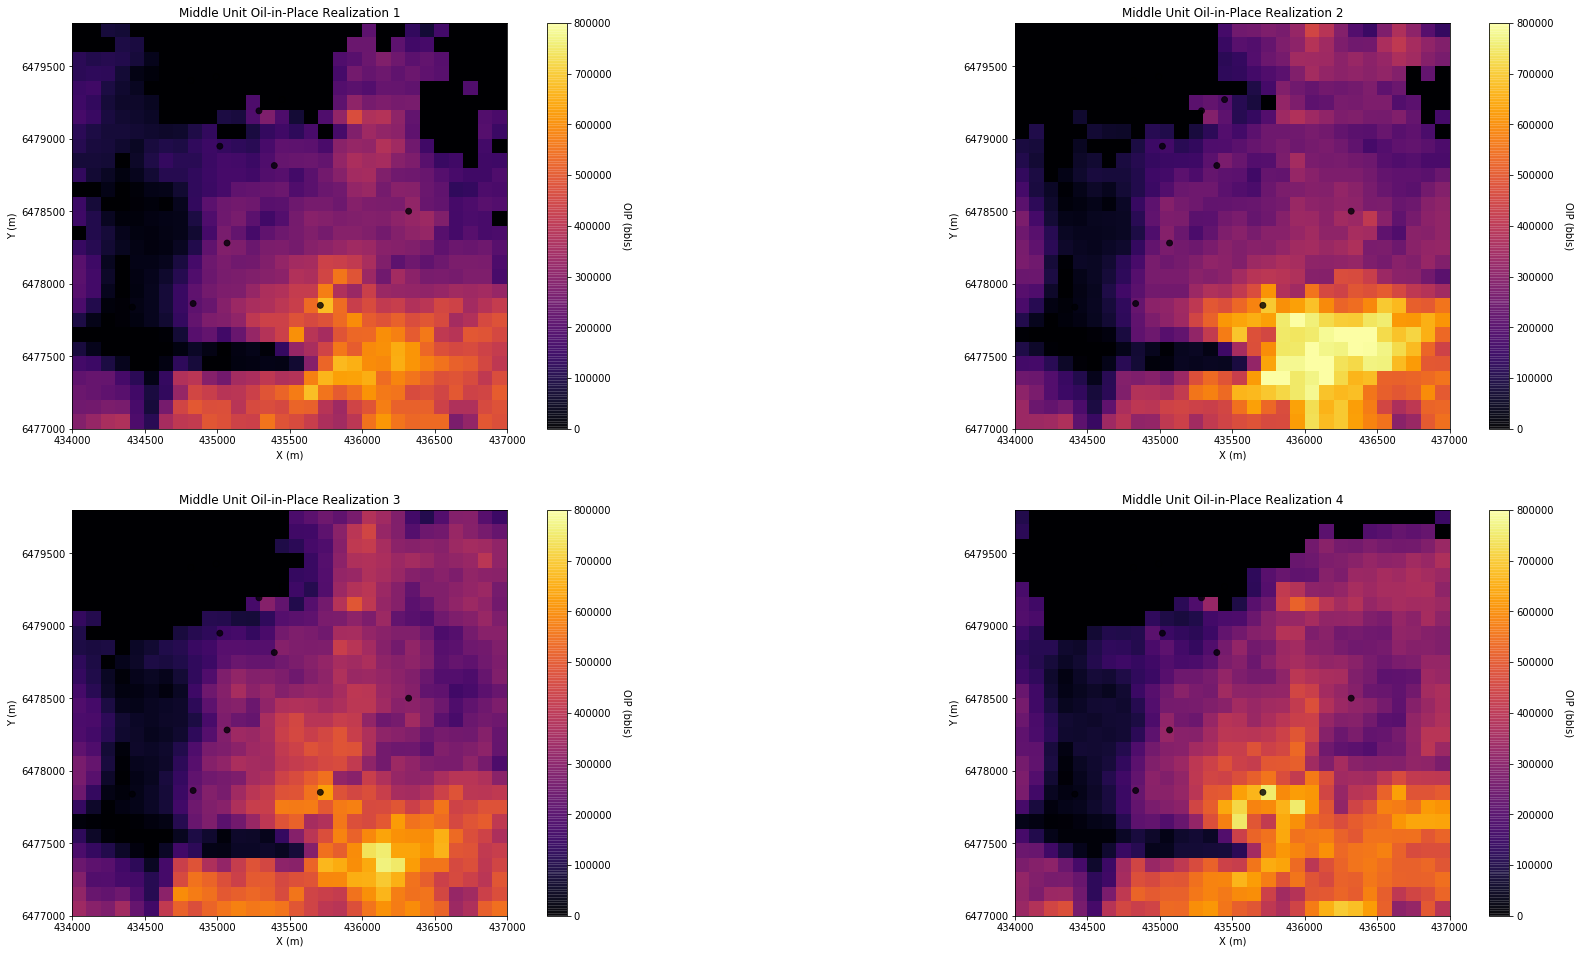

In [352]:
i = 0; nreal_show = 4
for ireal in range(0,nreal_show):
    plt.subplot(int(nreal_show/2),2,ireal + 1)
    if data_uncertainty == True:
        locpix_st(realizations[:,:,ireal],Xmin,Xmax,Ymin,Ymax,xsiz,oip_min,oip_max,df,'X','Y',features[i]+'real'+str(ireal),
              unit + ' Unit Oil-in_Place Realization ' + str(ireal+1),'X (m)','Y (m)','OIP (bbls)',cmap)
    else:
        locpix_st(realizations[:,:,ireal],Xmin,Xmax,Ymin,Ymax,xsiz,oip_min,oip_max,df,'X','Y',features[i],
              unit + ' Unit Oil-in-Place Realization ' + str(ireal+1),'X (m)','Y (m)','OIP (bbls)',cmap)
    
plt.subplots_adjust(left=0.0, bottom=0.0, right=4.0, top=3.1, wspace=0.2, hspace=0.2)
plt.show() 

#### Summarizing Local Uncertainty with the POSTSIM Method

Let's run the POSTSIM algorithm. It simply loops over all the locations ix and iy and calculates local summary statistics to quantify the local uncertainty.

##### e-type and Conditional Variance

We will start with the e-type and the conditional variance.  

* **e-type** is the local expectation (just the average of the $L$ realizations at location $\bf{u}_{\alpha}$ as we assume all realizations are equally likely).
* **conditional variance** is the local variance  

Note, we just have to run the program once because both of these outputs are included together.

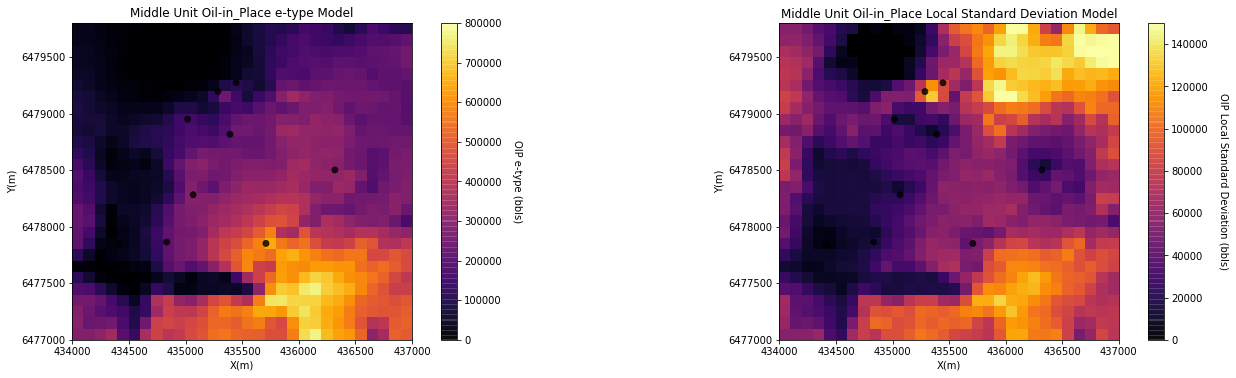

In [355]:
e_type = local_expectation(realizations)
local_stdev = local_standard_deviation(realizations)

plt.subplot(1,2,1)
locpix_st(e_type,Xmin,Xmax,Ymin,Ymax,xsiz,oip_min,oip_max,df,'X','Y',features[i],unit + ' Unit Oil-in_Place e-type Model','X(m)','Y(m)','OIP e-type (bbls)',cmap)

plt.subplot(1,2,2)
locpix_st(local_stdev,Xmin,Xmax,Ymin,Ymax,xsiz,0,oip_std_max,df,'X','Y','dummy',unit + ' Unit Oil-in_Place Local Standard Deviation Model','X(m)','Y(m)','OIP Local Standard Deviation (bbls)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.1, wspace=0.2, hspace=0.2)
plt.show() 

The e-type model is very simlar to a kriging model, except for:

* the Gaussian forward and back transform may change the results
* result are noisy due to too few realizations

The conditional variance is lowest at the data locations and increased away from the data

* the result is noisy due to too few realizations

##### Local Percentiles

Now let's look at the:

* **local percentile** maps are the maps with the local percentile values sampled from the local realizations

We can interprete them as follows, at a location if we have a local P10 of 14% porosity, then we have a 90% probability of an even higher porosity, the porosity at that location is surely high.

Local percentiles are very convenient to understand local uncertainty.  We must make sure that we do not mix them up with a percentile model (the model that is globally ranked as a specific percentile outcome.

Note: we have to run the program for each percentile, we specify this as the *cdf_value* input.

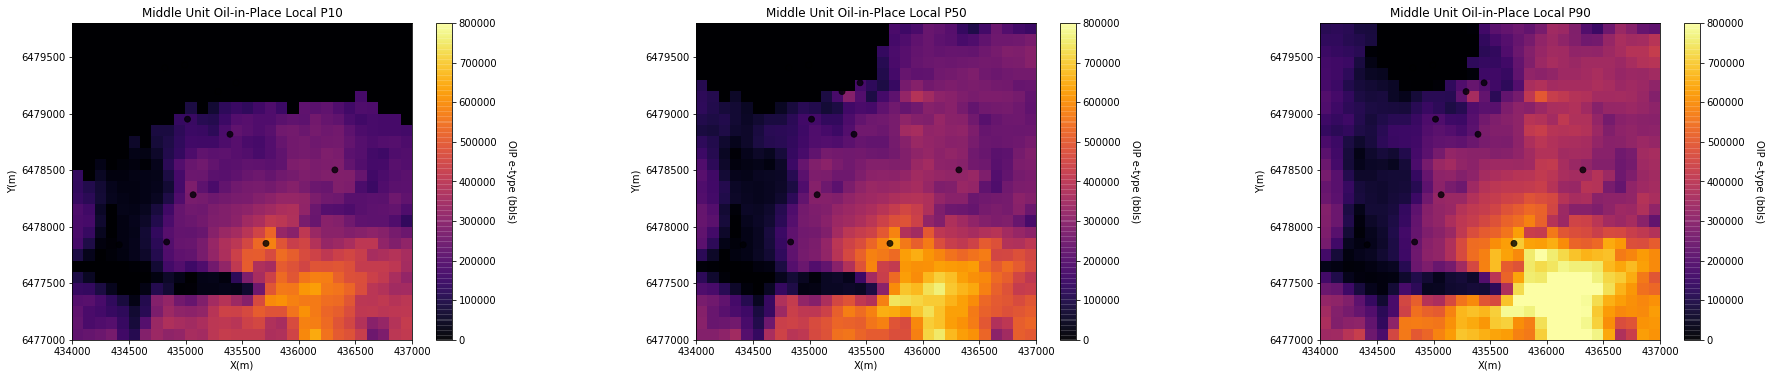

In [356]:
p1 = 10                                               # set the local percentiles  
p2 = 50
p3 = 90

localp1 = local_percentile(realizations = realizations,p_value = p1)
localp2 = local_percentile(realizations = realizations,p_value = p2)
localp3 = local_percentile(realizations = realizations,p_value = p3)

i = 0
plt.subplot(1,3,1)
locpix_st(localp1,Xmin,Xmax,Ymin,Ymax,xsiz,oip_min,oip_max,df,'X','Y',features[i],unit + ' Unit Oil-in-Place Local P' + str(p1),'X(m)','Y(m)','OIP e-type (bbls)',cmap)

plt.subplot(1,3,2)
locpix_st(localp2,Xmin,Xmax,Ymin,Ymax,xsiz,oip_min,oip_max,df,'X','Y',features[i],unit + ' Unit Oil-in-Place Local P' + str(p2),'X(m)','Y(m)','OIP e-type (bbls)',cmap)

plt.subplot(1,3,3)
locpix_st(localp3,Xmin,Xmax,Ymin,Ymax,xsiz,oip_min,oip_max,df,'X','Y',features[i],unit + ' Unit Oil-in-Place Local P' + str(p3),'X(m)','Y(m)','OIP e-type (bbls)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=4.0, top=1.1, wspace=0.3, hspace=0.2)
plt.show()

##### Risk Maps

Now we will look at the: 

* **probability of exceedance** where we specify a threshold porosity value and calculate the probability of exceeding that value at all locations.

We will typically select critical thresholds, such as a net-to-gross threshold.

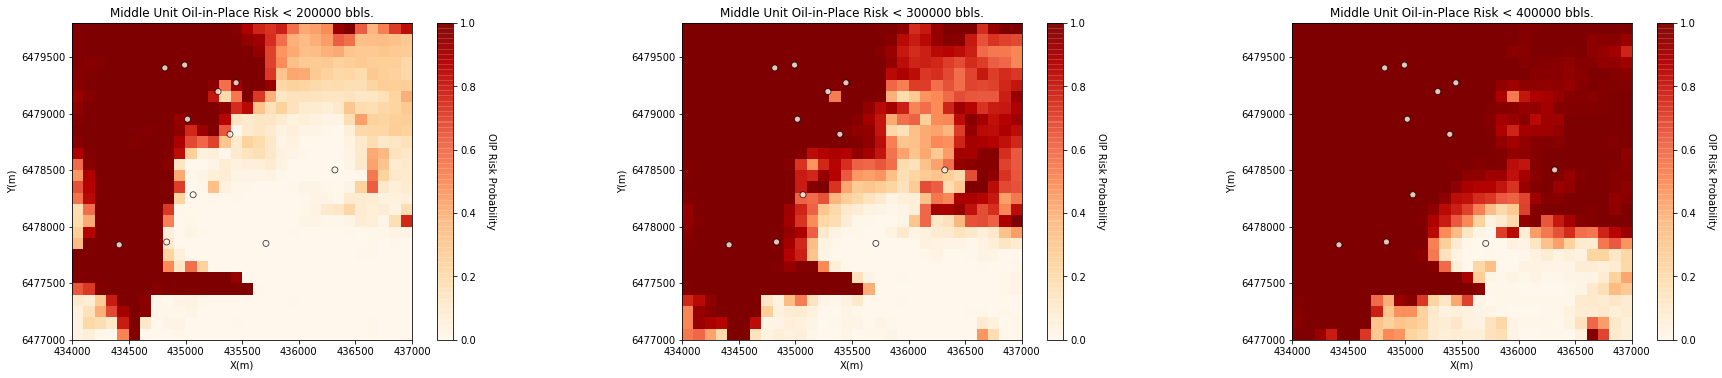

In [358]:
thresh1 = 200000                          # set the economic OIP thresholds
thresh2 = 300000
thresh3 = 400000

prob_thresh1 = 1.0-local_probability_exceedance(realizations = realizations,threshold = thresh1)
prob_thresh2 = 1.0-local_probability_exceedance(realizations = realizations,threshold = thresh2)
prob_thresh3 = 1.0-local_probability_exceedance(realizations = realizations,threshold = thresh3)

plt.subplot(1,3,1)
locpix_st(prob_thresh1,Xmin,Xmax,Ymin,Ymax,xsiz,0.0,1.,df,'X','Y','dummy',unit + ' Unit Oil-in-Place Risk < ' + str(thresh1) + ' bbls.','X(m)','Y(m)','OIP Risk Probability',plt.cm.OrRd)

plt.subplot(1,3,2)
locpix_st(prob_thresh2,Xmin,Xmax,Ymin,Ymax,xsiz,0.0,1.,df,'X','Y','dummy',unit + ' Unit Oil-in-Place Risk < ' + str(thresh2) + ' bbls.','X(m)','Y(m)','OIP Risk Probability',plt.cm.OrRd)

plt.subplot(1,3,3)
locpix_st(prob_thresh3,Xmin,Xmax,Ymin,Ymax,xsiz,0.0,1.,df,'X','Y','dummy',unit + ' Unit Oil-in-Place Risk < ' + str(thresh3) + ' bbls.','X(m)','Y(m)','OIP Risk Probability',plt.cm.OrRd)

plt.subplots_adjust(left=0.0, bottom=0.0, right=4.0, top=1.1, wspace=0.2, hspace=0.2)
plt.show()

#### Run and Compare Scenarios

In [359]:
nreal = 100
data = False; trend = False; dist = False; spatial = True
realizations_spatial = run_realizations(data,trend,dist,spatial,nreal)

data = True; trend = False; dist = False; spatial = False
realizations_data = run_realizations(data,trend,dist,spatial,nreal)

data = False; trend = True; dist = False; spatial = False
realizations_trend = run_realizations(data,trend,dist,spatial,nreal)

data = False; trend = False; dist = True; spatial = False
realizations_dist = run_realizations(data,trend,dist,spatial,nreal)

data = True; trend = True; dist = True; spatial = True
realizations_all = run_realizations(data,trend,dist,spatial,nreal)

data = False; trend = False; dist = True; spatial = True
realizations_dist_spatial = run_realizations(data,trend,dist,spatial,nreal)

data = True; trend = False; dist = False; spatial = True
realizations_data_spatial = run_realizations(data,trend,dist,spatial,nreal)

data = True; trend = False; dist = True; spatial = True
realizations_data_dist_spatial = run_realizations(data,trend,dist,spatial,nreal)

data = True; trend = False; dist = True; spatial = True
realizations_data_dist_spatial = run_realizations(data,trend,dist,spatial,nreal)

Let's visualize the uncertainty for uncertainty sourses, one at a time. 

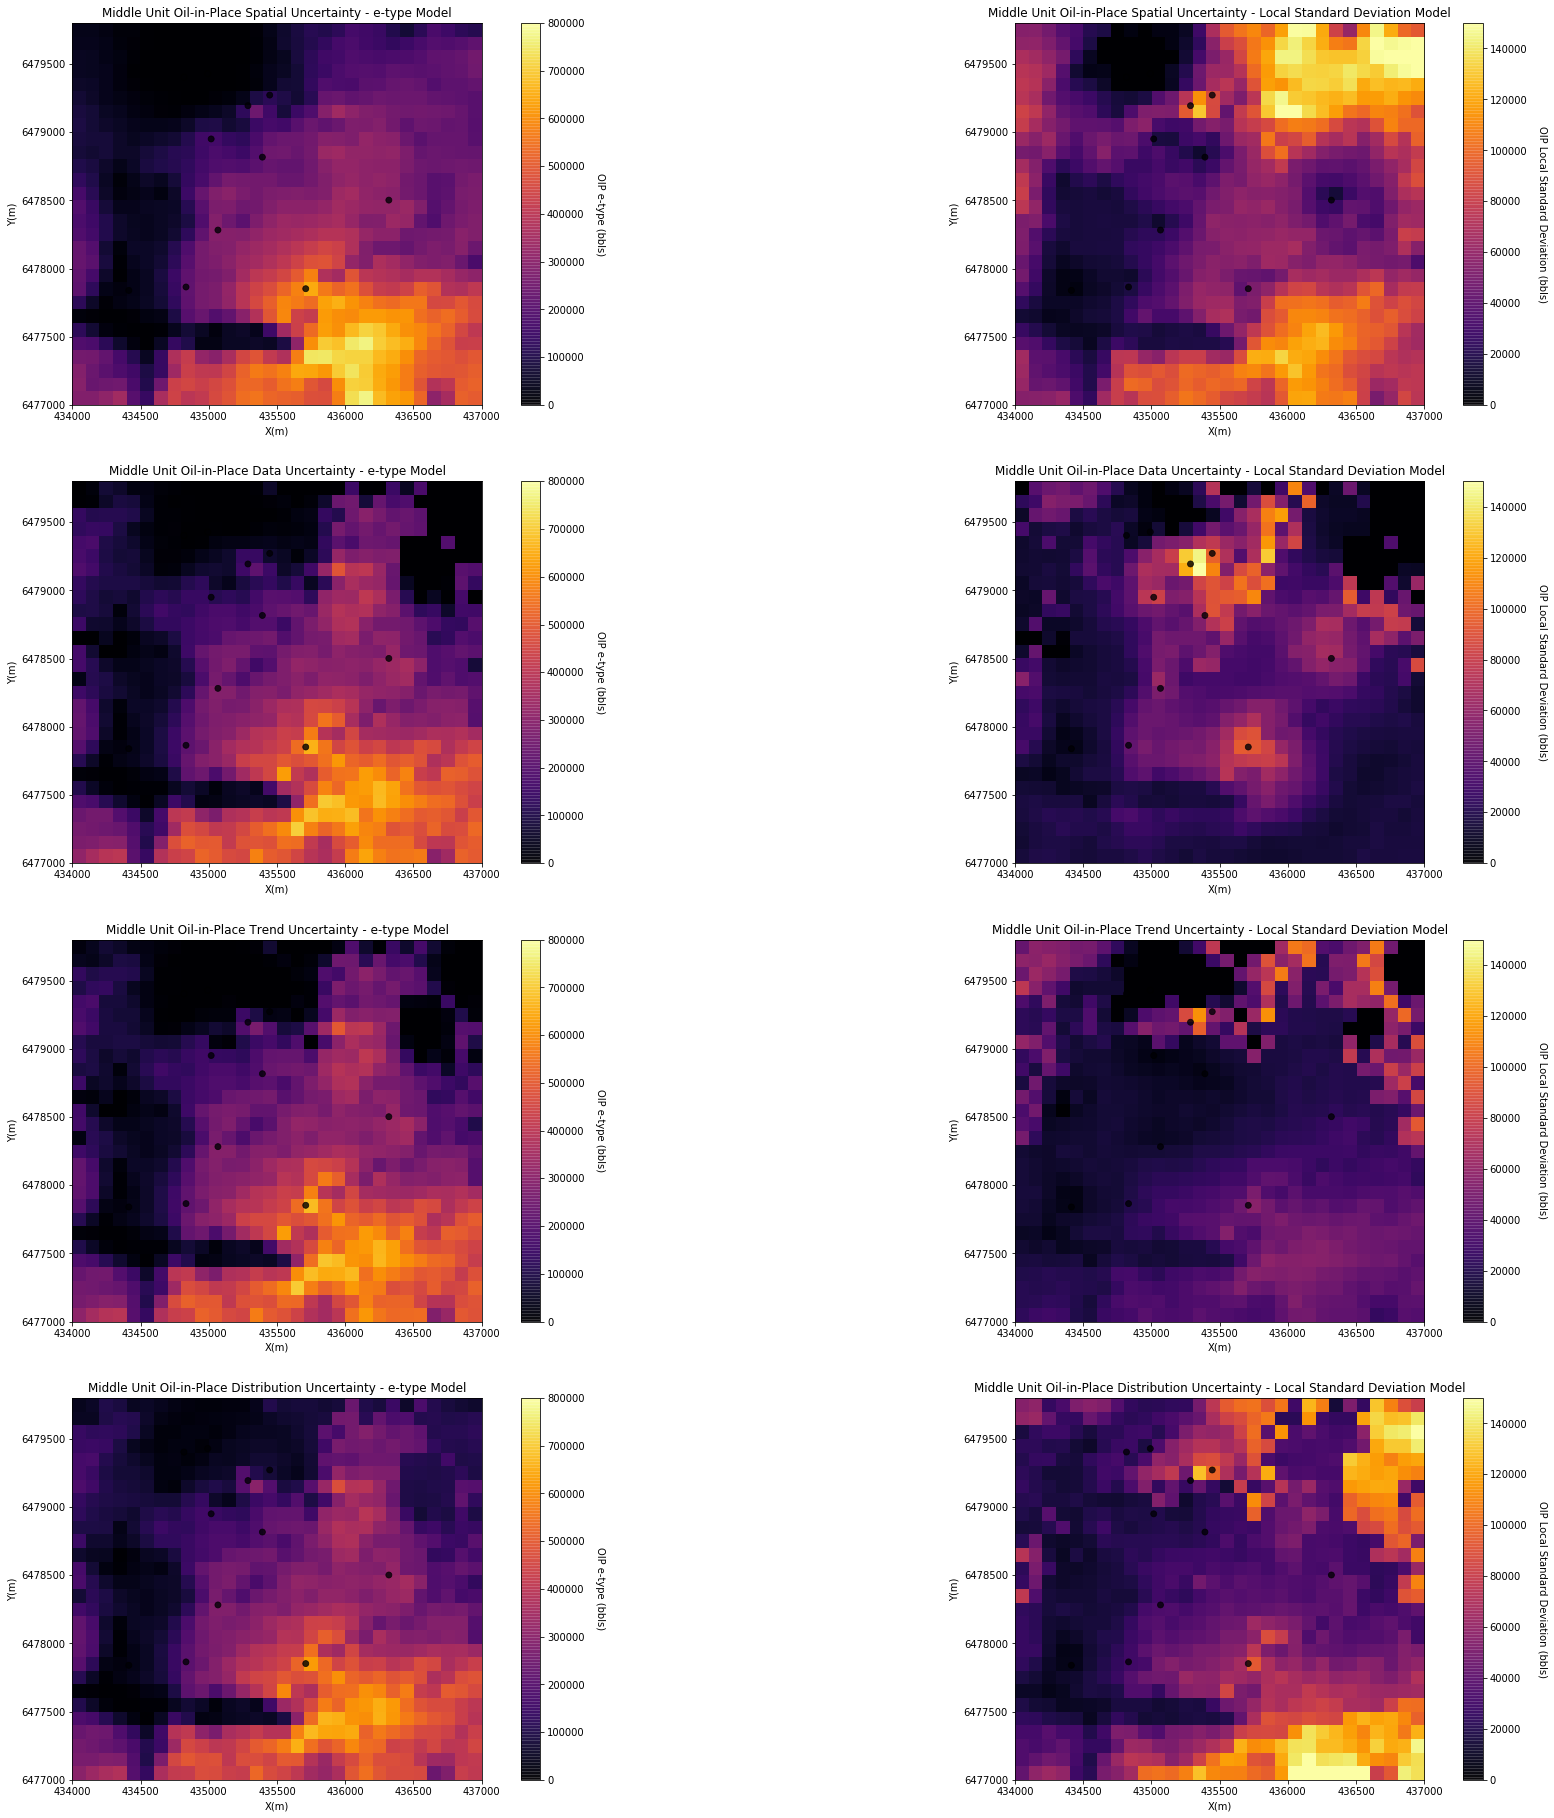

In [360]:
e_type_spatial = local_expectation(realizations_spatial)
stdev_spatial = local_standard_deviation(realizations_spatial)

e_type_data = local_expectation(realizations_data)
stdev_data = local_standard_deviation(realizations_data)

e_type_trend = local_expectation(realizations_trend)
stdev_trend = local_standard_deviation(realizations_trend)

e_type_dist = local_expectation(realizations_dist)
stdev_dist = local_standard_deviation(realizations_dist)

plt.subplot(421)
locpix_st(e_type_spatial,Xmin,Xmax,Ymin,Ymax,xsiz,oip_min,oip_max,df,'X','Y',features[i],unit + ' Unit Oil-in-Place Spatial Uncertainty - e-type Model','X(m)','Y(m)','OIP e-type (bbls)',cmap)

plt.subplot(422)
locpix_st(stdev_spatial,Xmin,Xmax,Ymin,Ymax,xsiz,0,oip_std_max,df,'X','Y',features[i],unit + ' Unit Oil-in-Place Spatial Uncertainty - Local Standard Deviation Model','X(m)','Y(m)','OIP Local Standard Deviation (bbls)',cmap)

plt.subplot(423)
locpix_st(e_type_data,Xmin,Xmax,Ymin,Ymax,xsiz,oip_min,oip_max,df,'X','Y',features[i],unit + ' Unit Oil-in-Place Data Uncertainty - e-type Model','X(m)','Y(m)','OIP e-type (bbls)',cmap)

plt.subplot(424)
locpix_st(stdev_data,Xmin,Xmax,Ymin,Ymax,xsiz,0,oip_std_max,df,'X','Y',features[i],unit + ' Unit Oil-in-Place Data Uncertainty - Local Standard Deviation Model','X(m)','Y(m)','OIP Local Standard Deviation (bbls)',cmap)

plt.subplot(425)
locpix_st(e_type_trend,Xmin,Xmax,Ymin,Ymax,xsiz,oip_min,oip_max,df,'X','Y',features[i],unit + ' Unit Oil-in-Place Trend Uncertainty - e-type Model','X(m)','Y(m)','OIP e-type (bbls)',cmap)

plt.subplot(426)
locpix_st(stdev_trend,Xmin,Xmax,Ymin,Ymax,xsiz,0,oip_std_max,df,'X','Y',features[i],unit + ' Unit Oil-in-Place Trend Uncertainty - Local Standard Deviation Model','X(m)','Y(m)','OIP Local Standard Deviation (bbls)',cmap)

plt.subplot(427)
locpix_st(e_type_dist,Xmin,Xmax,Ymin,Ymax,xsiz,oip_min,oip_max,df,'X','Y',features[i],unit + ' Unit Oil-in-Place Distribution Uncertainty - e-type Model','X(m)','Y(m)','OIP e-type (bbls)',cmap)

plt.subplot(428)
locpix_st(stdev_dist,Xmin,Xmax,Ymin,Ymax,xsiz,0,oip_std_max,df,'X','Y',features[i],unit + ' Unit Oil-in-Place Distribution Uncertainty - Local Standard Deviation Model','X(m)','Y(m)','OIP Local Standard Deviation (bbls)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=4.0, top=6.1, wspace=0.2, hspace=0.2)
plt.show()

#### Calculate Local Uncertainty Proportions

Let's calculate the local uncertainty proportions.

* we assume no correlation between uncertainty sources, resulting in additivity of variance

We proceed by:

1. converting local standard deviations to variances

2. calculating the the sum of variances

3. then calculate the proportions of variance for each uncertainty source

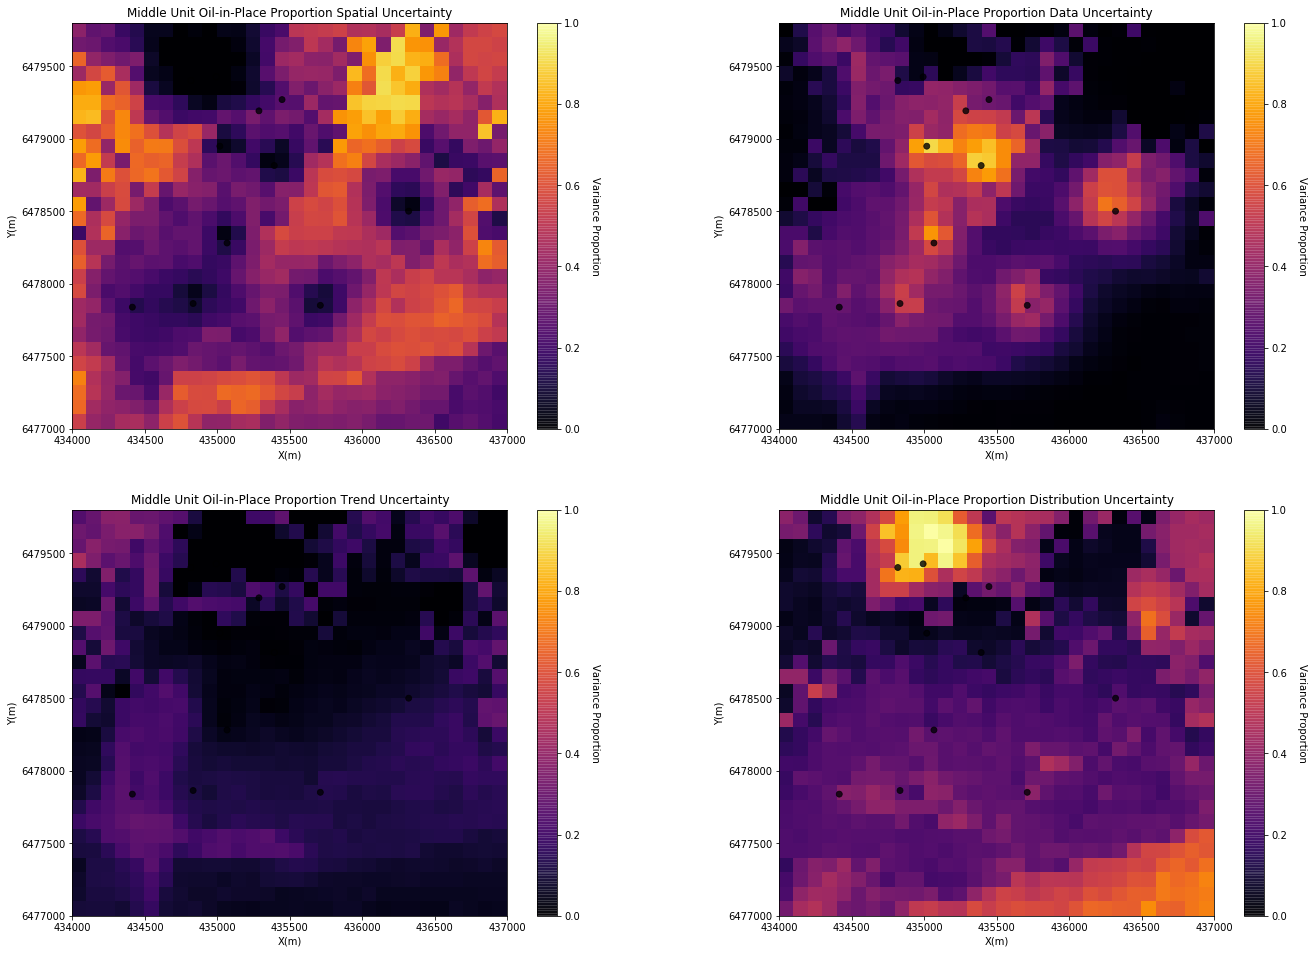

In [365]:
var_spatial = stdev_spatial**2; var_data = stdev_data**2
var_trend = stdev_trend**2; var_dist = stdev_dist**2
var_sum = var_spatial + var_data + var_trend + var_dist

prop_spatial = var_spatial/var_sum; prop_data = var_data/var_sum
prop_trend = var_trend/var_sum; prop_dist = var_dist/var_sum

plt.subplot(221)
locpix_st(prop_spatial,Xmin,Xmax,Ymin,Ymax,xsiz,0.0,1.0,df,'X','Y','dummy',unit + ' Unit Oil-in-Place Proportion Spatial Uncertainty','X(m)','Y(m)','Variance Proportion',cmap)

plt.subplot(222)
locpix_st(prop_data,Xmin,Xmax,Ymin,Ymax,xsiz,0.0,1.0,df,'X','Y','dummy',unit + ' Unit Oil-in-Place Proportion Data Uncertainty','X(m)','Y(m)','Variance Proportion',cmap)

plt.subplot(223)
locpix_st(prop_trend,Xmin,Xmax,Ymin,Ymax,xsiz,0.0,1.0,df,'X','Y','dummy',unit + ' Unit Oil-in-Place Proportion Trend Uncertainty','X(m)','Y(m)','Variance Proportion',cmap)

plt.subplot(224)
locpix_st(prop_dist,Xmin,Xmax,Ymin,Ymax,xsiz,0.0,1.0,df,'X','Y','dummy',unit + ' Unit Oil-in-Place Proportion Distribution Uncertainty','X(m)','Y(m)','Variance Proportion',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.1, wspace=0.2, hspace=0.2)
plt.show()

#### Sequentially Add Uncertainty Sources

Let's sequentially add uncertainty sources.

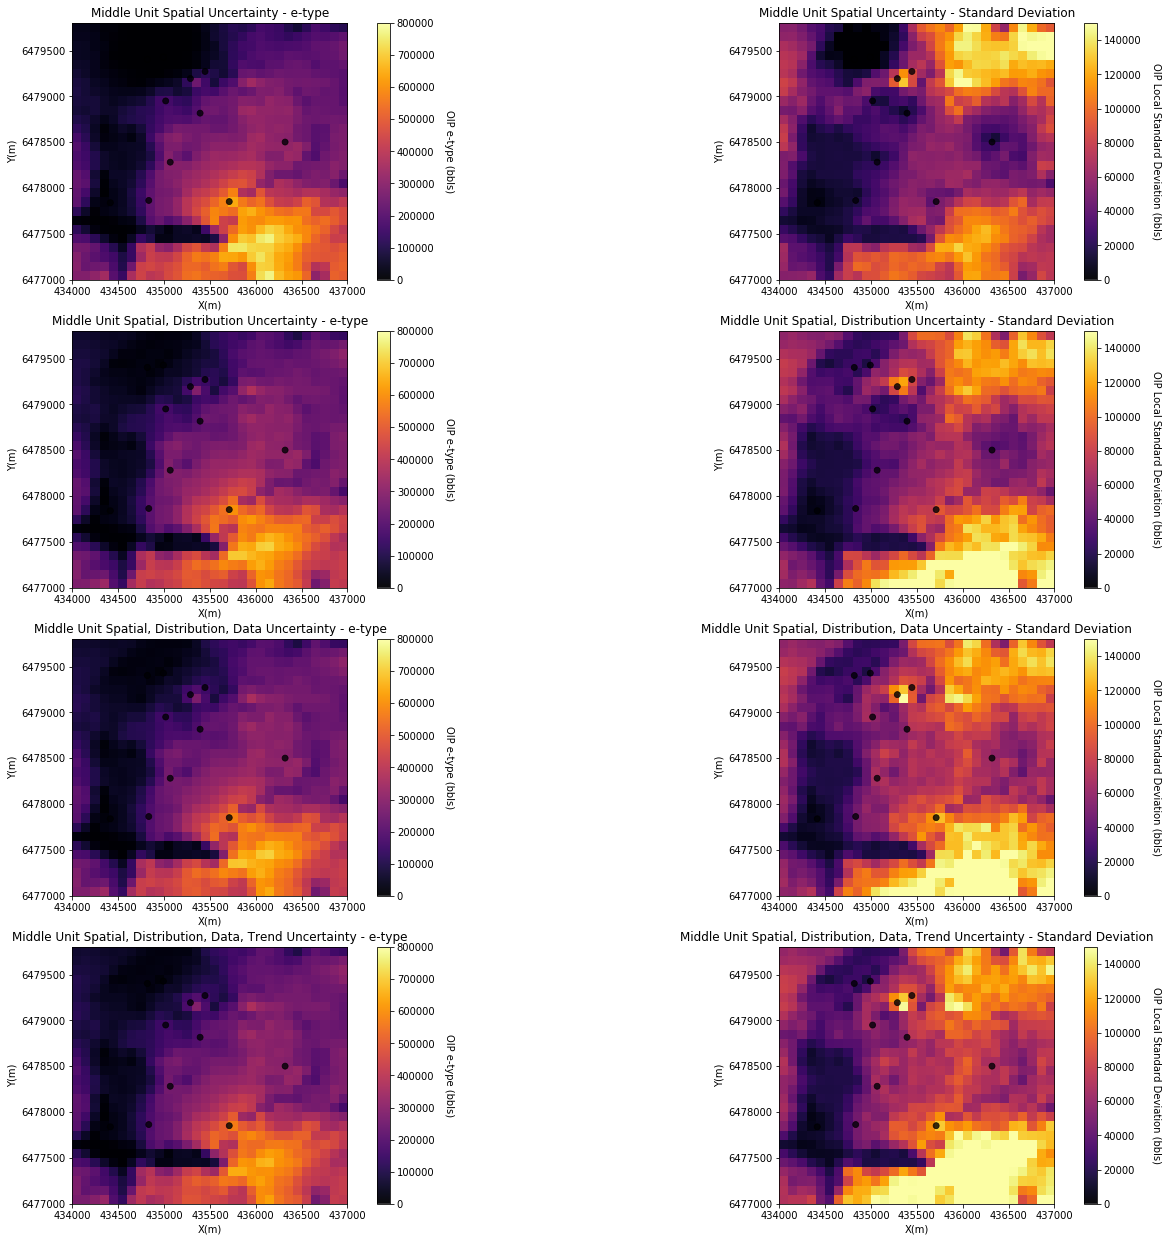

In [366]:
e_type_spatial = local_expectation(realizations_spatial)
stdev_spatial = local_standard_deviation(realizations_spatial)

e_type_dist_spatial = local_expectation(realizations_dist_spatial)
stdev_dist_spatial = local_standard_deviation(realizations_dist_spatial)

e_type_data_spatial = local_expectation(realizations_data_spatial)
stdev_data_spatial = local_standard_deviation(realizations_data_spatial)

e_type_data_dist_spatial = local_expectation(realizations_data_dist_spatial)
stdev_data_dist_spatial = local_standard_deviation(realizations_data_dist_spatial)

e_type_all = local_expectation(realizations_all)
stdev_all = local_standard_deviation(realizations_all)

plt.subplot(421)
locpix_st(e_type_spatial,Xmin,Xmax,Ymin,Ymax,xsiz,oip_min,oip_max,df,'X','Y',features[i],unit + ' Unit Spatial Uncertainty - e-type','X(m)','Y(m)','OIP e-type (bbls)',cmap)

plt.subplot(422)
locpix_st(stdev_spatial,Xmin,Xmax,Ymin,Ymax,xsiz,0.0,oip_std_max,df,'X','Y',features[i],unit + ' Unit Spatial Uncertainty - Standard Deviation','X(m)','Y(m)','OIP Local Standard Deviation (bbls)',cmap)

plt.subplot(423)
locpix_st(e_type_dist_spatial,Xmin,Xmax,Ymin,Ymax,xsiz,oip_min,oip_max,df,'X','Y',features[i],unit + ' Unit Spatial, Distribution Uncertainty - e-type','X(m)','Y(m)','OIP e-type (bbls)',cmap)

plt.subplot(424)
locpix_st(stdev_dist_spatial,Xmin,Xmax,Ymin,Ymax,xsiz,0.0,oip_std_max,df,'X','Y',features[i],unit + ' Unit Spatial, Distribution Uncertainty - Standard Deviation','X(m)','Y(m)','OIP Local Standard Deviation (bbls)',cmap)

plt.subplot(425)
locpix_st(e_type_data_dist_spatial,Xmin,Xmax,Ymin,Ymax,xsiz,oip_min,oip_max,df,'X','Y',features[i],unit + ' Unit Spatial, Distribution, Data Uncertainty - e-type','X(m)','Y(m)','OIP e-type (bbls)',cmap)

plt.subplot(426)
locpix_st(stdev_data_dist_spatial,Xmin,Xmax,Ymin,Ymax,xsiz,0.0,oip_std_max,df,'X','Y',features[i],unit + ' Unit Spatial, Distribution, Data Uncertainty - Standard Deviation','X(m)','Y(m)','OIP Local Standard Deviation (bbls)',cmap)

plt.subplot(427)
locpix_st(e_type_all,Xmin,Xmax,Ymin,Ymax,xsiz,oip_min,oip_max,df,'X','Y',features[i],unit + ' Unit Spatial, Distribution, Data, Trend Uncertainty - e-type','X(m)','Y(m)','OIP e-type (bbls)',cmap)

plt.subplot(428)
locpix_st(stdev_all,Xmin,Xmax,Ymin,Ymax,xsiz,0.0,oip_std_max,df,'X','Y',features[i],unit + ' Unit Spatial, Distribution, Data, Trend Uncertainty - Standard Deviation','X(m)','Y(m)','OIP Local Standard Deviation (bbls)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=4.1, wspace=0.2, hspace=0.2)
plt.show()

#### Summary of Complete Uncertainty Model

Now we can provide a risk map for the complete uncertainty model.

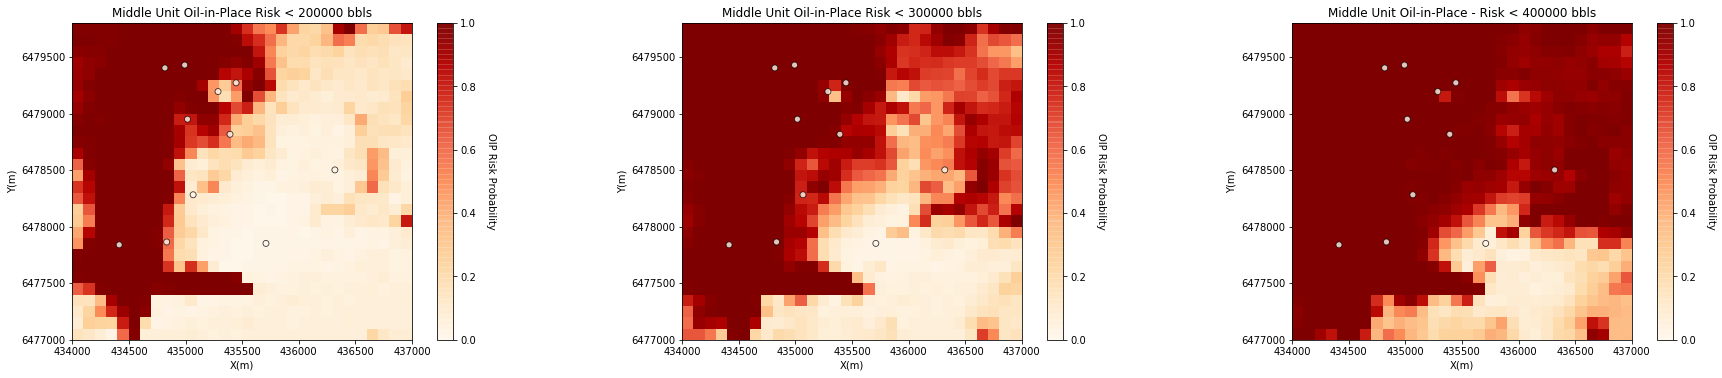

In [369]:
thresh1 = 200000                          # set the economic OIP thresholds
thresh2 = 300000
thresh3 = 400000

prob_thresh1 = 1.0-local_probability_exceedance(realizations = realizations_all,threshold = thresh1)
prob_thresh2 = 1.0-local_probability_exceedance(realizations = realizations_all,threshold = thresh2)
prob_thresh3 = 1.0-local_probability_exceedance(realizations = realizations_all,threshold = thresh3)

plt.subplot(1,3,1)
locpix_st(prob_thresh1,Xmin,Xmax,Ymin,Ymax,xsiz,0.0,1.,df,'X','Y','dummy',unit + ' Unit Oil-in-Place Risk < ' + str(thresh1) + ' bbls','X(m)','Y(m)','OIP Risk Probability',plt.cm.OrRd)

plt.subplot(1,3,2)
locpix_st(prob_thresh2,Xmin,Xmax,Ymin,Ymax,xsiz,0.0,1.,df,'X','Y','dummy',unit + ' Unit Oil-in-Place Risk < ' + str(thresh2) + ' bbls','X(m)','Y(m)','OIP Risk Probability',plt.cm.OrRd)

plt.subplot(1,3,3)
locpix_st(prob_thresh3,Xmin,Xmax,Ymin,Ymax,xsiz,0.0,1.,df,'X','Y','dummy',unit + ' Unit Oil-in-Place - Risk < ' + str(thresh3) + ' bbls','X(m)','Y(m)','OIP Risk Probability',plt.cm.OrRd)

plt.subplots_adjust(left=0.0, bottom=0.0, right=4.0, top=1.1, wspace=0.2, hspace=0.2)
plt.show()

#### Demonstration Storey Boards 

##### Local Uncertainty and Risk

Let's first show local distributions of uncertainty and risk relative to an economic threshold.

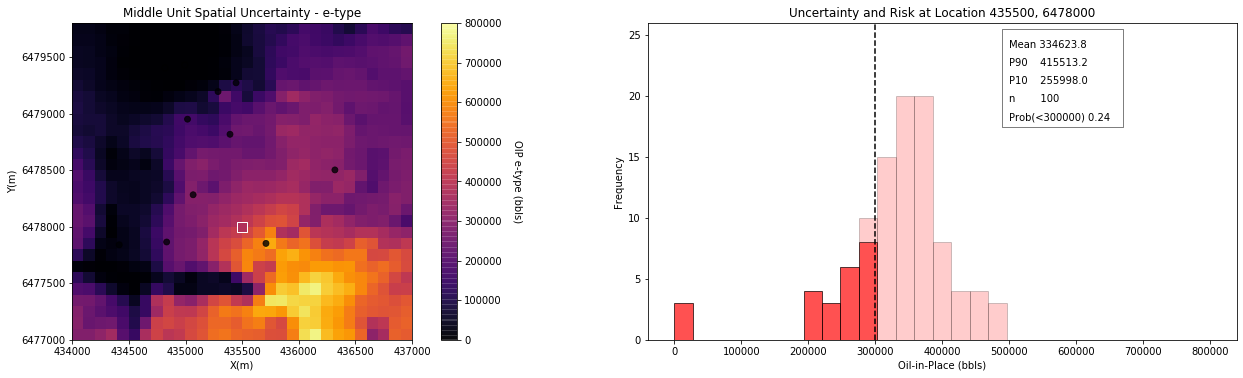

In [377]:
x = 435500; y = 6478000; threshold = 300000

ix = min(int((x - xmn) / xsiz), nx - 1)
iy = ny - min(int((y - ymn) / ysiz), ny - 1)-1
val = e_type_spatial[iy,ix]
risk = len(realizations_all[iy,ix,realizations_all[iy,ix,:]<threshold])/realizations_all[iy,ix,:].shape[0]

plt.subplot(121)
locpix_st(e_type_spatial,Xmin,Xmax,Ymin,Ymax,xsiz,oip_min,oip_max,df,'X','Y',features[i],unit + ' Unit Spatial Uncertainty - e-type','X(m)','Y(m)','OIP e-type (bbls)',cmap)
plt.scatter([x],[y],s=100,marker='s',edgecolor='white',c=[val],vmin=oip_min,vmax=oip_max,cmap=plt.cm.inferno)

plt.subplot(122)
plt.hist(realizations_all[iy,ix,:],color='red',alpha=0.2,edgecolor='black',bins = np.linspace(oip_min,oip_max,30))
plt.hist(realizations_all[iy,ix,realizations_all[iy,ix,:]<threshold],color='red',alpha=0.6,edgecolor='black',bins = np.linspace(oip_min,oip_max,30))

plt.plot([threshold,threshold],[0.0,26],color = 'black',linestyle='dashed')
plt.xlabel('Oil-in-Place (bbls)'); plt.ylabel('Frequency'); plt.title('Uncertainty and Risk at Location ' + str(x) + ', ' + str(y))
plt.ylim([0,26])
plt.gca().add_patch(Rectangle((490000,17.5),180000,8,facecolor='white',edgecolor='black',linewidth=0.5))
plt.text(500000,24,'Mean ' + str(round(np.average(realizations_all[iy,ix,:]),1))); 
plt.text(500000,22.5,'P90    ' + str(round(np.percentile(realizations_all[iy,ix,:],90),1)))
plt.text(500000,21,'P10    ' + str(round(np.percentile(realizations_all[iy,ix,:],10),1))); 
plt.text(500000,19.5,'n        ' + str(realizations_all[iy,ix,:].shape[0]))
plt.text(500000,18.0,'Prob(<' + str(threshold)+') ' + str(risk))

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.1, wspace=0.2, hspace=0.2)
plt.show()

##### Local Uncertainty and Risk

Let's now show the local uncertainty contributions.

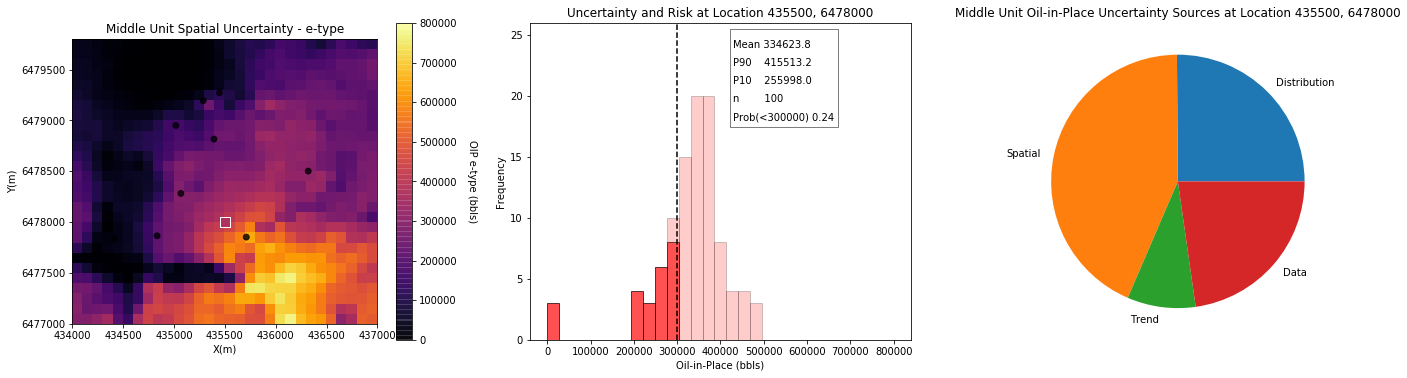

In [378]:
x = 435500; y = 6478000; threshold = 300000

ix = min(int((x - xmn) / xsiz), nx - 1)
iy = ny - min(int((y - ymn) / ysiz), ny - 1)-1
val = e_type_spatial[iy,ix]
risk = len(realizations_all[iy,ix,realizations_all[iy,ix,:]<threshold])/realizations_all[iy,ix,:].shape[0]

plt.subplot(131)
locpix_st(e_type_spatial,Xmin,Xmax,Ymin,Ymax,xsiz,oip_min,oip_max,df,'X','Y',features[i],unit + ' Unit Spatial Uncertainty - e-type','X(m)','Y(m)','OIP e-type (bbls)',cmap)
plt.scatter([x],[y],s=100,marker='s',edgecolor='white',c=[val],vmin=oip_min,vmax=oip_max,cmap=plt.cm.inferno)

plt.subplot(132)
plt.hist(realizations_all[iy,ix,:],color='red',alpha=0.2,edgecolor='black',bins = np.linspace(oip_min,oip_max,30))
plt.hist(realizations_all[iy,ix,realizations_all[iy,ix,:]<threshold],color='red',alpha=0.6,edgecolor='black',bins = np.linspace(oip_min,oip_max,30))

legendx = 430000
plt.plot([threshold,threshold],[0.0,26],color = 'black',linestyle='dashed')
plt.xlabel('Oil-in-Place (bbls)'); plt.ylabel('Frequency'); plt.title('Uncertainty and Risk at Location ' + str(x) + ', ' + str(y))
plt.ylim([0,26])
plt.gca().add_patch(Rectangle((legendx*0.98,17.5),250000,8,facecolor='white',edgecolor='black',linewidth=0.5))
plt.text(legendx,24,'Mean ' + str(round(np.average(realizations_all[iy,ix,:]),1))); 
plt.text(legendx,22.5,'P90    ' + str(round(np.percentile(realizations_all[iy,ix,:],90),1)))
plt.text(legendx,21,'P10    ' + str(round(np.percentile(realizations_all[iy,ix,:],10),1))); 
plt.text(legendx,19.5,'n        ' + str(realizations_all[iy,ix,:].shape[0]))
plt.text(legendx,18.0,'Prob(<' + str(threshold)+') ' + str(risk))

plt.subplot(133)
plt.pie([prop_dist[iy,ix],prop_spatial[iy,ix],prop_trend[iy,ix],prop_data[iy,ix]],labels=['Distribution','Spatial','Trend','Data'])
plt.title(unit + ' Unit Oil-in-Place Uncertainty Sources at Location ' + str(x) + ', ' + str(y))

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.1, wspace=0.2, hspace=0.2)
plt.show()

#### Change in Uncertainty Maps

Impact of adding another uncertainty source on the uncertainty maps, adding distribution uncertainty to spatial uncertainty.

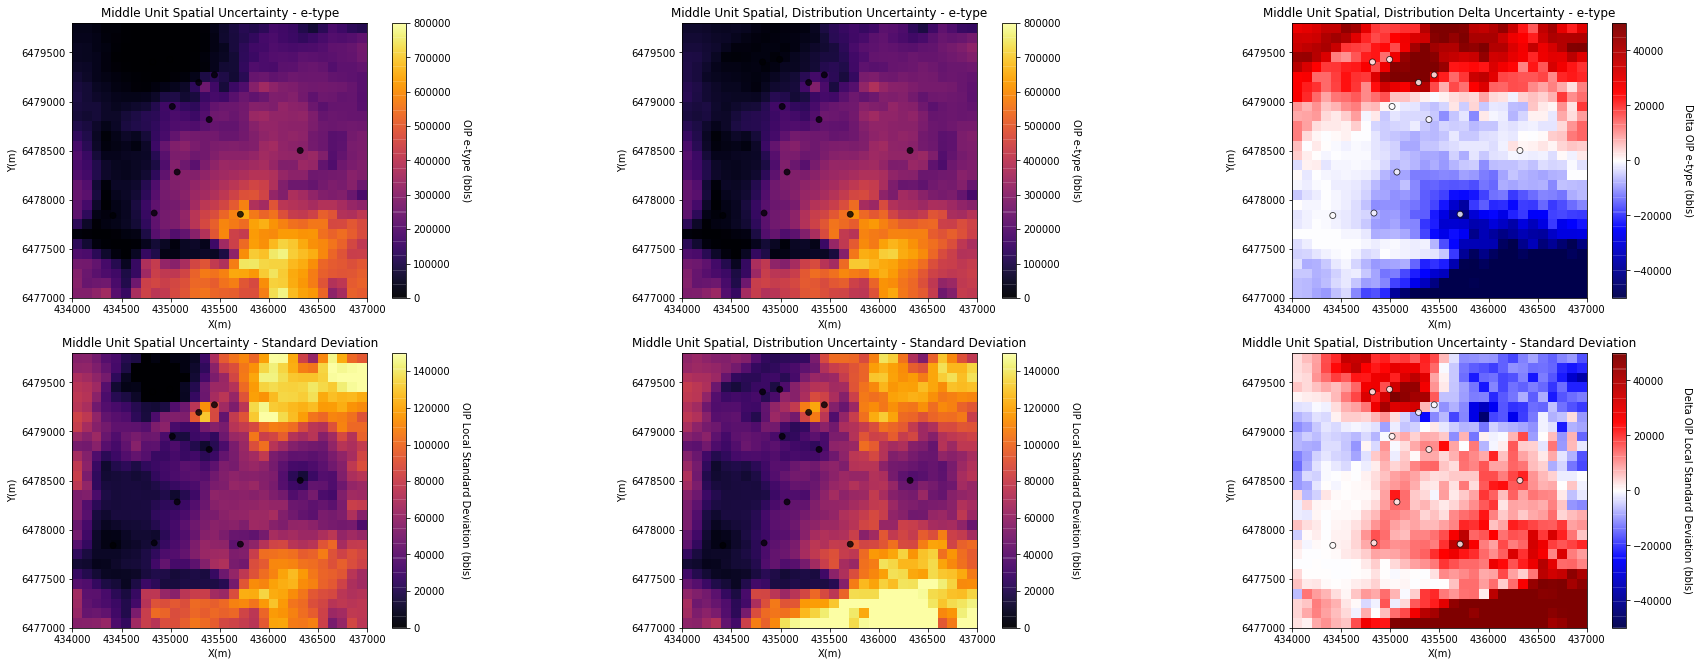

In [383]:
e_type_spatial = local_expectation(realizations_spatial)
stdev_spatial = local_standard_deviation(realizations_spatial)

e_type_dist_spatial = local_expectation(realizations_dist_spatial)
stdev_dist_spatial = local_standard_deviation(realizations_dist_spatial)

e_type_delta = e_type_dist_spatial - e_type_spatial
stdev_delta = stdev_dist_spatial - stdev_spatial

plt.subplot(231)
locpix_st(e_type_spatial,Xmin,Xmax,Ymin,Ymax,xsiz,oip_min,oip_max,df,'X','Y',features[i],unit + ' Unit Spatial Uncertainty - e-type','X(m)','Y(m)','OIP e-type (bbls)',cmap)

plt.subplot(232)
locpix_st(e_type_dist_spatial,Xmin,Xmax,Ymin,Ymax,xsiz,oip_min,oip_max,df,'X','Y',features[i],unit + ' Unit Spatial, Distribution Uncertainty - e-type','X(m)','Y(m)','OIP e-type (bbls)',cmap)

plt.subplot(233)
locpix_st(e_type_delta,Xmin,Xmax,Ymin,Ymax,xsiz,oip_delta_min,oip_delta_max,df,'X','Y',features[i],unit + ' Unit Spatial, Distribution Delta Uncertainty - e-type','X(m)','Y(m)','Delta OIP e-type (bbls)',cmap=plt.cm.seismic)

plt.subplot(234)
locpix_st(stdev_spatial,Xmin,Xmax,Ymin,Ymax,xsiz,0.0,oip_std_max,df,'X','Y',features[i],unit + ' Unit Spatial Uncertainty - Standard Deviation','X(m)','Y(m)','OIP Local Standard Deviation (bbls)',cmap)

plt.subplot(235)
locpix_st(stdev_dist_spatial,Xmin,Xmax,Ymin,Ymax,xsiz,0.0,oip_std_max,df,'X','Y',features[i],unit + ' Unit Spatial, Distribution Uncertainty - Standard Deviation','X(m)','Y(m)','OIP Local Standard Deviation (bbls)',cmap)

plt.subplot(236)
locpix_st(stdev_delta,Xmin,Xmax,Ymin,Ymax,xsiz,oip_delta_min,oip_delta_max,df,'X','Y',features[i],unit + ' Unit Spatial, Distribution Uncertainty - Standard Deviation','X(m)','Y(m)','Delta OIP Local Standard Deviation (bbls)',cmap=plt.cm.seismic)

plt.subplots_adjust(left=0.0, bottom=0.0, right=4.0, top=2.1, wspace=0.2, hspace=0.2)
plt.show()

#### Local Change in Uncertainty, Spatial with Distribution Uncertainty 

Visualization of the change in local uncertainty due to the addition of distribuiton uncertainty.

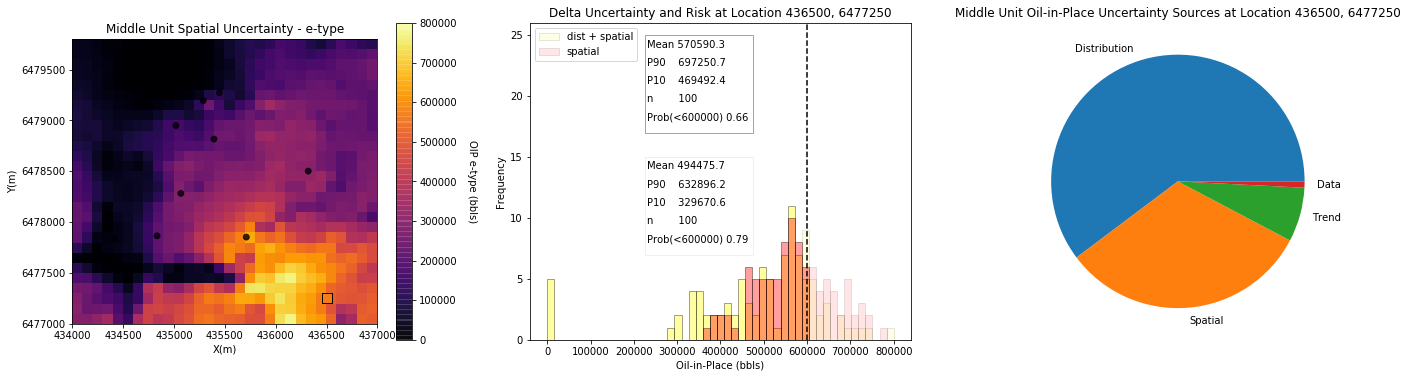

In [389]:
x = 436500; y = 6477250; threshold = 600000; nbins = 50

ix = min(int((x - xmn) / xsiz), nx - 1)
iy = ny - min(int((y - ymn) / ysiz), ny - 1)-1
val = e_type_spatial[iy,ix]
risk_spatial = len(realizations_spatial[iy,ix,realizations_spatial[iy,ix,:]<threshold])/realizations_spatial[iy,ix,:].shape[0]
risk_dist_spatial = len(realizations_dist_spatial[iy,ix,realizations_dist_spatial[iy,ix,:]<threshold])/realizations_dist_spatial[iy,ix,:].shape[0]

plt.subplot(131)
locpix_st(e_type_spatial,Xmin,Xmax,Ymin,Ymax,xsiz,oip_min,oip_max,df,'X','Y',features[i],unit + ' Unit Spatial Uncertainty - e-type','X(m)','Y(m)','OIP e-type (bbls)',cmap)
plt.scatter([x,-99],[y,-99],s=100,marker='s',edgecolor='black',c=[val,val],vmin=oip_min,vmax=oip_max,cmap=plt.cm.inferno)

plt.subplot(132)
plt.hist(realizations_dist_spatial[iy,ix,:],color='yellow',alpha=0.1,edgecolor='black',bins = np.linspace(oip_min,oip_max,nbins),label = 'dist + spatial')
plt.hist(realizations_dist_spatial[iy,ix,realizations_dist_spatial[iy,ix,:]<threshold],color='yellow',alpha=0.3,edgecolor='black',bins = np.linspace(oip_min,oip_max,nbins))

plt.hist(realizations_spatial[iy,ix,:],color='red',alpha=0.1,edgecolor='black',bins = np.linspace(oip_min,oip_max,nbins),label='spatial')
plt.hist(realizations_spatial[iy,ix,realizations_spatial[iy,ix,:]<threshold],color='red',alpha=0.3,edgecolor='black',bins = np.linspace(oip_min,oip_max,nbins))
plt.legend(loc='upper left')
legendx = 230000
plt.plot([threshold,threshold],[0.0,26],color = 'black',linestyle='dashed')
plt.xlabel('Oil-in-Place (bbls)'); plt.ylabel('Frequency'); plt.title('Delta Uncertainty and Risk at Location ' + str(x) + ', ' + str(y))
plt.ylim([0,26])

plt.gca().add_patch(Rectangle((legendx*0.98,17.0),250000,8,facecolor='white',edgecolor='red',linewidth=0.5))
plt.text(legendx,24,'Mean ' + str(round(np.average(realizations_spatial[iy,ix,:]),1))); 
plt.text(legendx,22.5,'P90    ' + str(round(np.percentile(realizations_spatial[iy,ix,:],90),1)))
plt.text(legendx,21,'P10    ' + str(round(np.percentile(realizations_spatial[iy,ix,:],10),1))); 
plt.text(legendx,19.5,'n        ' + str(realizations_spatial[iy,ix,:].shape[0]))
plt.text(legendx,18.0,'Prob(<' + str(threshold)+') ' + str(risk_spatial))

plt.gca().add_patch(Rectangle((legendx*0.98,7.0),250000,8,facecolor='white',edgecolor='yellow',linewidth=0.5))
plt.text(legendx,14,'Mean ' + str(round(np.average(realizations_dist_spatial[iy,ix,:]),1))); 
plt.text(legendx,12.5,'P90    ' + str(round(np.percentile(realizations_dist_spatial[iy,ix,:],90),1)))
plt.text(legendx,11,'P10    ' + str(round(np.percentile(realizations_dist_spatial[iy,ix,:],10),1))); 
plt.text(legendx,9.5,'n        ' + str(realizations_dist_spatial[iy,ix,:].shape[0]))
plt.text(legendx,8.0,'Prob(<' + str(threshold)+') ' + str(risk_dist_spatial))

plt.subplot(133)
plt.pie([prop_dist[iy,ix],prop_spatial[iy,ix],prop_trend[iy,ix],prop_data[iy,ix]],labels=['Distribution','Spatial','Trend','Data'])
plt.title(unit + ' Unit Oil-in-Place Uncertainty Sources at Location ' + str(x) + ', ' + str(y))

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.1, wspace=0.2, hspace=0.2)
plt.show()

#### Change in Uncertainty Maps

Impact of adding another uncertainty source on the uncertainty maps, adding data uncertainty to spatial uncertainty.

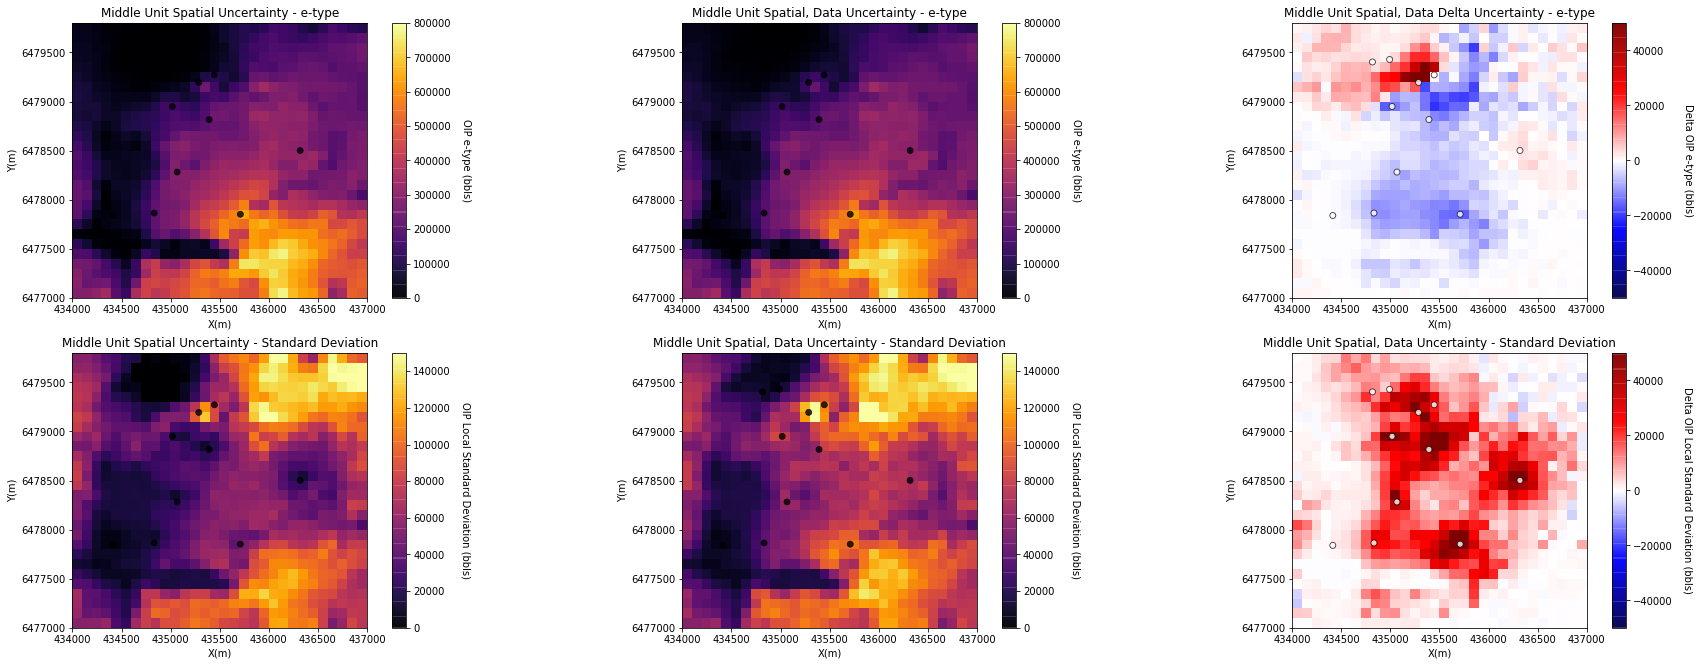

In [390]:
e_type_spatial = local_expectation(realizations_spatial)
stdev_spatial = local_standard_deviation(realizations_spatial)

e_type_dist_spatial = local_expectation(realizations_data_spatial)
stdev_dist_spatial = local_standard_deviation(realizations_data_spatial)

e_type_delta = e_type_data_spatial - e_type_spatial
stdev_delta = stdev_data_spatial - stdev_spatial

plt.subplot(231)
locpix_st(e_type_spatial,Xmin,Xmax,Ymin,Ymax,xsiz,oip_min,oip_max,df,'X','Y',features[i],unit + ' Unit Spatial Uncertainty - e-type','X(m)','Y(m)','OIP e-type (bbls)',cmap)

plt.subplot(232)
locpix_st(e_type_dist_spatial,Xmin,Xmax,Ymin,Ymax,xsiz,oip_min,oip_max,df,'X','Y',features[i],unit + ' Unit Spatial, Data Uncertainty - e-type','X(m)','Y(m)','OIP e-type (bbls)',cmap)

plt.subplot(233)
locpix_st(e_type_delta,Xmin,Xmax,Ymin,Ymax,xsiz,oip_delta_min,oip_delta_max,df,'X','Y',features[i],unit + ' Unit Spatial, Data Delta Uncertainty - e-type','X(m)','Y(m)','Delta OIP e-type (bbls)',cmap=plt.cm.seismic)

plt.subplot(234)
locpix_st(stdev_spatial,Xmin,Xmax,Ymin,Ymax,xsiz,0.0,oip_std_max,df,'X','Y',features[i],unit + ' Unit Spatial Uncertainty - Standard Deviation','X(m)','Y(m)','OIP Local Standard Deviation (bbls)',cmap)

plt.subplot(235)
locpix_st(stdev_dist_spatial,Xmin,Xmax,Ymin,Ymax,xsiz,0.0,oip_std_max,df,'X','Y',features[i],unit + ' Unit Spatial, Data Uncertainty - Standard Deviation','X(m)','Y(m)','OIP Local Standard Deviation (bbls)',cmap)

plt.subplot(236)
locpix_st(stdev_delta,Xmin,Xmax,Ymin,Ymax,xsiz,oip_delta_min,oip_delta_max,df,'X','Y',features[i],unit + ' Unit Spatial, Data Uncertainty - Standard Deviation','X(m)','Y(m)','Delta OIP Local Standard Deviation (bbls)',cmap=plt.cm.seismic)

plt.subplots_adjust(left=0.0, bottom=0.0, right=4.0, top=2.1, wspace=0.2, hspace=0.2)
plt.show()

#### Local Change in Uncertainty, Spatial with Data Uncertainty 

Visualization of the change in local uncertainty due to the addition of distribuiton uncertainty.

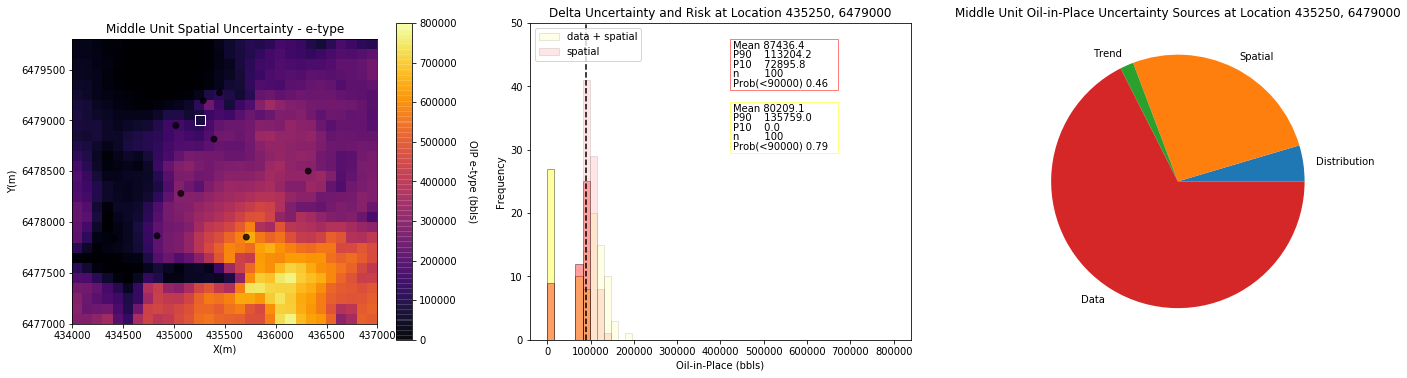

In [392]:
x = 435250; y = 6479000; threshold = 90000; nbins = 50

ix = min(int((x - xmn) / xsiz), nx - 1)
iy = ny - min(int((y - ymn) / ysiz), ny - 1)-1
val = e_type_spatial[iy,ix]
risk_spatial = len(realizations_spatial[iy,ix,realizations_spatial[iy,ix,:]<threshold])/realizations_spatial[iy,ix,:].shape[0]
risk_data_spatial = len(realizations_data_spatial[iy,ix,realizations_data_spatial[iy,ix,:]<threshold])/realizations_data_spatial[iy,ix,:].shape[0]

plt.subplot(131)
locpix_st(e_type_spatial,Xmin,Xmax,Ymin,Ymax,xsiz,oip_min,oip_max,df,'X','Y',features[i],unit + ' Unit Spatial Uncertainty - e-type','X(m)','Y(m)','OIP e-type (bbls)',cmap)
plt.scatter([x,-99],[y,-99],s=100,marker='s',edgecolor='white',c=[val,val],vmin=oip_min,vmax=oip_max,cmap=plt.cm.inferno)

plt.subplot(132)
plt.hist(realizations_data_spatial[iy,ix,:],color='yellow',alpha=0.1,edgecolor='black',bins = np.linspace(oip_min,oip_max,nbins),label = 'data + spatial')
plt.hist(realizations_data_spatial[iy,ix,realizations_data_spatial[iy,ix,:]<threshold],color='yellow',alpha=0.3,edgecolor='black',bins = np.linspace(oip_min,oip_max,nbins))

plt.hist(realizations_spatial[iy,ix,:],color='red',alpha=0.1,edgecolor='black',bins = np.linspace(oip_min,oip_max,nbins),label='spatial')
plt.hist(realizations_spatial[iy,ix,realizations_spatial[iy,ix,:]<threshold],color='red',alpha=0.3,edgecolor='black',bins = np.linspace(oip_min,oip_max,nbins))
plt.legend(loc='upper left')
legendx = 430000; legendy = 30
plt.plot([threshold,threshold],[0.0,50],color = 'black',linestyle='dashed')
plt.xlabel('Oil-in-Place (bbls)'); plt.ylabel('Frequency'); plt.title('Delta Uncertainty and Risk at Location ' + str(x) + ', ' + str(y))
plt.ylim([0,50])

plt.gca().add_patch(Rectangle((legendx*0.98,legendy+9.5),250000,8,facecolor='white',edgecolor='red',linewidth=0.5))
plt.text(legendx,legendy+16,'Mean ' + str(round(np.average(realizations_spatial[iy,ix,:]),1))); 
plt.text(legendx,legendy+14.5,'P90    ' + str(round(np.percentile(realizations_spatial[iy,ix,:],90),1)))
plt.text(legendx,legendy+13,'P10    ' + str(round(np.percentile(realizations_spatial[iy,ix,:],10),1))); 
plt.text(legendx,legendy+11.5,'n        ' + str(realizations_spatial[iy,ix,:].shape[0]))
plt.text(legendx,legendy+10,'Prob(<' + str(threshold)+') ' + str(risk_spatial))

plt.gca().add_patch(Rectangle((legendx*0.98,legendy-0.5),250000,8,facecolor='white',edgecolor='yellow',linewidth=0.5))
plt.text(legendx,legendy+6,'Mean ' + str(round(np.average(realizations_data_spatial[iy,ix,:]),1))); 
plt.text(legendx,legendy+4.5,'P90    ' + str(round(np.percentile(realizations_data_spatial[iy,ix,:],90),1)))
plt.text(legendx,legendy+3,'P10    ' + str(round(np.percentile(realizations_data_spatial[iy,ix,:],10),1))); 
plt.text(legendx,legendy+1.5,'n        ' + str(realizations_data_spatial[iy,ix,:].shape[0]))
plt.text(legendx,legendy,'Prob(<' + str(threshold)+') ' + str(risk_dist_spatial))

plt.subplot(133)
plt.pie([prop_dist[iy,ix],prop_spatial[iy,ix],prop_trend[iy,ix],prop_data[iy,ix]],labels=['Distribution','Spatial','Trend','Data'])
plt.title(unit + ' Unit Oil-in-Place Uncertainty Sources at Location ' + str(x) + ', ' + str(y))

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.1, wspace=0.2, hspace=0.2)
plt.show()

#### Delta Risk Maps

Change in risk through the includsion of data to spatial uncertainty.

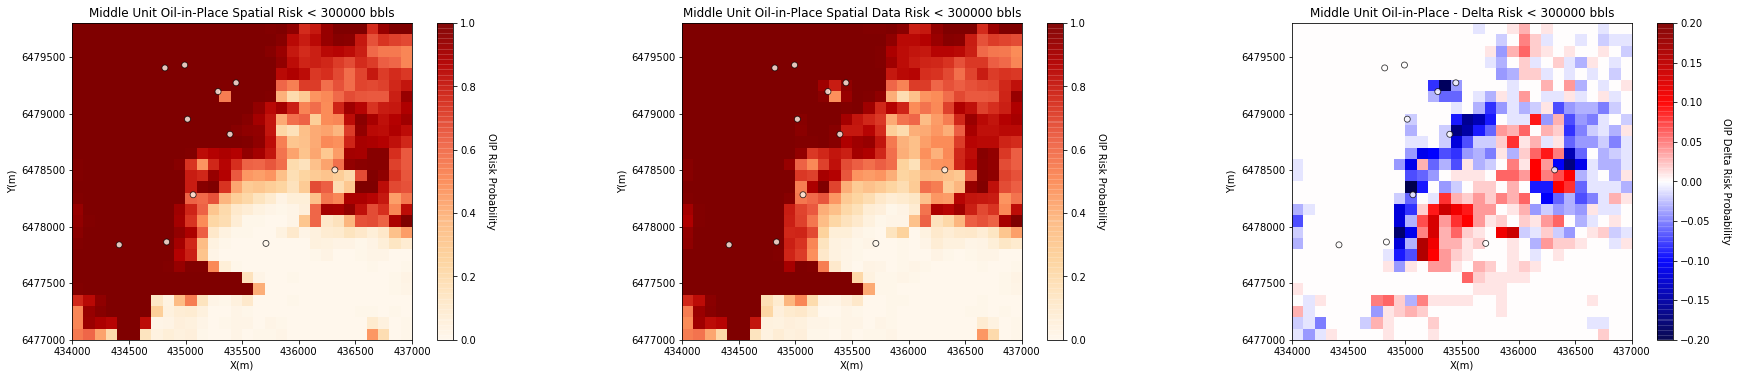

In [396]:
thresh1 = 300000                          # set the economic OIP thresholds

prob_spatial = 1.0-local_probability_exceedance(realizations = realizations_spatial,threshold = thresh1)
prob_data_spatial = 1.0-local_probability_exceedance(realizations = realizations_data_spatial,threshold = thresh1)
prob_delta = prob_data_spatial - prob_spatial 

plt.subplot(1,3,1)
locpix_st(prob_spatial,Xmin,Xmax,Ymin,Ymax,xsiz,0.0,1.,df,'X','Y','dummy',unit + ' Unit Oil-in-Place Spatial Risk < ' + str(thresh1) + ' bbls','X(m)','Y(m)','OIP Risk Probability',plt.cm.OrRd)

plt.subplot(1,3,2)
locpix_st(prob_data_spatial,Xmin,Xmax,Ymin,Ymax,xsiz,0.0,1.,df,'X','Y','dummy',unit + ' Unit Oil-in-Place Spatial Data Risk < ' + str(thresh1) + ' bbls','X(m)','Y(m)','OIP Risk Probability',plt.cm.OrRd)

plt.subplot(1,3,3)
locpix_st(prob_delta,Xmin,Xmax,Ymin,Ymax,xsiz,-0.2,0.2,df,'X','Y','dummy',unit + ' Unit Oil-in-Place - Delta Risk < ' + str(thresh1) + ' bbls','X(m)','Y(m)','OIP Delta Risk Probability',plt.cm.seismic)

plt.subplots_adjust(left=0.0, bottom=0.0, right=4.0, top=1.1, wspace=0.2, hspace=0.2)
plt.show()

#### Check in Uncertainty and Risk the the Addition of Well Data

Let's select and remove a well to quantify the change in uncertainty and risk maps.

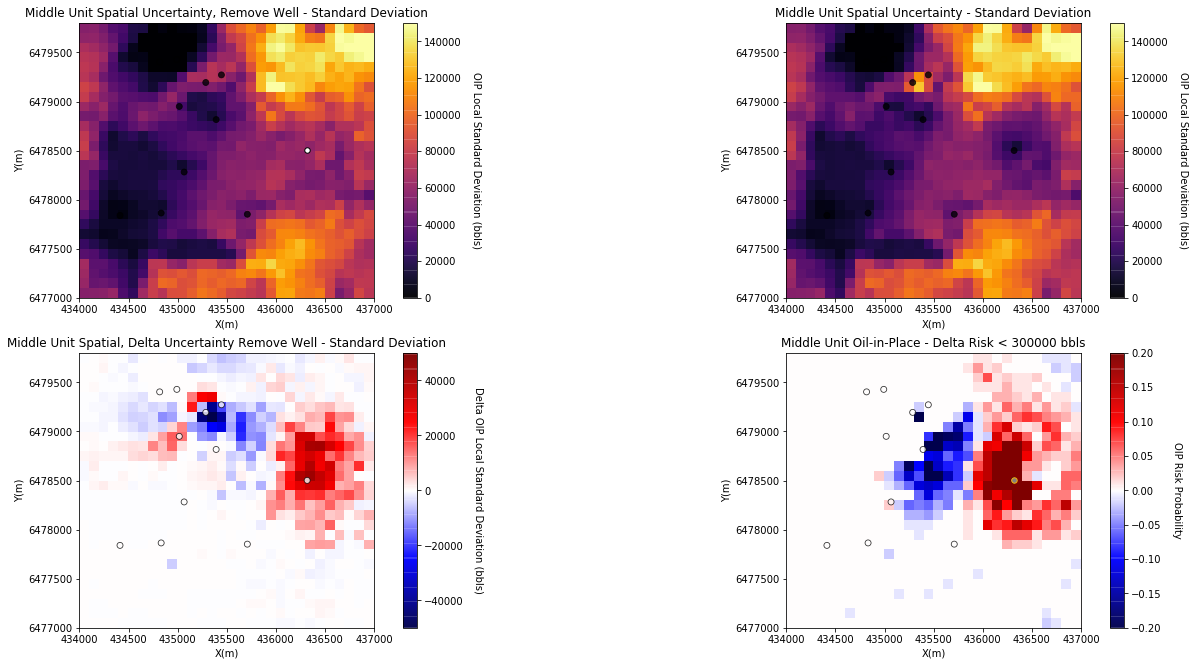

In [398]:
data_select = np.full(len(df),True)
data_select[idata] = False

data = False; trend = False; dist = False; spatial = True
realizations_spatial_remove_well = run_realizations(data,trend,dist,spatial,nreal,data_select)
stdev_spatial_remove_well = local_standard_deviation(realizations_spatial_remove_well)

stdev_delta_remove_well = stdev_spatial_remove_well - stdev_spatial

prob_data_spatial_remove_well = 1.0-local_probability_exceedance(realizations = realizations_spatial_remove_well,threshold = thresh1)
prob_delta_remove_well = prob_data_spatial_remove_well - prob_spatial 

plt.subplot(222)
locpix_st(stdev_spatial,Xmin,Xmax,Ymin,Ymax,xsiz,0.0,oip_std_max,df,'X','Y',features[i],unit + ' Unit Spatial Uncertainty - Standard Deviation','X(m)','Y(m)','OIP Local Standard Deviation (bbls)',cmap)

plt.subplot(221)
locpix_st(stdev_spatial_remove_well,Xmin,Xmax,Ymin,Ymax,xsiz,0.0,oip_std_max,df[data_select],'X','Y',features[i],unit + ' Unit Spatial Uncertainty, Remove Well - Standard Deviation','X(m)','Y(m)','OIP Local Standard Deviation (bbls)',cmap)
plt.scatter([df.loc[idata,'X']],[df.loc[idata,'Y']],s=30.,edgecolor='black',c='white')

plt.subplot(223)
locpix_st(stdev_delta_remove_well,Xmin,Xmax,Ymin,Ymax,xsiz,oip_delta_min,oip_delta_max,df,'X','Y',features[i],unit + ' Unit Spatial, Delta Uncertainty Remove Well - Standard Deviation','X(m)','Y(m)','Delta OIP Local Standard Deviation (bbls)',cmap=plt.cm.seismic)

plt.subplot(224)
locpix_st(prob_delta_remove_well,Xmin,Xmax,Ymin,Ymax,xsiz,-0.2,0.2,df,'X','Y','dummy',unit + ' Unit Oil-in-Place - Delta Risk < ' + str(thresh1) + ' bbls','X(m)','Y(m)','OIP Risk Probability',plt.cm.seismic)
plt.scatter([df.loc[idata,'X']],[df.loc[idata,'Y']],s=30.,edgecolor='orange',c='gray')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=2.1, wspace=0.2, hspace=0.2)
plt.show()